# Projet P3 - Préparez des données pour un organisme de santé publique
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - Novembre 2023*
<hr>

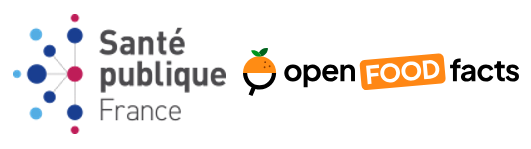

# <font color='#0a389f'>Introduction<a class="anchor" id="Presentation_projet"></a></font>

## <font color='#46abe6'>Contexte et mission</font>
L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts. Cette base de données open source est mise à la disposition de particuliers et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits.
Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France souhaite créer un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. 

Le présent projet concerne les étapes de nettoyage et exploration des données, afin d'établir la faisabilité de suggérer les valeurs manquantes.

## <font color='#46abe6'>Données</font>
- Source :  [Open Food Facts](https://world.openfoodfacts.org/) 
- Informations sur les données : [Open Food Facts - Data Fields](https://world.openfoodfacts.org/data/data-fields.txt) 

## <font color='#46abe6'>Sommaire</font>

<span style='background:#d5155b'><span style='color:white'>**Notebook Nettoyage**</span></span>

**[Partie 1 - Importation et Inspection des données](#partie1)**
* [1.1. Importation des librairies](#1_1)
* [1.2. Définition des fonctions](#1_2)
* [1.3. Importation et inspection des données](#1_3)
* [1.4. Description du jeu de données](#1_4)
* [1.5. Données nutritionnelles](#1_5)

**[Partie 2 - Nettoyage des données](#partie2)**
* [2.1. Filtrage des données](#2_1)
* [2.2. Types de variables](#2_2)
* [2.3. Doublons `code`](#2_3)
* [2.4. Homogénéisation des noms des modalités `pnns_groups_1`, `pnns_groups_2` et `main_category_fr`](#2_4)
* [2.5. Identification et traitement des valeurs aberrantes](#2_5)
* [2.6. Identification et traitement des valeurs manquantes](#2_6)
* [2.7. Modifications apportées au jeu de données](#2_7)
* [2.8. Conclusion & Perspectives](#2_8)


<span style='background:#d5155b'><span style='color:white'>**Notebook Analyse exploratoire**</span></span>

**Partie 3 - Analyse exploratoire**
* 3.1. Analyse univariée
* 3.2. Analyse bivariée
* 3.3. Analyse multivariée
* 3.4. Conclusion et Perspectives


## <font color='#46abe6'>Notebook</font>
Le présent Notebook concerne les parties 1 et 2.

# <font color='#0a389f'>Partie 1 - Importation et Inspection des données<a class="anchor" id="partie1"></a></font>

## <font color='#46abe6'>1.1. Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from skimpy import skim

# Expression régulière
import re

# recherche contextuelle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Imputer 
from sklearn.impute import KNNImputer

# Régression lineaire
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.26.0
pandas - 2.1.1
seaborn - 0.13.0
missingno - 0.5.2
re - 2.2.1


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

In [4]:
# Options d'affichage : toutes les colonnes
pd.set_option('display.max_columns', None)

## <font color='#46abe6'>1.2. Définition des fonctions<a class="anchor" id="1_2"></a></font>

### Inspection du dataframe

In [5]:
# Fonction pour inspection df
def inspection(df, dfname):
    """!
    @brief Effectue une inspection approfondie du dataframe.

    Cette fonction affiche les premières lignes, les dimensions, les types de variables, 
    les valeurs manquantes, supprime les colonnes vides, identifie les doublons
    et présente une description statistique du dataframe.

    @param df: Dataframe à inspecter (pandas DataFrame).
    @param dfname: Nom du dataframe (str).
    """
    print("*" * 50)
    print(f"Inspection du dataframe {dfname}")
    print("*" * 50)
    print("")
    
    # Affichage des premières lignes du dataframe
    print("Dataframe")
    print("-" * 50)
    display(df.head())
    print("")
    
    # Suppression des colonnes vides le cas échéant
    mean_na = df.isna().mean()
    if max(mean_na) == 1:
        print("")
        print("Suppression des colonnes vides")
        print("-" * 50) 
        print('Dimensions du dataframe avant suppression :', df.shape)
        mean_na = df.isna().mean()
        col_null = list(mean_na[mean_na == 1].index)
        print('Colonne(s) supprimée(s) :', col_null)
        df.drop(columns=col_null, inplace=True)
        print('Dimensions du dataframe après suppression :', df.shape)
        print("")
        
    # Affichage des dimensions, types de variables et valeurs non-null, 
    # Description statistique du dataframe (moyenne, écart-type, min-max, médiane, IQR)
    print("Dimensions du dataframe, Types de variables, Description statistique du dataframe, Valeurs non-null")
    print("-" * 50)
    print(skim(df))
    print("")
          
    # Affichage des valeurs uniques par colonne
    print("Valeurs uniques par variable")
    print("-" * 50)   
    print(df.nunique())
    print("")
    
    # Identification et affichage des doublons
    print("Nombre de doublons")
    print("-" * 50)   
    print(df.duplicated().sum())
    print("")
           
    # Affichage du graphique des valeurs manquantes (si applicable)
    if sum(df.isna().sum()) > 0:
        print("")
        print("Graphique des valeurs manquantes")
        print("-" * 50)    
        msno.bar(df)
        msno.matrix(df)

### Nettoyage

In [6]:
def convert_date_columns(df, date_columns, change_log_df):
    """!
    @brief: Convertit les colonnes de dates spécifiées d'un DataFrame au format datetime.
    
    Cette fonction itère sur les colonnes de dates spécifiées dans le DataFrame et les convertit au format datetime.
    Si le nom de la colonne se termine par '_t', il s'agit d'un horodatage UNIX, et la colonne datetime
    correspondante est ajoutée avec le suffixe '_datetime'. 
    Si le nom de la colonne se termine par '_datetime', il est au format datetime ISO8601 et il est converti directement.

    @param df: Le DataFrame contenant les colonnes de dates, type pd.DataFrame.
    @param date_columns: Une liste de noms de colonnes à convertir en datetime, type list.
    @param change_log_df: Dataframe listant les modifications, type pd.DataFrame.
    """    
    for col in date_columns:
        if col.endswith('_t'):
            # Convertir UNIX timestamp en datetime
            df[col + '_datetime'] = pd.to_datetime(pd.to_numeric(df[col]), errors='coerce')
            print(col + '_datetime : ', df[col + '_datetime'].dtypes)
        elif col.endswith('_datetime'):
            # Convertir ISO8601 datetime
            df[col] = pd.to_datetime(df[col], errors='coerce')
            print(col+' :', df[col].dtypes)
            
    
    # Ajout de la modification au change_log 
    change_log(change_log_df, frfoodfacts_df, 
           ['Type de variables', date_columns, "Changement du type de variables : date au format datetime"])

In [7]:
def choose_duplicates(df, primary_key, last_modified_date, change_log_df):
    """!
    @brief Supprime les lignes sans primary_key, identifie et conserve les lignes uniques dans un DataFrame 
    en fonction de certaines conditions.

    Cette fonction supprime les lignes avec une valeur manquante pour la clé primaire, trie le DataFrame par la colonne 
    'last_modified_datetime' dans l'ordre décroissant, identifie les doublons dans la colonne {primary_key}, 
    puis sélectionne la ligne à conserver pour chaque code en fonction du nombre total de valeurs manquantes dans le 
    DataFrame. Elle appelle ensuite la fonction change log pour le suivi des modifications.

    @param df : Le DataFrame à traiter, type pd.DataFrame.
    @param primary_key : Le nom de la colonne utilisée pour identifier les doublons, type str.
    @param change_log_df: Dataframe listant les modifications, type pd.DataFrame.
    @param last_modified_date : Le nom de la colonne 'last_modified_date', type str.

    @return df_results : Un nouveau DataFrame contenant les lignes à conserver, type pd.DataFrame.
    """
    # Supprime les lignes sans 'primary_key'
    df = df.dropna(subset=primary_key, axis=0)
    
    # Tri le DataFrame par la colonne 'last_modified_date' dans l'ordre décroissant
    df = df.sort_values(by=last_modified_date, ascending=False)

    # Identifie les doublons dans la colonne 'primary_key'
    duplicates = df[df.duplicated(subset=primary_key, keep=False)]

    # Initialisation du dictionnaire pour stocker les lignes à conserver
    row_to_keep = {}

    # Trouver la ligne à conserver pour chaque code
    for code, group in duplicates.groupby(primary_key):
        # Trie le groupe par le nombre total de valeurs manquantes de la ligne
        group = group.sort_values(by=group.isna().sum(axis=1))

        # Sélectionne la première ligne du groupe après le tri
        row_to_keep = group.iloc[0]

        # Stocke la ligne à conserver dans le dictionnaire
        row_to_keep[code] = row_to_keep

    # Créez un DataFrame à partir des lignes à conserver
    df_without_duplicates = df.drop_duplicates(subset=primary_key, keep=False)
    row_to_keep_df = pd.DataFrame(list(row_to_keep.values()))
    df_results = pd.concat([df_without_duplicates, row_to_keep_df], ignore_index=True)
    
    # Ajout de la modification au change_log 
    change_log(change_log_df, frfoodfacts_df, 
           ['Doublons', primary_key, 
            f"Suppression des lignes avec une valeur manquante pour {primary_key} et traitement des doublons"\
            "(conserve la lignes modifiée le plus recemment et avec le moins de valeurs manquantes)"])
    
    return df_results

In [8]:
def correct_categ(df, categ_groups, change_log_df):
    """!
    @brief Corrige les catégories dans un DataFrame en appliquant certaines transformations.

    Pour chaque colonne spécifiée dans categ_groups, cette fonction convertit les modalités en minuscules et les sépare par un '-',
    puis remplace 'unknown' par NaN.

    @param df : Le DataFrame à corriger, type pd.DataFrame.
    @param categ_groups : Liste des colonnes de catégories à traiter, type list.
    @param change_log_df : Le DataFrame de changement à mettre à jour, type pd.DataFrame.

    @return df_cleaned : Le DataFrame corrigé, type pd.DataFrame.
    """
    
    df_cleaned = df.copy()
    
    # pour chaque item de categ_groups
    for col in categ_groups:
        # Ecriture des modalités en minuscules et séparation par un '-'
        df_cleaned[col] = df_cleaned[col].str.lower().str.replace(' ', '-')
        # Remplacer 'unknow' par 'NaN'
        df_cleaned[col] = df_cleaned[col].replace('unknown', np.nan)
     
    # Ajoute la modification au change_log
    change_log(change_log_df, 
               df_cleaned, 
               ['Modalités', 
                categ_groups, 
                "Ecriture des modalités en minuscules et séparation par un '-' et remplacer 'unknown' par 'NaN'"] 
               )
    
    return df_cleaned

### Détection des outliers et représentation graphique

In [9]:
def detectOutlier(data, threshold):
    """!
    @brief Détecte les outliers dans une série de données en utilisant la méthode du z-score.

    Cette fonction identifie les valeurs aberrantes (outliers) dans une série de données en comparant
    les valeurs individuelles à la moyenne et à l'écart-type. Les valeurs au-dessus du seuil spécifié
    sont considérées comme des outliers.

    @param data: Série de données à analyser pour la détection des outliers (pandas Series ou liste).
    @param threshold: Seuil au-dessus duquel le z-score est considéré comme outlier (float, valeur recommandée : [2, 3]).
    @return outliers: Liste des outliers de la variable (list).
    """
    outliers = []  # Crée une liste vide pour stocker les outliers
    mean = np.mean(data)  # Calcul de la moyenne des données
    std = np.std(data)  # Calcul de l'écart-type des données
    
    for i in data:
        if std == 0:
            print('Écart-type nul')
            break
        z_score = (i - mean) / std  # Calcul du z-score pour la valeur i
        if np.abs(z_score) > threshold:  # Valeur absolue du z-score
            outliers.append(i)  # Ajoute i à la liste des outliers
            
    return outliers

In [10]:
def print_outlier(df, columns, res_var):
    """!
    @brief: Identifie les outliers pour chaque indicateur et les affiche dans le dataframe de sortie.
         
    @param df : Le dataframe contenant les données à analyser.
    @param columns : Liste des noms de colonnes à analyser.
    @param res_var : Liste des variables à afficher pour le nom de colonne dans le dataframe de sortie.
    """
    for col in columns:
        #Application de la fonction à la série subset
        subset = df[col]
        outliers = detectOutlier(subset,2)
        var=res_var+[col]
        res=df.loc[df[col].isin(outliers),var].sort_values(col, ascending=False)
        #affichage des outliers détectés
        print()
        print(f"{col} : Nombre d'outliers détectés => " + str(len(outliers)))
        display(res)

In [11]:
def delta_graph(df, col, eval_col, formula, display_col):
    """
    @brief Calcule l'écart entre la colonne évaluée 'eval_col' et la colonne de référence 'col', et affiche 
    l'histogramme des écarts.

    Cette fonction prend un DataFrame `df` contenant les données, ainsi que le nom de la colonne à comparer `col` 
    et la colonne d'évaluation `eval_col`.
    Elle effectue le calcul de la différence entre ces deux colonnes et affiche un histogramme des écarts. 
    La fonction retourne la liste des index des élèments du DataFrame `result_neg` contenant les données où 
    la colonne évaluée est supérieure à la colonne de référence.

    @param df: DataFrame de type pd.DataFrame contenant les données.
    @param col: Nom de la colonne de référence à comparer, de type str.
    @param eval_col: Colonnes d'évaluation pour la comparaison, de type pd.Series.
    @param formula: Formule de calcul de eval_col, de type str.
    @param display_col: Liste des colonnes à afficher dans le résultat, de type list.
    
    @return outliers: Liste des index des élèments du DataFrame `result_neg` contenant les données où 
    la colonne évaluée est supérieure à la colonne de référence, de type list.
    """  
    
    df_temp = df.copy()

    # Calcul de la différence entre les colonnes
    delta_col = df_temp[col] - eval_col
    df_temp['delta'] = delta_col
    df_temp['eval'] = eval_col
    
    # Colonnes à afficher dans le résultat
    columns = ['product_name', 'pnns_groups_1', 'pnns_groups_2']+[col]+display_col+['eval','delta']
        
    # Représentation de la distribution des écarts
    plt.hist(delta_col)
    plt.xlabel(f'Écart entre {col} et son évaluation')
    plt.ylabel('Nombre')
    plt.title(f'Distribution des écarts entre {col} et\n {formula}')
    plt.show()
    
    # delta < 0
    results_neg = df_temp[(delta_col<0)&(df_temp[col].notna())]
    nb_val = results_neg.shape[0]
    percent_val = round(results_neg.shape[0]/df_temp.shape[0]*100,2)
    print("Il y a ",nb_val,f" valeurs de {formula} > {col} soit", percent_val,"% du dataset.")
        
    display(round(results_neg[columns].sort_values('delta'), 1).head())
    
    outliers = list(results_neg.index)
    
    return outliers

In [12]:
def total_100g(df, tolerance):
    """
    @brief Calcule la somme des composants 'salt_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g'
    et affiche la distribution du total 'total_100g' ainsi que les lignes où 'total_100g' est > seuil.

    Cette fonction prend un DataFrame `df` contenant les données, une tolérance appliquée sur la somme des composants 
    `tolerance`. Elle calcule la somme des composants spécifiés et affiche un histogramme de la distribution de la somme. 
    La fonction affiche également les lignes où la somme est supérieure à un seuil déterminé par la tolérance.
    La fonction retourne la liste des index des élèments du DataFrame `results` contenant les données où la somme des 
    composants est supérieure au seuil.

    @param df: Le DataFrame de type pd.DataFrame contenant les données.
    @param tolerance: La tolérance appliquée sur le total des composants, de type float.

    @return outliers: Liste des index des élèments du DataFrame 'results' contenant les données où la somme des composants 
    est supérieure au seuil.
    """
    # Copie du dataframe
    df_total = df.copy()
    
    # Tolérance pour la somme des composants
    seuil = 100 * (1 + tolerance)
    
    columns = ['salt_100g','fat_100g','carbohydrates_100g', 'fiber_100g', 'proteins_100g']
    
    # Calcul de salt_100g + fat_100g + carbohydrates_100g + proteins_100g
    df_total['total_100g'] = df[columns].sum(axis=1)

    # Représentation de la distribution
    plt.hist(df_total['total_100g'])
    plt.xlabel('salt_100g + fat_100g + carbohydrates_100g + fiber_100g + proteins_100g')
    plt.ylabel('Nombre')
    plt.title(f'Distribution de la somme des composants')
    plt.tight_layout()
    plt.show()
    
    # Nombre de valeurs hors limite
    results = df_total[df_total['total_100g'] > seuil]
    nb_val = results.shape[0]
    percent_val = round(results.shape[0]/df_total.shape[0]*100,2)
    print("Il y a ",nb_val,f" produits pour lesquels la somme des composants > {seuil}g soit", percent_val,"% du dataset.")
    
    # Affichage des valeurs hors limite
    display(results[['product_name', 'total_100g']+columns].sort_values('total_100g', ascending=False).head())
    
    outliers = list(results.index)
    
    return outliers

In [13]:
def filter_df_by_range(df, col, min_value, max_value, change_log_df):
    """!
    @brief Exclut les données en dehors d'un intervalle spécifié pour une colonne donnée dans un DataFrame.

    Cette fonction filtre les données du DataFrame en fonction des valeurs d'une colonne spécifiée, 
    excluant celles qui sont en dehors de l'intervalle [min_value, max_value] et met également à jour le change log. 
    Les valeurs nulles dans la colonne sont conservées.
    
    @param df: Le DataFrame à filtrer.
    @param col: Le nom de la colonne à utiliser pour le filtrage.
    @param min_value: La valeur minimale (incluse) pour l'intervalle.
    @param max_value: La valeur maximale (incluse) pour l'intervalle.
    @param change_log_df: Le DataFrame du journal des changements.    
    
    @return df: Le DataFrame filtré.
    """
    df = df[df[col].apply(lambda x: min_value <= x <= max_value) | (df[col].isna())]
    
    # Ajout de la modification au change_log 
    change_log(change_log_df, 
               df, 
               ['Outliers', f'{col}', f" Ecarter les données de {col} non comprise dans [{min_value}, {max_value}]"])
    
    return df

### Suivi des modifications

In [14]:
def change_log(change_log_df, df, change_list ):
    """!
    @brief: Met à jour un dataframe listant les modifications apportées

    Cette fonction ajoute une ligne au dataframe change_log_df décrivant les modifications apportées à df

    @param change_log_df : Dataframe listant les modifications
    @param df : Dataframe qui a été modifié
    @param change_list : Liste avec [type de mofication, sur quelle variable, description de la modification]
    """
    # Nouvelle ligne : dimensions du dataframe, type de change, sur quelle variable, description du change
    new_row = [
               df.shape[0],
               df.shape[1],
               change_list[0],
               change_list[1],
               change_list[2]
               ]
    
    # ajoute la nouvelle ligne à la fin de change_log_df
    change_log_df.loc[len(change_log_df)] = new_row

### Statistiques

In [15]:
def q1(x):
    """!
    @brief Calcule le premier quartile d'une série de données.

    Cette fonction prend une série de données en entrée et retourne le premier quartile (Q1),
    qui représente la valeur en-dessous de laquelle 25% des données se situent.

    @param x: Série de données (pandas Series).
    @return x.quantile(0.25): Premier quartile de la série x (type float).
    """

    return x.quantile(0.25)

def q3(x):
    """!
    @brief Calcule le troisième quartile d'une série de données.

    Cette fonction prend une série de données en entrée et retourne le troisième quartile (Q3),
    qui représente la valeur en-dessous de laquelle 75% des données se situent.

    @param x: Série de données (pandas Series).
    @return x.quantile(0.75): Troisième quartile de la série x.
    """

    return x.quantile(0.75)

In [16]:
def stats(df, indicator, var, colors, showfliers):
    """!
    @brief Affiche pour chaque indicateur une table avec les statistiques et un boxplot par modalité de la variable.

    Cette fonction génère une table contenant les statistiques des indicateurs et affiche un boxplot pour chaque indicateur,
    regroupé par modalité de la variable spécifiée. Elle appelle les fonctions q1() et q3() pour afficher le premier et 
    le troisième quantiles.

    @param df: Dataframe contenant les données (pandas DataFrame).
    @param indicator: Liste contenant les noms des indicateurs à analyser (list de str).
    @param var: Variable utilisée pour le regroupement (str).
    @param colors: Liste des couleurs à utiliser pour le graphique (list de str).
    @param showfliers: True or False, pour l'affichage des outliers.
    """

    # Statistiques descriptives à afficher
    stats = ['count','mean', 'std', 'min', q1, 'median', q3, 'max']
    # Caractéristiques d'affichage de meanprops
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

    # Boucle pour afficher pour chaque indicateur : une table avec les statistiques et un boxplot par var
    for ind in indicator:
        # Affichage des statistiques sous forme de table
        display(round(df.groupby(var).agg({ind: stats}),2))

        # Création et affichage du boxplot
        sns.boxplot(data=df.sort_values(var), 
                    x=ind, 
                    y=var, 
                    hue=var, 
                    showfliers=showfliers, 
                    showmeans=True, 
                    meanprops=meanprops,
                    palette=colors,
                    legend=False)
        plt.title(ind+" : Distribution par "+var)
        plt.show()

### Imputation des valeurs manquantes

In [17]:
def map_subcat_to_cat(subcat, categories_dict, df):
    """!
    @brief Mappe une sous-catégorie à sa catégorie correspondante.

    Cette fonction prend une sous-catégorie et un dictionnaire de correspondances entre
    catégories et sous-catégories. Elle renvoie la catégorie correspondante à la
    sous-catégorie donnée. 

    @param subcat: Sous-catégorie à mapper (type str).
    @param categories_dict: Dictionnaire de correspondances entre catégories et sous-catégories (type dict).
    @param df: DataFrame à modifier (type pandas DataFrame).
    @return: Catégorie correspondante à la sous-catégorie (type str ou None si aucune correspondance).
    """

    # Recherche de la catégorie correspondante à la sous-catégorie
    original_category = None
    for cat, subcats in categories_dict.items():
        if subcat in subcats:
            original_category = cat

    return original_category

In [18]:
def apply_pnns_imputations(df, var, imputation_dicts, change_log_df):
    """!
    @brief Applique des imputations de valeurs manquantes en fonction de correspondances 'mask' et var.

    Cette fonction prend un DataFrame, une liste de dictionnaires spécifiant les correspondances 'mask' et var,
    et un DataFrame pour enregistrer les modifications (change_log_df). Elle effectue les imputations sur le DataFrame
    et met à jour le changelog avec les informations sur les modifications.

    @param df: DataFrame à modifier, type pd.DataFrame.
    @param var: variable à imputer, type str. 
    @param imputation_dicts: Liste de dictionnaires spécifiant les correspondances 'mask' et var.
    @param change_log_df: DataFrame listant les modifications, type pd.DataFrame.
    """

    for imputation_dict in imputation_dicts:
        mask = imputation_dict['mask']
        value = imputation_dict[var]

        # Appliquer l'imputation
        df.loc[mask, var] = value

        # Nouvelle ligne pour le changelog
        change_list = ['Imputation de valeurs manquantes', var, f"Imputation de {var} pour" \
        f" les valeurs qui satisfont la condition"]

        # Ajouter la nouvelle ligne à la fin de change_log_df
        change_log(change_log_df, df, change_list)

In [19]:
def category_dictionary(df):
    """!
    @brief Génère un dictionnaire associant les groupes 'pnns_groups_1' aux catégories principales ('main_category_fr') 
    les plus fréquentes.

    Cette fonction prend un DataFrame en entrée, groupe les données par 'pnns_groups_1' et 'main_category_fr', compte 
    les occurrences, filtre les catégories les plus fréquentes (fréquence > 100), et renvoie un dictionnaire associant 
    les groupes 'pnns_groups_1' aux listes des catégories principales les plus fréquentes pour chaque groupe.

    @param df : Le DataFrame d'entrée, type pd.DataFrame.

    @return categ_dict : Le dictionnaire associant les groupes 'pnns_groups_1' aux catégories principales les plus 
    fréquentes, type dict.
    """
    # Initialiser une liste pour stocker les résultats intermédiaires
    results_list = []

    # Grouper par 'pnns_groups_1' et 'main_category_fr', compter les occurrences, trier et sélectionner les plus fréquentes
    for group, data in df.groupby('pnns_groups_1'):
        frequent_categories = (
            data.groupby('main_category_fr')['code']
            .count()
            .reset_index(name='frequency')
            .sort_values('frequency', ascending=False)
        )

        # Filtrer les occurrences supérieures à 100
        frequent_categories = frequent_categories[frequent_categories['frequency'] > 100]

        # Fusionner les résultats pour obtenir le groupe, la fréquence et le nombre total de groupes
        result = frequent_categories

        # Ajouter le groupe en tant que colonne supplémentaire
        result['pnns_groups_1'] = group

        # Ajouter le résultat à la liste
        results_list.append(result)

    # Concaténer tous les résultats en un seul DataFrame
    concat_result = pd.concat(results_list, ignore_index=True)

    # Compter le nombre total de groupes par catégorie principale
    total_groups = (
        df.groupby('main_category_fr')['pnns_groups_1']
        .nunique()
        .reset_index(name='total_groups')
        .sort_values('total_groups', ascending=False)
    )

    # Fusionner les résultats avec le nombre total de groupes
    final_result = pd.merge(concat_result, total_groups, on='main_category_fr', how='left')

    # Filtrer les catégories principales avec un nombre total de groupes inférieur ou égal à 2
    final_result = final_result[final_result['total_groups'] <= 2].sort_values(by='frequency', ascending=False)\
                                                                 .drop_duplicates(subset='main_category_fr')

    # Générer le dictionnaire associant les groupes 'pnns_groups_1' aux catégories principales
    categ_dict = final_result.groupby('pnns_groups_1')['main_category_fr'].unique().apply(list).to_dict()

    return categ_dict

In [20]:
def fillnan_zero(df, mask, columns_tofill, change_log_df):
    """!
    @brief Remplace les valeurs nulles des colonnes {columns_to_fil} par 0 dans le DataFrame df filtré. 
    Les conditions du filtre sont définies dans le {mask}.
    Met à jour le changelog avec les informations sur les modifications.
    
    @param df: type pd.DataFrame, Le DataFrame à mettre à jour.
    @param mask: La condition qui doit être vérifiée pour le filtre du dataframe, sous forme de code.
    @param columns_tofill: type List, La liste des colonnes pour lesquelles traitées les valeurs manquantes.
    @param change_log_df: DataFrame listant les modifications, type pd.DataFrame.
    """
    # remplace les valeurs manquantes par 0
    df.loc[mask, columns_tofill] = df.loc[mask, columns_tofill].fillna(0)
    
    # Nouvelle ligne pour le changelog
    change_list = ['Imputation de valeurs manquantes', columns_tofill, f"Imputation à 0 pour les lignes"\
                   f" qui satisfont la condition"]

    # Ajouter la nouvelle ligne à la fin de change_log_df
    change_log(change_log_df, df, change_list)

In [21]:
def fillna_based_on_group(df, col_name, group, agg_func='median'):
    """!
    @brief Remplit les valeurs manquantes dans la colonne 'col_name' en utilisant la médiane ou la moyenne
    du groupe 'pnns_groups'.
    
    Cette fonction itére sur les lignes du df avec des valeurs manquantes dans la colonne 'col_name', remplit la valeur 

    @param df: Le DataFrame à mettre à jour.
    @param col_name: Le nom de la colonne à mettre à jour.
    @param group: Le nom de la colonne à agréger
    @param agg_func: La fonction d'agrégation à utiliser ('median' ou 'mean').
    
    @return df: Le DataFrame mis à jour.
    """
    
    # Boucle pour itérer sur les lignes du df avec des valeurs manquantes dans la colonne 'col_name', 
    for index, row in df[(df[group].notna())&(df[col_name].isna())].iterrows():
        
        # Remplir les valeurs manquantes en utilisant la médiane ou la moyenne de group
        group_name = row[group]
        if agg_func == 'median':
            value = round(df[(df[group] == group_name)&(df[col_name].notna())][col_name].median(), 1)
        elif agg_func == 'mean':
            value = round(df[(df[group] == group_name)&(df[col_name].notna())][col_name].mean(), 1)
            
        df.at[index, col_name] = value
    
    return df

In [22]:
def fillna_categ(df, categ_dict, nan_feature, categ_feature, change_log_df):
    """!
    @brief Impute les valeurs nulles de 'nan_feature' en fonction des mots-clés présents dans 'categ_feature', 
    met à jour le changelog avec les informations sur les modifications. 

    @param df: Le DataFrame à mettre à jour, type pd.DataFrame.
    @param categ_dict :  Le dictionnaire de correspondance entre group et catégorie, type dict.
    @param nan_feature : La variable contenant les valeurs manquantes, type str. 
    @param categ_feature : La variable où rechercher les mots-clés, type str
    @param change_log_df: DataFrame listant les modifications, type pd.DataFrame.
    
    @return df : Le dataframe mis à jour, type pd.DataFrame.
    """
    
    # Modifier le disctionnaire pour avoir 'mot-clé : group'
    inverse_dict = {categ: group for group, categs in categ_dict.items() for categ in categs}

    # Compléter les valeurs manquantes
    for categ, group in inverse_dict.items():
        mask = ((df[nan_feature].isna()) & (df[categ_feature]==categ))
        df.loc[mask, nan_feature] = group
    
    # Ajoute la modification au change_log
    change_log(change_log_df, 
               frfoodfacts_df, 
               ['Imputation des valeurs manquantes', 
                nan_feature, 
                f"Imputer {nan_feature} en fonction des catégories {categ_feature} les plus fréquentes"] 
               )      
    return df

### Recherche de mots-clés

In [23]:
def extract_keywords(text):
    """
    @brief Extrait les mots-clés d'une chaîne de caractères.

    @param text: La chaîne de caractères à analyser.
    @return: Une liste de mots-clés.
    """
    # Tokenisation des mots
    words = word_tokenize(text)

    # Suppression des mots vides (stopwords)
    stop_words = set(stopwords.words('french'))  
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    return filtered_words

In [24]:
def keywords_to_dict(df, group_feature, kw_feature):
    """
    @brief Extrait des mots-clé uniques d'une variable 'kw_feature' pour chaque modalité de la variable 'imput_feature'

    @param df: Le DataFrame où chercher les mots-clés.
    @param group_feature : La variable pour laquelle associée des mots-clés pour chaque modalité 
    @param kw_feature : La variable où rechercher les mots-clés 
    
    @return keywords_dict : Le dictionnaire contenant les mots-clés associés à chaque modalité
    """
    
    keywords_dict = {} # Dictionnaire pour stocker les mots-clés par groupe
    keyword_occurrence = {} # Dictionnaire pour suivre l'occurrence de chaque mot-clé
    group_list = list(df.loc[frfoodfacts_df[group_feature].notna(),
                                             group_feature].unique()) # liste des modalités de 'imput_feature'

    # Boucle pour extraire les mots-clés uniques de chaque groupe
    for group in group_list:
        # Extraire les mots-clés uniques de chaque groupe et les combiner en une seule chaîne de caratères
        text_list = list(df.loc[(df[group_feature] == group) &
                                             (df[kw_feature].notna()), kw_feature].unique())
        all_text = ' '.join(text_list)

        # Extrait les mots-clés et les stocker dans le dictionnaire
        keywords = extract_keywords(all_text)
        keywords_dict[group] = keywords

        # Mettre à jour le suivi de l'occurrence des mots-clés
        for keyword in keywords:
            keyword_occurrence[keyword] = keyword_occurrence.get(keyword, 0) + 1

    # Supprimer les mots-clés qui apparaissent dans plus d'un groupe
    for group, keywords in keywords_dict.items():
        keywords_dict[group] = [keyword for keyword in keywords if keyword_occurrence[keyword] == 1]

    return keywords_dict

## <font color='#46abe6'>1.3. Importation et inspection des données<a class="anchor" id="1_3"></a></font>

In [25]:
# Liste des numéros de colonne avec DtypeWarning
dtypewarning = [0, 3, 5, 19, 20, 24, 25, 26, 27, 28, 35, 36, 37, 38, 39, 48]

# Dictionnaire de types de données pour les colonnes avec DtypeWarning (traitées comme des chaînes de caractères)
dtypes = {column: str for column in dtypewarning}

# Importation des données
foodfacts_df=pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', dtype=dtypes)

In [26]:
# Options d'affichage : toutes les lignes
pd.set_option('display.max_rows', None)

**************************************************
Inspection du dataframe Open food facts - Products
**************************************************

Dataframe
--------------------------------------------------


code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity packaging packaging_tags           brands  \
0          NaN      1kg       NaN            NaN  Ferme t'y R'nao   
1          NaN      NaN       NaN            NaN              NaN   
2          NaN      NaN       NaN            NaN   Torn & Glasser   
3          NaN      NaN       NaN            NaN        Grizzlies   
4          NaN      NaN       NaN            NaN   Bob's Red Mill   

       brands_tags categories categories_tags categories_fr origins  \
0  ferme-t-y-r-nao        NaN             NaN           NaN     NaN   
1              NaN        NaN             NaN           NaN     NaN   
2     torn-glasser        NaN             NaN           NaN     NaN   
3        grizzlies        NaN             NaN           NaN     NaN   
4   bob-s-red-mill        NaN             NaN           NaN     NaN   

  origins_tags manufacturing_places manufacturing_places_tags labels  \
0          NaN                  NaN                       NaN    NaN   
1          NaN                  NaN                       NaN    NaN   
2          NaN                  NaN                       NaN    NaN   
3          NaN                  NaN                       NaN    NaN   
4          NaN                  NaN                       NaN    NaN   

  labels_tags labels_fr emb_codes emb_codes_tags first_packaging_code_geo  \
0         NaN       NaN       NaN            NaN                      NaN   
1         NaN       NaN       NaN            NaN                      NaN   
2         NaN       NaN       NaN            NaN                      NaN   
3         NaN       NaN       NaN            NaN                      NaN   
4         NaN       NaN       NaN            NaN                      NaN   

  cities cities_tags purchase_places stores countries    countries_tags  \
0    NaN         NaN             NaN    NaN     en:FR         en:france   
1    NaN         NaN             NaN    NaN        US  en:united-states   
2    NaN         NaN             NaN    NaN        US  en:united-states   
3    NaN         NaN             NaN    NaN        US  en:united-states   
4    NaN         NaN             NaN    NaN        US  en:united-states   

  countries_fr                                   ingredients_text allergens  \
0       France                                                NaN       NaN   
1   États-Unis  Bananas, vegetable oil (coconut oil, corn oil ...       NaN   
2   États-Unis  Peanuts, wheat flour, sugar, rice flour, tapio...       NaN   
3   États-Unis  Organic hazelnuts, organic cashews, organic wa...       NaN   
4   États-Unis                                    Organic polenta       NaN   

  allergens_fr traces traces_tags traces_fr     serving_size 



Suppression des colonnes vides
--------------------------------------------------
Dimensions du dataframe avant suppression : (320772, 162)
Colonne(s) supprimée(s) : ['no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk', 'butyric-acid_100g', 'caproic-acid_100g', 'lignoceric-acid_100g', 'cerotic-acid_100g', 'melissic-acid_100g', 'elaidic-acid_100g', 'mead-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g']
Dimensions du dataframe après suppression : (320772, 146)

Dimensions du dataframe, Types de variables, Description statistique du dataframe, Valeurs non-null
--------------------------------------------------


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 320772 │ │ float64     │ 90    │                                                          │
│ │ Number of columns │ 146    │ │ string      │ 56    │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_na ┃        ┃       ┃         ┃         ┃          ┃         ┃         ┃         ┃         ┃        ┃  │
│ ┃ me        ┃ NA     ┃ NA %  ┃ mean    ┃ sd      ┃ p0       ┃ p25     ┃ p50     ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ additives │  71833 │ 22.39 │     1.9 │     2.5 │        0 │       0 │       1 │       3 │      31 │   ▇▁   │  │
│ │ _n        │        │       │         │         │          │         │         │         │         │        │  │
│ │ ingredien │  71833 │ 22.39 │    0.02 │    0.14 │        0 │       0 │       0 │       0 │       2 │   ▇    │  │
│ │ ts_from_p │        │       │         │         │          │         │         │         │         │        │  │
│ │ alm_oil_n │        │       │         │         │          │         │         │         │         │        │  │
│ │ ingredien │  71833 │ 22.39 │   0.055 │    0.27 │        0 │       0 │       0 │       0 │       6 │   ▇    │  │
│ │ ts_that_m │        │       │         │         │          │         │         │         │         │        │  │
│ │ ay_be_fro │        │       │         │         │          │         │         │         │         │        │  │
│ │ m_palm_oi │        │       │         │         │          │         │         │         │         │        │  │
│ │ l_n       │        │       │         │         │          │         │         │         │         │        │  │
│ │ energy_10 │  59659 │  18.6 │    1100 │    6400 │        0 │     380 │    1100 │    1700 │ 3300000 │   ▇    │  │
│ │ 0g        │        │       │         │         │          │         │         │         │         │        │  │
│ │ energy-fr │ 319915 │ 99.73 │     590 │     710 │        0 │      49 │     300 │     900 │    3800 │  ▇▃▁   │  │
│ │ om-fat_10 │        │       │         │         │          │         │         │         │         │        │  │
│ │ 0g        │        │       │         │         │          │         │         │         │         │        │  │
│ │ fat_100g  │  76881 │ 23.97 │      13 │      18 │        0 │       0 │       5 │      20 │     710 │   ▇    │  │
│ │ saturated │  91218 │ 28.44 │     5.1 │       8 │        0 │       0 │     1.8 │     7.1 │     550 │   ▇    │  │
│ │ -fat_100g │        │       │         │         │          │         │         │         │         │        │  │
│ │ caprylic- │ 320771 │   100 │     7.4 │     nan │      7.4 │     7.4 │     7.4 │     7.4 │     7.4 │     ▇  │  │
│ │ acid_100g │        │       │         │         │          │         │         │         │         │        │  │
│ │ capric-ac │ 320770 │   100 │       6 │    0.23 │      5.9 │       6 │       6 │     6.1 │     6.2 │ ▇    ▇ │  │
│ │ id_100g   │        │       │         │         │    

None

Valeurs uniques par variable
--------------------------------------------------
code                                          320749
url                                           320749
creator                                         3535
created_t                                     189567
created_datetime                              189568
last_modified_t                               180495
last_modified_datetime                        180495
product_name                                  221347
generic_name                                   38584
quantity                                       13826
packaging                                      14547
packaging_tags                                 12064
brands                                         58784
brands_tags                                    50253
categories                                     36982
categories_tags                                21142
categories_fr                                  21152
origins      

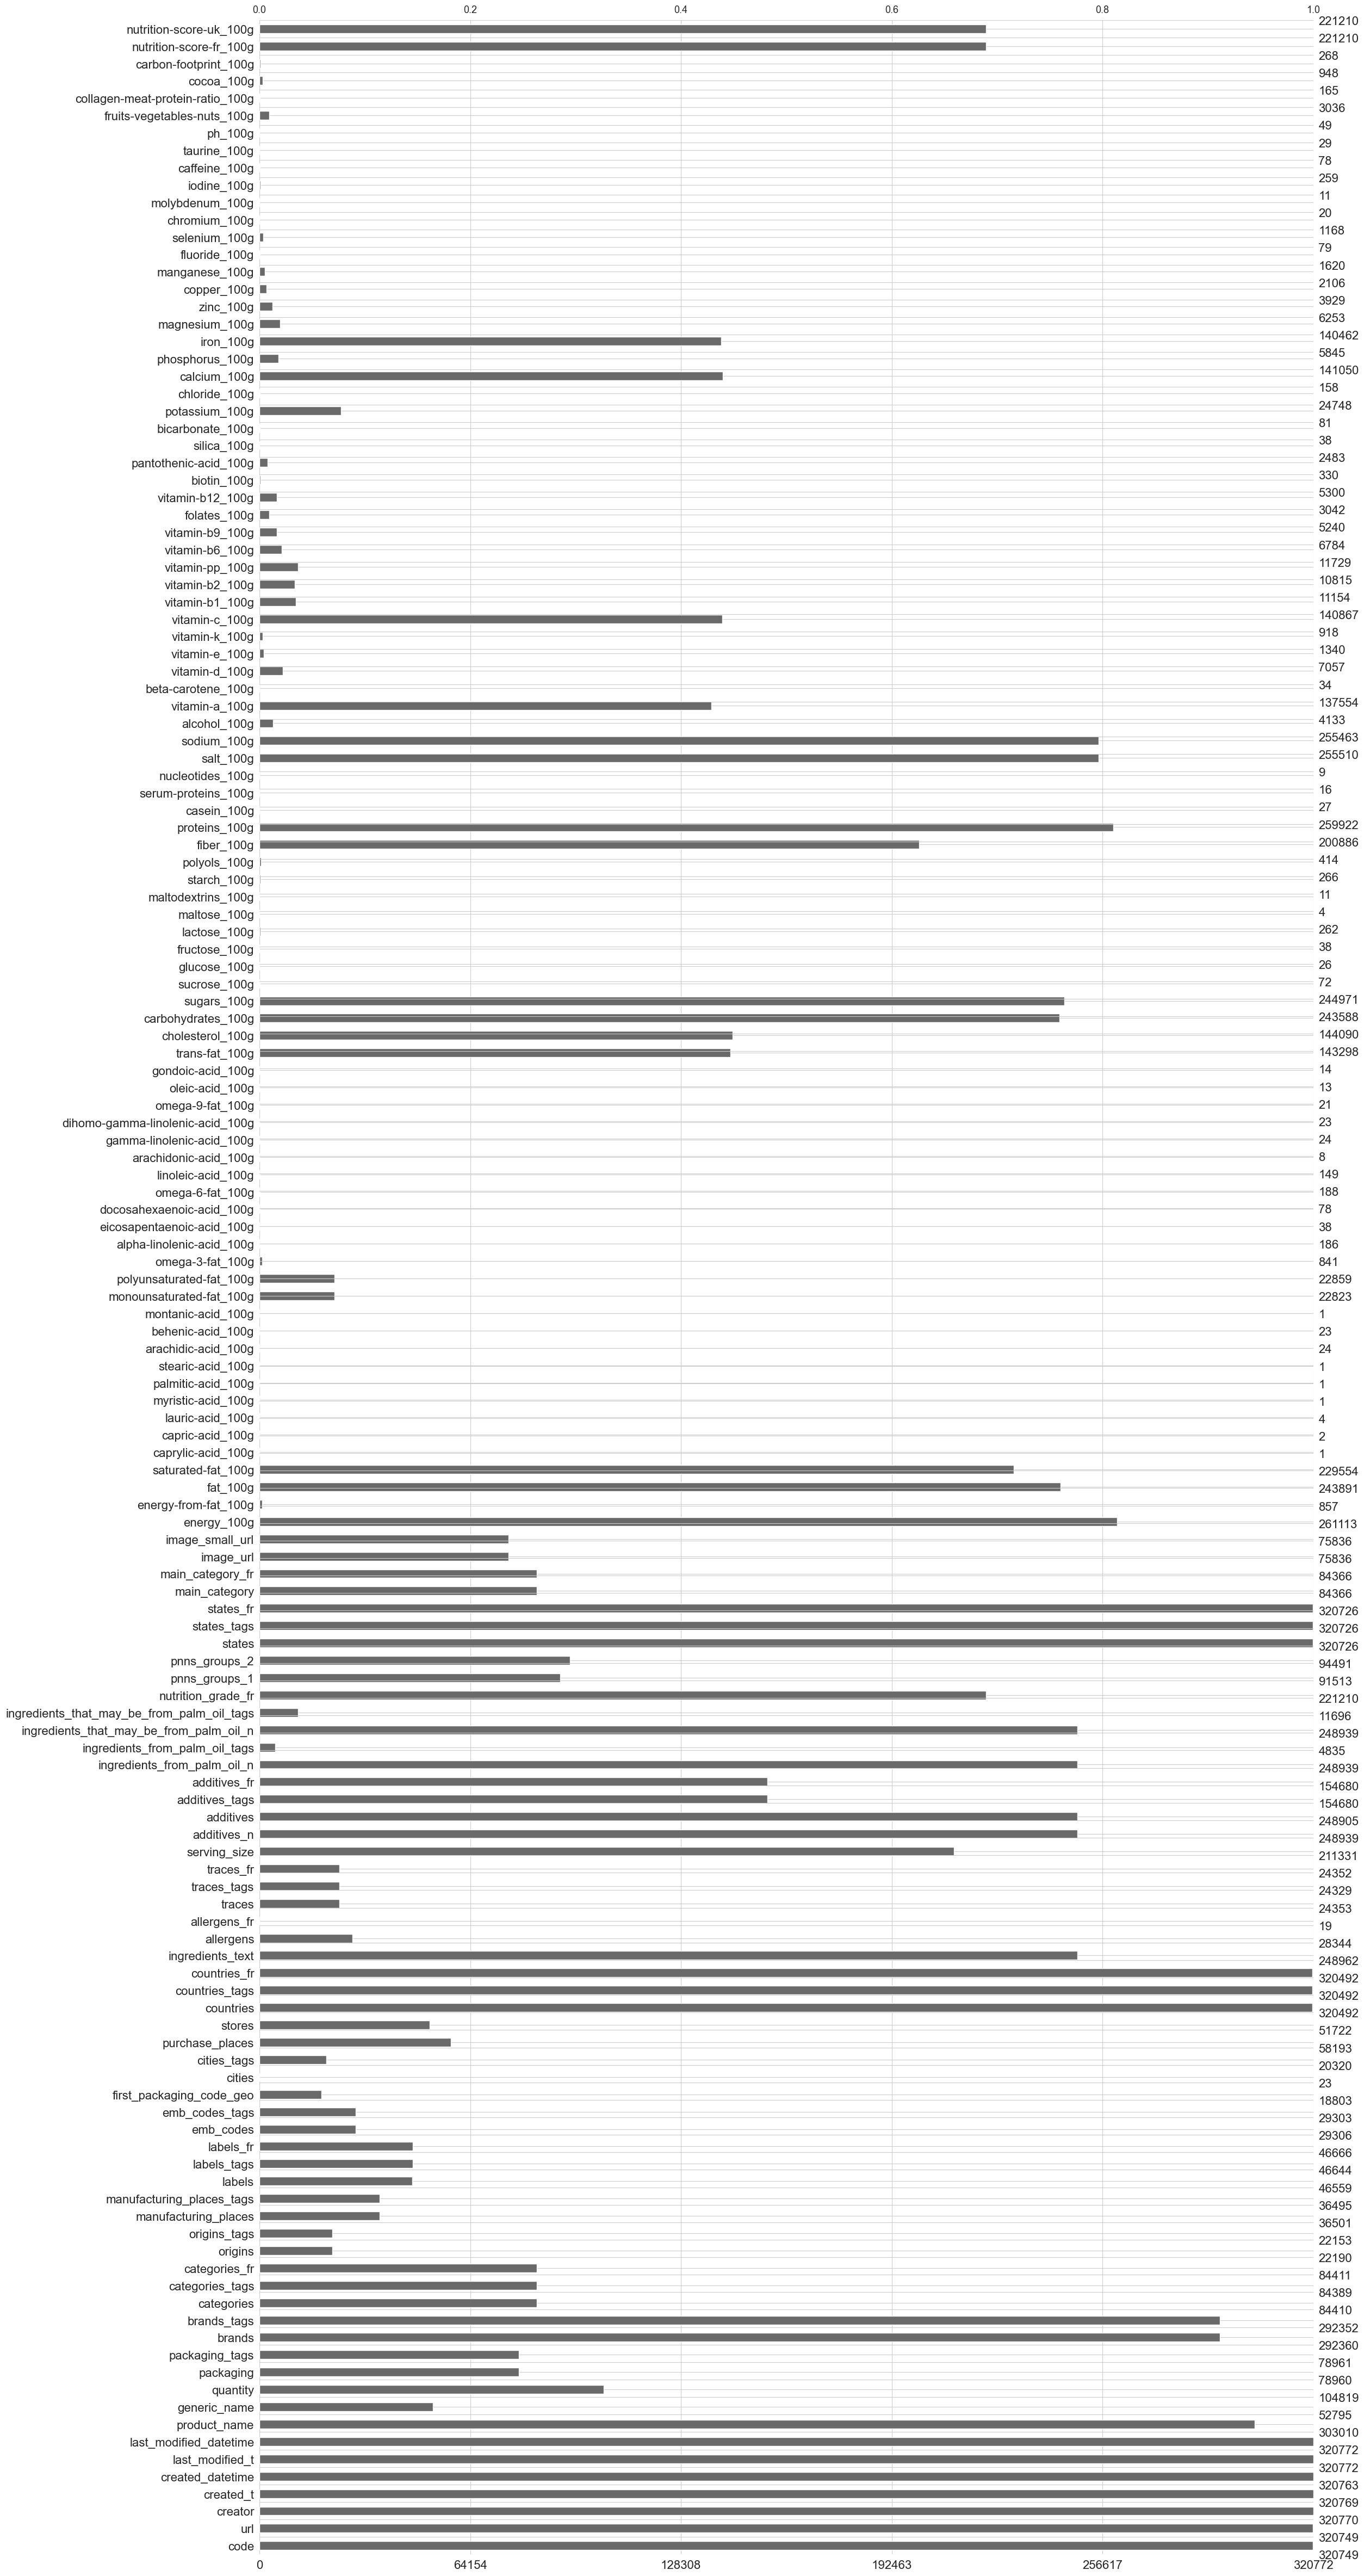

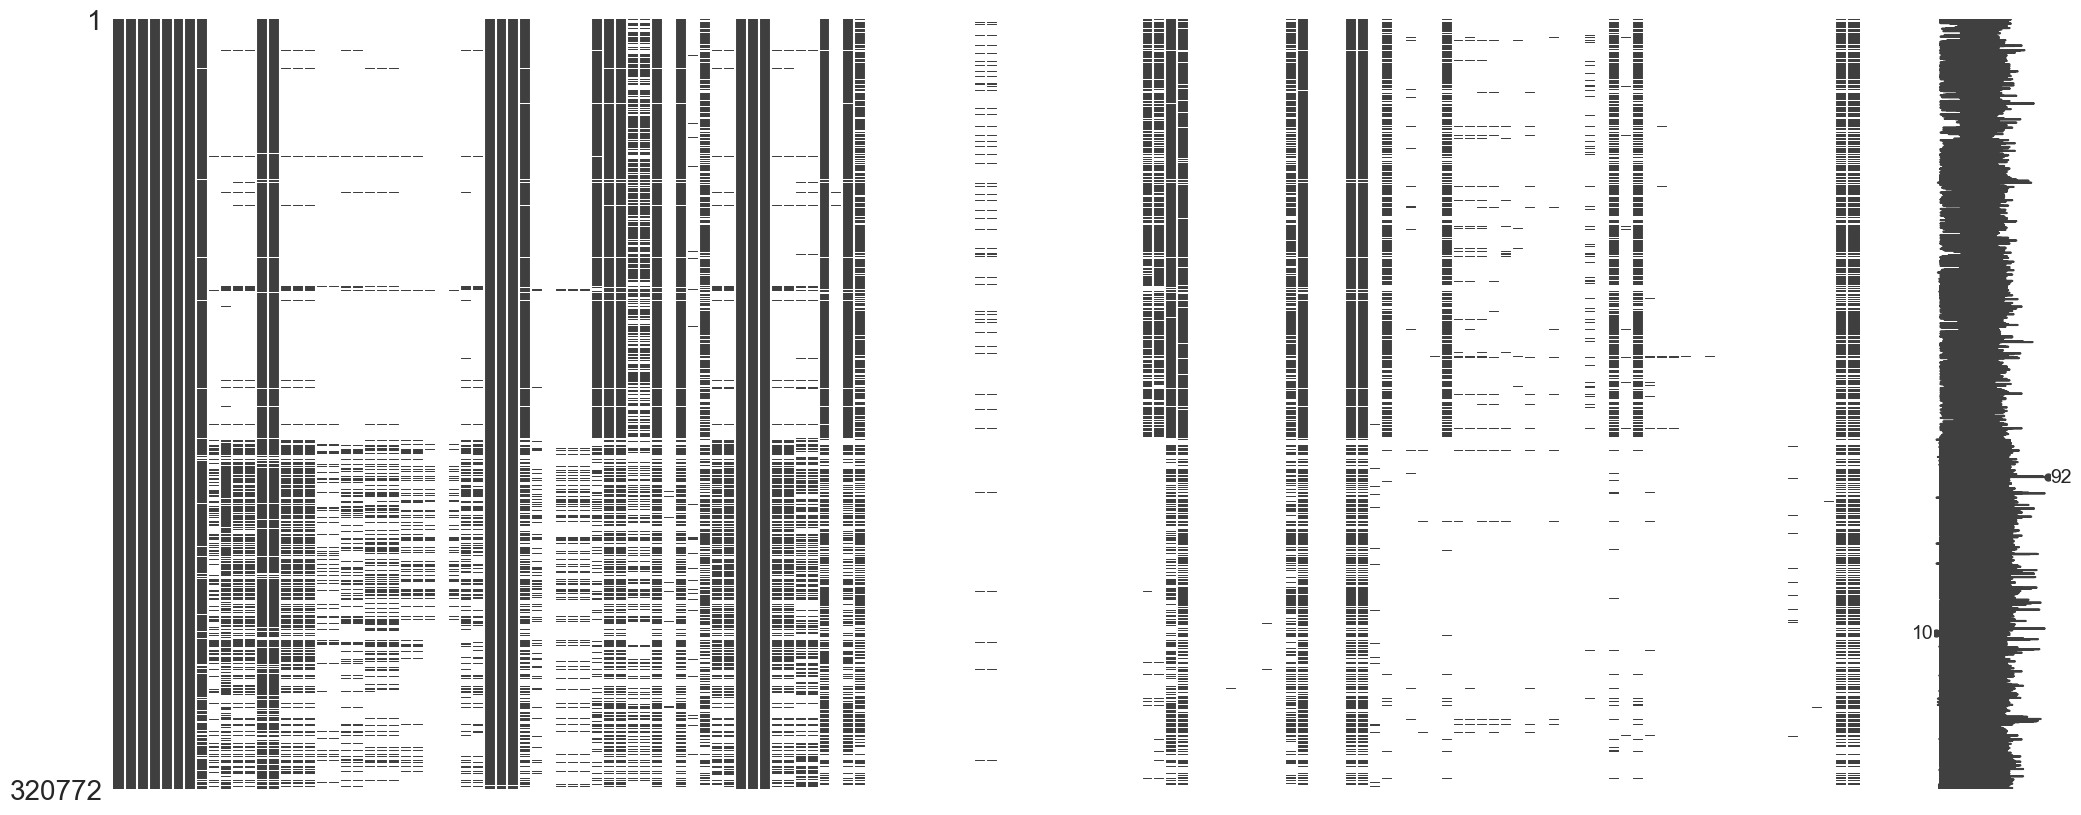

In [27]:
# Inspection du data frame
inspection(foodfacts_df, "Open food facts - Products")

In [28]:
# Réinitialiser l'option pour revenir aux paramètres par défaut
pd.reset_option('display.max_rows')

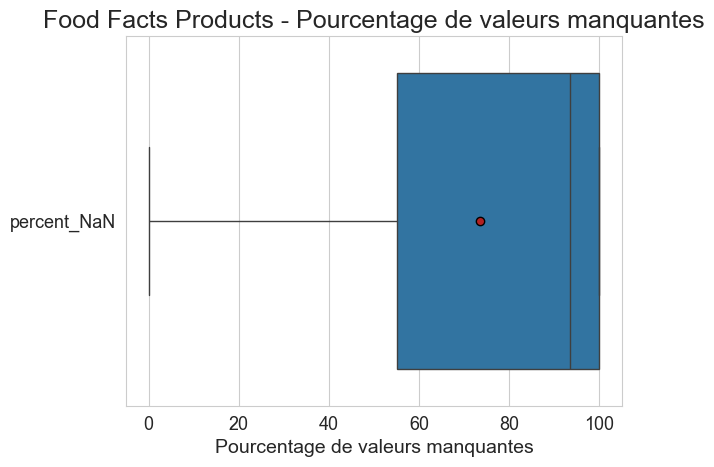

percent_NaN
count   146.000000
mean     73.615718
std      35.454187
min       0.000000
25%      55.141970
50%      93.379566
75%      99.952848
max      99.999688

In [29]:
# distribution des valeurs manquantes
percent_na = pd.DataFrame(foodfacts_df.isna().mean()*100, columns = ['percent_NaN'] )
sns.boxplot(data=percent_na, 
            orient='h', 
            showmeans=True, 
            meanprops=meanprops)
plt.title("Food Facts Products - Pourcentage de valeurs manquantes")
plt.xlabel('Pourcentage de valeurs manquantes')
plt.show()
display(percent_na.describe())

In [30]:
# La clé 'code' doit être unique
print('Il y a ', foodfacts_df.loc[foodfacts_df['code'].duplicated(keep=False)].shape[0],' doublons pour "code".')
print("")
display(foodfacts_df.loc[foodfacts_df['code'].duplicated(keep=False)])

Il y a  23  doublons pour "code".



code  url                                            creator  \
189068  NaN  NaN                  villecomtal-sur-arros-gers-france   
189103  NaN  NaN  villecomtal-sur-arros-gers-france,saint-just-c...   
189109  NaN  NaN                  villecomtal-sur-arros-gers-france   
189119  NaN  NaN                  villecomtal-sur-arros-gers-france   
189152  NaN  NaN                  villecomtal-sur-arros-gers-france   
189160  NaN  NaN                  villecomtal-sur-arros-gers-france   
189162  NaN  NaN                  villecomtal-sur-arros-gers-france   
189168  NaN  NaN                  villecomtal-sur-arros-gers-france   
189242  NaN  NaN                  villecomtal-sur-arros-gers-france   
189244  NaN  NaN                  villecomtal-sur-arros-gers-france   
189248  NaN  NaN                  villecomtal-sur-arros-gers-france   
189250  NaN  NaN                  villecomtal-sur-arros-gers-france   
189260  NaN  NaN                  villecomtal-sur-arros-gers-france   
189262  NaN  NaN                  villecomtal-sur-arros-gers-france   
189269  NaN  NaN                  villecomtal-sur-arros-gers-france   
189272  NaN  NaN                  villecomtal-sur-arros-gers-france   
189345  NaN  NaN  villecomtal-sur-arros-gers-france,saint-just-c...   
189362  NaN  NaN                  villecomtal-sur-arros-gers-france   
189364  NaN  NaN                  villecomtal-sur-arros-gers-france   
189379  NaN  NaN                  villecomtal-sur-arros-gers-france   
189404  NaN  NaN                  villecomtal-sur-arros-gers-france   
189406  NaN  NaN                  villecomtal-sur-arros-gers-france   
189417  NaN  NaN                  villecomtal-sur-arros-gers-france   

                                    created_t           created_datetime  \
189068                                 France                        NaN   
189103       Villecresnes,Villeurbanne,France                Dia,Sogeres   
189109                                 France                        NaN   
189119                          Veynes,France                     SuperU   
189152                        Torcy 77,France                  Carrefour   
189160                                 France                        NaN   
189162                    Saint-Priest,France                     Auchan   
189168                                    NaN                        NaN   
189242            Villers Bocage 80260,France           Carrefour market   
189244            Villers Bocage 80260,France           Carrefour market   
189248                                    NaN                        NaN   
189250                          Veynes,France             SuperU,Leclerc   
189260                            Montgermont                       Spar   
189262            Villers Bocage 80260,France         Banque alimentaire   
189269                                 France                    Leclerc   
189272                    Marseille 5°,France             Auchan,Super U   
189345                France,Nantes,Carquefou  Super U,Leclerc,Carrefour   
189362                                 France                        NaN   
189364                      Courrières,France                       Cora   
189379                                    NaN                        NaN   
189404  Brétigny-sur-Orge,Marseille 5°,France             Auchan,Super U   
189406                    Marseille 5°,France                    Super U   
189417                                 France                        NaN   

                        last_modified_t               last_modified_datetime  \
189068                  Belgique,France                 en:belgium,en:france   
189103                           France                            en:france   
189109  Belgique,France, en:switzerland  en:belgium,en:france,en:switzerland   
189119                           France                            en:france   
189152                           France                            en:france 

## <font color='#46abe6'>1.4. Description du jeu de données<a class="anchor" id="1_4"></a></font>
**Dimensions**: 320772 lignes, 162 colonnes


**Données**:
- `code` est la clé primaire : il s'agit du code de barre du produit.
- `created_t`, `created_datetime` : date de création de la ligne
- `last_modified_t`, `last_modified_datetime` : date de la dernière modification de la ligne
- `product_name` et `brands` : nom du produit et marque
- Informations nutritionnelles pour une portion de 100g de produit. 
    - `energy_100g`: énergie exprimée en kJ
    - Matières grasses, Glucides, Protéines : exprimés en g
    - Vitamines et mineraux pour 100g : exprimés en mg ou µg
    - `fruits-vegetables-nuts_100g` : % de fruits, légumes, noix
    - `alcohol_100g`: % d'alcool
    - Nota : La somme des composants doit être <= 100g.
- `main_category` et `main_category_fr`: catégories de produits
- `pnns_groups_1` et `pnns_groups_2` : familles de produits définies dans le Programme National Nutrition Santé (PNNS)
- `nutrition_grade_uk` et `nutrition_grade_fr`: alphabetique [A, E]
- `nutrition_score_uk` et `nutrition_score_fr`: numérique [-15, 40]

**Type**:
- à changer en format date : `created_t`, `created_datetime`, `last_modified_t`, `last_modified_datetime`
- à changer en string : `nutrition_grade_uk`


**Valeurs manquantes**: 
- 16 colonnes entièrement vides
- Beaucoup de valeurs manquantes : 75% des colonnes avec plus de 50% de valeurs manquantes 
- `code` : 23 codes barres de produit ne sont pas renseignés

**Valeurs aberrantes**:
- Les valeurs des proportions des composants ('_100g') doivent être comprises dans [0, 100] pour celles exprimées en g.
- Nous observons des valeurs qui semblent aberrantes : négatives ou supérieures à 100g.

**Doublons**:
- Il n'y a pas de doublons présents pour les codes barres dans la base de données. Cependant, ce cas pourrait se présenter.

## <font color='#46abe6'>1.5. Données nutritionnelles<a class="anchor" id="1_5"></a></font>
### a. Lien entre les données nutritionnelles

Il existe des liens entre les variables nutritionnelles [Source : Déclaration nutritionnelle sur les denrées alimentaires](https://www.economie.gouv.fr/dgccrf/Publications/Vie-pratique/Fiches-pratiques/declaration-nutritionnelle-sur-denrees-alimentaires)

`salt_100g` + `fat_100g` + `carbohydrates_100g` + `proteins_100g` <= 100g

#### Relations principales

<font color='#46abe6'>***Sel et sodium***:</font>  `salt_100g` = `sodium_100g` × 2,5

<font color='#46abe6'>***Matières grasses***:</font>  `fat_100g` = `saturated-fat__100g` + `monounsaturated-fat_100g` + `polyunsaturated-fat_100g` + `trans-fat_100g`

<font color='#46abe6'>'***Glucides***:</font> `carbohydrates_100g` = `sugars_100g` + `starch_100g` + `polyols_100g` + `fiber_100g`

<font color='#46abe6'>***Protéines***:</font> `proteins_100g` = `casein_100g` + `serum-proteins_100g` + `nucleotides_100g`

#### Autre relations 
<font color='#46abe6'>***Matières grasses saturées***:</font>`saturated-fat__100g` = `butyric-acid_100g` + `caproic-acid_100g` + `caprylic-acid_100g` + `capric-acid_100g` + `lauric-acid_100g` + `myristic-acid_100g` + `palmitic-acid_100g` + `stearic-acid_100g` + `arachidic-acid_100g` + `behenic-acid_100g` + `lignoceric-acid_100g` + `cerotic-acid_100g` + `montanic-acid_100g` + `melissic-acid_100g`

<font color='#46abe6'>***Matières grasses insaturées***:</font>`monounsaturated-fat_100g` = `oleic-acid_100g` + `elaidic-acid_100g` + `gondoic-acid_100g` + `mead-acid_100g` + `erucic-acid_100g` + `nervonic-acid_100g`

<font color='#46abe6'>***Matières grasses polyinsaturées***:</font>`polyunsaturated-fat_100g` = `omega-3-fat_100g` + `omega-6-fat_100g`
- *Omega 3* : `omega-3-fat_100g` = `alpha-linolenic-acid_100g` + `eicosapentaenoic-acid_100g` + `docosahexaenoic-acid_100g`
- *Omega 6* : `omega-6-fat_100g` = `linoleic-acid_100g` + `arachidonic-acid_100g` + `gamma-linolenic-acid_100g` + `dihomo-gamma-linolenic-acid_100g`
       
<font color='#46abe6'>***Sucres***:</font> `sugars_100g` = `sucrose_100g` + `glucose_100g` + `fructose_100g` + `lactose_100g` + `maltose_100g` + `maltodextrins_100g`




### b. Nutriscore

Sources : 
- [Informations sur le nutriscore](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en)
- [FAQ scientifique et technique Nutri-Score](https://fr.openfoodfacts.org/nutriscore#:~:text=FAQ%20scientifique%20et%20technique%20Nutri%2DScore)

Nutriscore est fonction des variables suivantes : 
- energy_100g
- saturated-fat_100g
- sugars_100g
- salt_100g
- proteins_100g
- fibers_100g
- fruits-vegetables-nuts_100g

Le schéma ci-dessous illustre la méthode de calcul de nutriscore et la correspondance avec le nutrigrade.

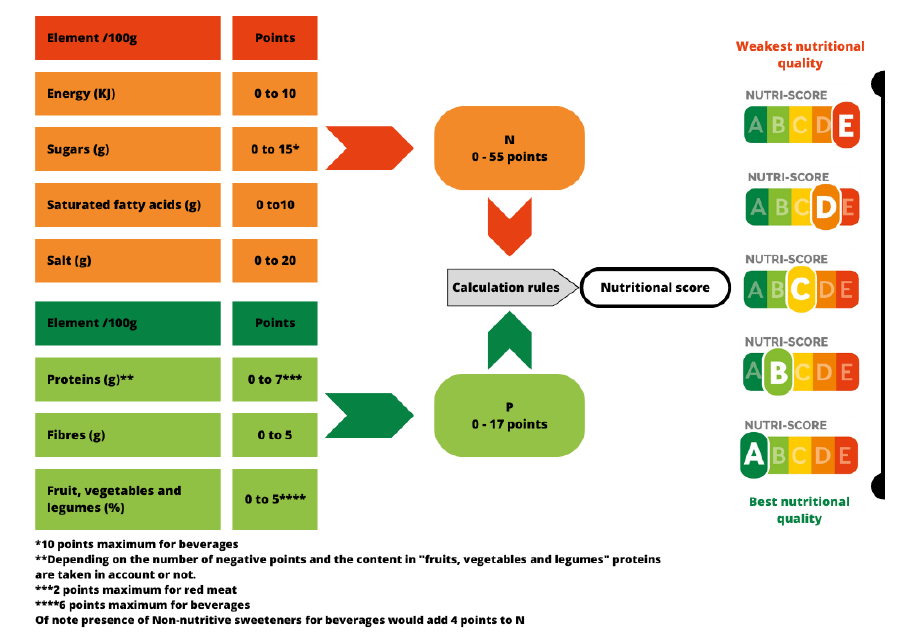

### c. Exemples d'application de la base de données

> La nutrition (alimentation et activité physique) est un déterminant majeur de la santé et notamment des pathologies chroniques qui constituent, aujourd’hui, les enjeux majeurs de santé publique auxquels est confrontée la France, comme de
nombreux pays dans le monde. (...)
En France, les maladies chroniques dans lesquelles les facteurs nutritionnels sont impliqués constituent des enjeux majeurs de santé publique:
>* 365 500 nouveaux cas de cancers en 2011 (...),
>* les maladies cardiovasculaires (MCV), 2ème cause de mortalité (DREES, 2011), sont à l’origine de près de 180 000 décès par an (32 % des décès) (...), 
>* la prévalence du diabète traité pharmacologiquement est estimée (...) à 2,5 millions de personnes

*Source : Pr Serge Hercberg - Propositions pour un nouvel élan de la politique nutritionnelle française de santé publique*

La base de données pourrait être utilisée pour aider le consommateur à mieux s'alimenter en proposant des alternatives d'aliments en fonction des critères suivants :
* <font color='#46abe6'>Réduire la teneur en sel:</font>
    - La baisse de la consommation de sel réduit le risque à long terme d’événements cardiovasculaires et d’accidents vasculaires cérébraux.
* <font color='#46abe6'>Augmenter la teneur en fibres :</font> 
    - Les fibres ont des effets protecteurs sur la santé, en termes de maladies cardiovasculaires, réduction de la mortalité cardiovasculaire, et de diabète de type II,réduction de risque de diabète de type II chez des femmes.
* <font color='#46abe6'>Réduire la teneur en sucre :</font>
    - Diabète : 
    - proposer des aliments équivalents avec moins de sucres
* <font color='#46abe6'>Réduire les matières grasses saturées (beurre, crème, huile de palme):</font>
    - Les acides gras saturés élèvent le taux de cholestérol LDL, celui qui risque, à terme, de s’accumuler sur les parois des artères. 
* <font color='#46abe6'>Augmenter les acides gras insaturés nécessaires à notre métabolisme, que le corps ne sait pas synthétiser:</font> 
    - l’acide linoléique (huiles de tournesol et de maïs), l’acide alpha linolénique (huiles de colza et de lin) et le DHA (acide docosahexaénoïque, présent dans le poisson).
    
Sources :
* [Santé Figaro : sept-conseils-pour-decrypter-etiquettes-nutritionnelles](https://sante.lefigaro.fr/actualite/2016/09/23/25432-sept-conseils-pour-decrypter-etiquettes-nutritionnelles)
* [Rapport : Propositions pour un nouvel élan de la politique nutritionnelle française de santé publique](https://sante.gouv.fr/IMG/pdf/rapport_Hercberg_15_11_2013.pdf)

# <font color='#0a389f'>Partie 2 - Nettoyage des données<a class="anchor" id="partie2"></a></font>

In [31]:
# Initialisation du dataframe change_log_df
change_log_df = pd.DataFrame({'nb_rows': [foodfacts_df.shape[0]],
                              'nb_columns': [foodfacts_df.shape[1]],
                              'change_type': ['Etat initial'],
                              'on': ['-'],
                              'description': ['Etat initial du dataframe'],
                              })

## <font color='#46abe6'>2.1. Filtrage des données<a class="anchor" id="2_1"></a></font>

### a. `countries_fr` : Application destinée à la France 

L'application est destinée à la France : le premier filtre que nous appliquons est sur les produits vendus en France et DOM/TOM.

In [32]:
#Extrait de la colonne 'countries_fr'
foodfacts_df['countries_fr'].unique()[:20]

array(['France', 'États-Unis', 'Royaume-Uni', 'France,États-Unis',
       'Canada', 'Suisse', 'Espagne', 'Allemagne', 'Slovénie', 'Italie',
       'Roumanie', 'Australie', 'Portugal', 'France,Royaume-Uni',
       'Belgique,France,Pays-Bas,Royaume-Uni', 'Guadeloupe', nan,
       'Royaume-Uni,États-Unis', 'Canada,États-Unis', 'Pays-Bas'],
      dtype=object)

In [33]:
#Sélection des pays de ventes en France et DOM/TOM
pays = ['France', 'Guadeloupe', 'La Réunion', 'Mayotte', 'Martinique', 'Guyane']

# création d'un pattern avec les noms des pays de la liste 'pays', condition : ou
pattern = '|'.join(map(re.escape, pays))

# filtre sur les lignes contenant un des pays de la liste pays (ignore le NaN et les majuscules)
frfoodfacts_df = foodfacts_df.loc[foodfacts_df['countries_fr'].str.contains(pattern, case=False, na=False)]

# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Filtre', 
            'countries_fr =='+str(pays), 
            "Filtre sur les produits vendus en France et DOM/TOM"] 
           )

### b. `main_category_fr` : Filtre des données hors catégorie 'Non alimentaire'

`main_category_fr` a une categorie 'Non alimentaire' : supprimons les produits appartenant à cette catégorie.

In [34]:
# Liste des modalités de 'main_category_fr' contenant 'non alimentaire'
alim_filter = frfoodfacts_df.main_category_fr.str.contains('non[ -]?alimentaire', case=False, na=False, regex=True)
non_alim = list(frfoodfacts_df[alim_filter]['main_category_fr'].unique())
display(non_alim)

['Non alimentaire']

In [35]:
# Suppression des données de la catégorie 'Non alimentaire'
frfoodfacts_df = frfoodfacts_df[~frfoodfacts_df.main_category_fr.isin(non_alim)]

# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Filtre', 
            'main_category_fr', 
            "Filtre sur les données n'appartenant pas à la catégorie 'Non alimentaire'"] 
           )

### c. Sélection des variables pertinentes

Pour la suite de l'analyse, nous conservons uniquement les colonnes suivantes:

In [36]:
# Liste des variables pertinentes
selection = [
 'code',
 'created_datetime',
 'last_modified_datetime',
 'product_name',
 'brands',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category_fr',  
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'trans-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'alcohol_100g',  
 'fruits-vegetables-nuts_100g',
 'nutrition-score-fr_100g',
 'nutrition_grade_fr'
]

# Filtre sur les variables pertinentes
frfoodfacts_df = frfoodfacts_df[selection]

# Ajoute la modifications au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Filtre', selection, "Sélection des variables pertinentes" ] )

### d. Suppression des lignes sans données pour les catégories de produit et les valeurs nutritionnelles

Pour l'analyse, nous supprimons les lignes qui n'ont pas de données de catégories et les informations nutritionnelles.

In [37]:
# Suppression des ligne vides = sans données pour les catégories de produit et les valeurs nutritionnelles
required = [ 'pnns_groups_1', 
             'pnns_groups_2',
             'main_category_fr',
             'energy_100g',
             'nutrition-score-fr_100g',
             'fat_100g',
             'saturated-fat_100g',
             'monounsaturated-fat_100g',
             'polyunsaturated-fat_100g',
             'trans-fat_100g',
             'carbohydrates_100g',
             'sugars_100g',
             'starch_100g',
             'polyols_100g',
             'fiber_100g',
             'proteins_100g',
             'salt_100g',
             'sodium_100g',
             'fruits-vegetables-nuts_100g',
             'alcohol_100g']

# Drop les lignes sans données aucune des catégories de produit
frfoodfacts_df.dropna(subset=required, how='all', inplace=True)

# Ajoute la modifications au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Suppression', 
            required, 
            "Suppression des lignes sans données pour les catégories de"\
            "produit et les valeurs nutritionnelles: "+str(required)] 
           )

## <font color='#46abe6'>2.2. Types de variables<a class="anchor" id="2_2"></a></font>

L'objectif est ici de corriger les types de varaiables incorrects.

In [38]:
# Modifications du format des variables dates
# Liste des colonnes de dates à traiter
format_date = ['created_datetime', 'last_modified_datetime']

# Convertir les colonnes de dates
convert_date_columns(frfoodfacts_df, format_date, change_log_df)

created_datetime : datetime64[ns, UTC]
last_modified_datetime : datetime64[ns, UTC]


## <font color='#46abe6'>2.3. Doublons `code`<a class="anchor" id="2_3"></a></font>
Supprimons les lignes sans code barre identifiées lors de l'inspection et traitons les éventuels doublons de codes : les lignes modifiées le plus récemment et avec le moins de valeurs manquantes seront conservées.

In [39]:
frfoodfacts_df = choose_duplicates(frfoodfacts_df, 'code', 'last_modified_datetime', change_log_df)

## <font color='#46abe6'>2.4. Homogénéisation des noms des modalités `pnns_groups_1`, `pnns_groups_2` et `main_category_fr`<a class="anchor" id="2_4"></a></font>

Les `pnns_groups_1`, `pnns_groups_2` et `main_category_fr` seront très utiles pour l'analyse et les futures applications de la base de données.

[Source : anses](https://www.anses.fr/fr/system/files/NUT2012SA0103Ra-1.pdf)

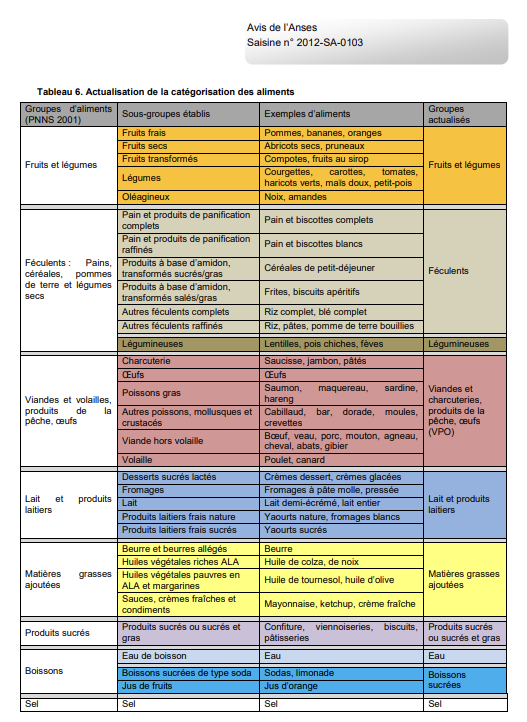

Nous observons des écritures différentes pour un même groupe  et un groupe de produits 'unknown'.
- homogénéiser l'écriture des modalités
- remplacer 'unknown' par 'NaN'

In [40]:
# Intitulés des groupes 'pnns_groups_1', 'pnns_groups_2', 'main_category_fr'
display(frfoodfacts_df['pnns_groups_1'].unique())
display(frfoodfacts_df['pnns_groups_2'].unique())
display(frfoodfacts_df['main_category_fr'].unique())

array(['Sugary snacks', 'unknown', 'Milk and dairy products',
       'Salty snacks', 'Cereals and potatoes', nan, 'Composite foods',
       'Beverages', 'Fish Meat Eggs', 'Fat and sauces',
       'fruits-and-vegetables', 'Fruits and vegetables', 'sugary-snacks',
       'cereals-and-potatoes'], dtype=object)

array(['Chocolate products', 'unknown', 'Ice cream', 'Appetizers',
       'Cereals', nan, 'Biscuits and cakes', 'Sweets', 'One-dish meals',
       'Sweetened beverages', 'Fish and seafood', 'Pizza pies and quiche',
       'Sandwich', 'Cheese', 'Dressings and sauces',
       'Non-sugared beverages', 'Bread', 'vegetables', 'Fruit juices',
       'Fruits', 'Dried fruits', 'Fruit nectars', 'Legumes',
       'Milk and yogurt', 'Vegetables', 'Fats',
       'Artificially sweetened beverages', 'Processed meat',
       'Breakfast cereals', 'Meat', 'Nuts', 'Alcoholic beverages',
       'pastries', 'Potatoes', 'Soups', 'Dairy desserts', 'Eggs',
       'Tripe dishes', 'Salty and fatty products', 'fruits', 'cereals',
       'legumes'], dtype=object)

array(['Chocolats', nan, 'Édulcorants', ..., 'Echine-de-porc-assaisonnee',
       'Conserve-de-legumes-cuisines', 'pl:Odwodnione-zupa'], dtype=object)

In [41]:
# Ecriture des modalités en minuscules et séparation par un '-'
categ_groups = ['pnns_groups_1', 'pnns_groups_2', 'main_category_fr']

frfoodfacts_df = correct_categ(frfoodfacts_df, categ_groups, change_log_df)

In [42]:
# Groupes et sous-groupes PNNS
pd.DataFrame(frfoodfacts_df.groupby(['pnns_groups_1', 'pnns_groups_2'])['code'].count())

code
pnns_groups_1           pnns_groups_2                         
beverages               artificially-sweetened-beverages   211
                        fruit-juices                      1537
                        fruit-nectars                      313
                        non-sugared-beverages             2898
                        sweetened-beverages               1681
cereals-and-potatoes    bread                             1324
                        breakfast-cereals                 1111
                        cereals                           3053
                        legumes                            550
                        potatoes                           105
composite-foods         one-dish-meals                    4948
                        pizza-pies-and-quiche              459
                        sandwich                           644
fat-and-sauces          dressings-and-sauces              2611
                        fats                              1185
fish-meat-eggs          eggs                               325
                        fish-and-seafood                  2195
                        meat                              1357
                        processed-meat                    2908
fruits-and-vegetables   dried-fruits                       378
                        fruits                            1531
                        soups                              427
                        vegetables                        2296
milk-and-dairy-products cheese                            3034
                        dairy-desserts                     749
                        ice-cream                          592
                        milk-and-yogurt                   2074
salty-snacks            appetizers                        1628
                        nuts                               480
                        salty-and-fatty-products            15
sugary-snacks           biscuits-and-cakes                3772
                        chocolate-products                2218
                        pastries                           472
                        sweets                            3442

2 sous-groupes pnns non attribués à un groupe

In [43]:
# Groupes et sous-groupes PNNS
pd.DataFrame(frfoodfacts_df[frfoodfacts_df['pnns_groups_1'].isna()].groupby('pnns_groups_2')['code'].count())

code
pnns_groups_2            
alcoholic-beverages  2098
tripe-dishes           65

## <font color='#46abe6'>2.5. Identification et traitement des valeurs aberrantes<a class="anchor" id="2_5"></a></font>

Pour les valeurs aberrantes, nous regardons dans un premier temps les variables quantitatives. 

In [44]:
# Variables quantitatives à étudier
nutri_facts_100g = ['fat_100g',
'saturated-fat_100g',
'monounsaturated-fat_100g',
'polyunsaturated-fat_100g',
'trans-fat_100g',
'carbohydrates_100g',
'sugars_100g',
'starch_100g',
'polyols_100g',
'fiber_100g',
'proteins_100g',
'salt_100g',
'sodium_100g',
'fruits-vegetables-nuts_100g',
'alcohol_100g']

nutri_facts_other = ['energy_100g', 'nutrition-score-fr_100g']
nutri_facts =  nutri_facts_other + nutri_facts_100g

In [45]:
# Initiation de la liste des outliers
outliers_list = []

### a. Description des données

Nous pouvons observer des valeurs qui semblent aberrantes : 
- `energy_100g` : valeur max en $10^6$, exprimée en J et non en kJ.
- autres valeur _100g > 100
- `sugars_100g` : valeur négative

In [46]:
round(frfoodfacts_df[nutri_facts].describe(),2)

energy_100g  nutrition-score-fr_100g  fat_100g  saturated-fat_100g  \
count     64683.00                 61482.00  47735.00            62444.00   
mean       1170.88                     8.68     13.32                5.42   
std       12827.01                     9.05     16.92                8.53   
min           0.00                   -15.00      0.00                0.00   
25%         427.00                     1.00      1.30                0.30   
50%        1034.00                     9.00      6.80                2.00   
75%        1649.00                    15.00     21.00                7.40   
max     3251373.00                    40.00    380.00              210.00   

       monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count                   1189.00                   1208.00          386.00   
mean                      18.56                      9.83            0.21   
std                       21.95                     15.02            0.98   
min                        0.00                      0.00            0.00   
25%                        2.60                      1.50            0.00   
50%                        9.10                      3.50            0.00   
75%                       26.00                     11.00            0.12   
max                       82.00                     75.00           17.20   

       carbohydrates_100g  sugars_100g  starch_100g  polyols_100g  fiber_100g  \
count            47302.00     62589.00       173.00        304.00    45768.00   
mean                27.75        13.43        37.52         50.54        2.56   
std                 27.41        19.08        24.02         33.57        4.61   
min                  0.00        -0.10         0.00          0.00        0.00   
25%                  4.10         1.00        15.00         17.88        0.00   
50%                 14.50         4.10        39.00         59.90        1.35   
75%                 53.00        17.80        60.00         71.00        3.20   
max                190.00       105.00        77.00        100.00      178.00   

       proteins_100g  salt_100g  sodium_100g  fruits-vegetables-nuts_100g  \
count       64408.00   62645.00     62642.00                      2969.00   
mean            7.75       1.16         0.46                        31.57   
std             7.87       4.31         1.70                        32.06   
min             0.00       0.00         0.00                         0.00   
25%             1.80       0.08         0.03                         0.00   
50%             6.00       0.56         0.22                        24.00   
75%            10.90       1.24         0.49                        51.00   
max           100.00     211.00        83.00                       100.00   

       alcohol_100g  
count       2428.00  
mean           9.13  
std           10.62  
min            0.00  
25%            1.00  
50%            6.00  
75%           12.50  
max           69.00

### b. Identification des outliers avec la méthode du z-score

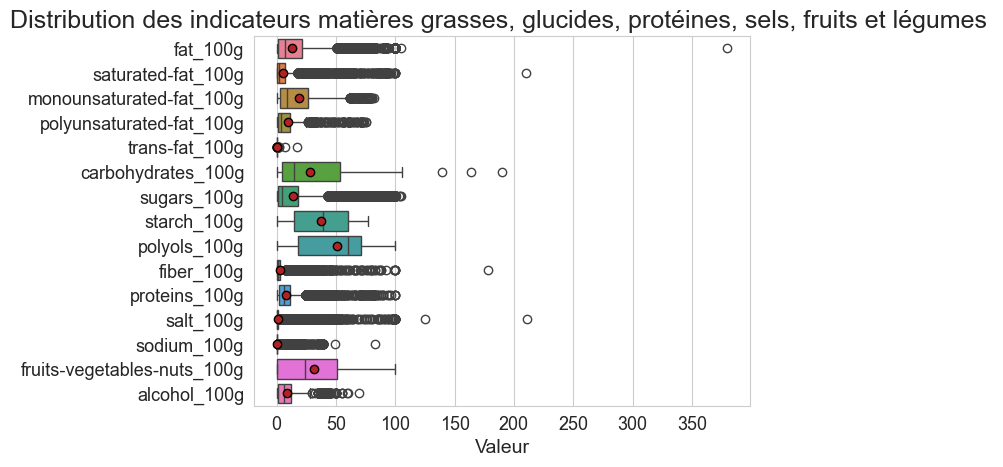

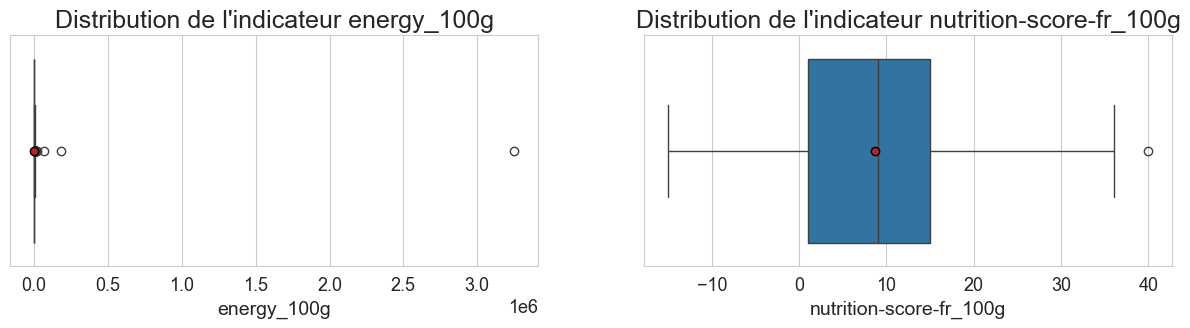

In [47]:
# Distribution des données 
sns.boxplot(data=frfoodfacts_df[nutri_facts_100g],
                orient='h', 
                showmeans=True, 
                meanprops=meanprops)
plt.title("Distribution des indicateurs matières grasses, glucides, protéines, sels, fruits et légumes ")
plt.xlabel('Valeur')
plt.show()


fig, ax = plt.subplots(1, 2, figsize = (15, 3))
for i, col in enumerate(nutri_facts_other):
    sns.boxplot(data=frfoodfacts_df,
                    x=col,
                    orient='h', 
                    showmeans=True, 
                    meanprops=meanprops,
                    ax = ax[i])
    ax[i].set_title(f"Distribution de l'indicateur {col}")
    ax[i].set_xlabel(col)
plt.show()

In [48]:
# Liste des variables à inclure dans l'affichage des outliers
res_var=['code',
         'product_name',
         'brands',
         'main_category_fr',
         'pnns_groups_1',
         'pnns_groups_2']

# Représentation de la distribution, boxplots, et liste des outliers identifiés avec la méthode du Z-score
print_outlier(frfoodfacts_df, nutri_facts, res_var)


energy_100g : Nombre d'outliers détectés => 3


code                                       product_name  \
3839   3257983143096                                        Pois cassés   
15443  3661405001053  Légume Noisettes Carottes, 500 Grammes, Marque...   
22908  3270160689774                                                NaN   

       brands main_category_fr pnns_groups_1 pnns_groups_2  energy_100g  
3839     Cora      pois-casses           NaN           NaN    3251373.0  
15443    Iglo              NaN           NaN           NaN     182764.0  
22908  Picard              NaN           NaN           NaN      69292.0


nutrition-score-fr_100g : Nombre d'outliers détectés => 1141


code                                       product_name  \
42208       20009373                        Cappuccino allégé en sucre*   
30151  9421025231179  Capricare Lait De Chèvre 2 De 6 Mois à 1 an 400 G   
23565  3033710003020             Chocolat Noir Pâtissier Dessert Nestlé   
3333        54037120                                   Lapin  Petillant   
23019  3760077187673                            Bouchees Coco Choc Noir   
...              ...                                                ...   
80835  5411788045094                               Edamamé Beans Nature   
45961  3270160103713                                       Fèves pelées   
9216   3256223662106                               Lentilles corail bio   
53471  3222471016886                         Choux-fleurs en fleurettes   
51164  3380390204408                                       Pois chiches   

                  brands                         main_category_fr  \
42208           Bellarom                                 boissons   
30151          Capricare                                      NaN   
23565             Nestlé                                      NaN   
3333               Milka                                      NaN   
23019  Saveurs Et Nature                                      NaN   
...                  ...                                      ...   
80835               Lima  aliments-et-boissons-à-base-de-végétaux   
45961             Picard  aliments-et-boissons-à-base-de-végétaux   
9216             U Bio,U  aliments-et-boissons-à-base-de-végétaux   
53471             Casino                                 surgelés   
51164            Primeal  aliments-et-boissons-à-base-de-végétaux   

               pnns_groups_1          pnns_groups_2  nutrition-score-fr_100g  
42208              beverages  non-sugared-beverages                     40.0  
30151                    NaN                    NaN                     36.0  
23565                    NaN                    NaN                     36.0  
3333                     NaN                    NaN                     36.0  
23019                    NaN                    NaN                     36.0  
...                      ...                    ...                      ...  
80835  fruits-and-vegetables             vegetables                    -14.0  
45961  fruits-and-vegetables             vegetables                    -14.0  
9216   fruits-and-vegetables             vegetables                    -14.0  
53471  fruits-and-vegetables             vegetables                    -14.0  
51164  fruits-and-vegetables             vegetables                    -15.0  

[1141 rows x 7 columns]


fat_100g : Nombre d'outliers détectés => 2016


code                                product_name  \
5214   3596710288755  mini choux goût fromage de chèvre - poivre   
15435  8032942610032                    Graine de couscous moyen   
506    3291960011114                             Huile De Sésame   
70417  8414979991030       Huile d'olive Vierge Extra biologique   
46377  3265475194006                       ISio 4 Touche de noix   
...              ...                                         ...   
48949  4008400159027                            Ferrero Küsschen   
33618  3256224757528                   Cacahuètes Grillées à Sec   
76478  3271511000316                                      Pistou   
59604  3472710014481                    Truffes fantaisie nature   
9250   3472710023414                  Truffes Fantaisie - Nature   

                     brands                         main_category_fr  \
5214                 Auchan                             snacks-salés   
15435       La méditerranéa  aliments-et-boissons-à-base-de-végétaux   
506              Emile Noël                                   huiles   
70417               Echinac                           huiles-d'olive   
46377               Lesieur                                   huiles   
...                     ...                                      ...   
48949               Ferrero                                chocolats   
33618                     U                          fruits-à-coques   
76478           Jean Martin                                 epicerie   
59604               Chocmod                                chocolats   
9250   Truffettes de France                                chocolats   

              pnns_groups_1         pnns_groups_2  fat_100g  
5214           salty-snacks            appetizers     380.0  
15435  cereals-and-potatoes               cereals     105.0  
506          fat-and-sauces                  fats     100.0  
70417        fat-and-sauces                  fats     100.0  
46377        fat-and-sauces                  fats     100.0  
...                     ...                   ...       ...  
48949         sugary-snacks    chocolate-products      47.3  
33618          salty-snacks                  nuts      47.3  
76478        fat-and-sauces  dressings-and-sauces      47.2  
59604         sugary-snacks    chocolate-products      47.2  
9250          sugary-snacks    chocolate-products      47.2  

[2016 rows x 7 columns]


saturated-fat_100g : Nombre d'outliers détectés => 2052


code                                product_name  \
5214   3596710288755  mini choux goût fromage de chèvre - poivre   
63933  5158418187631                Végétaline (offre familiale)   
72375       26008028                                    Jog'Frit   
25393  6091035082004                                         Eau   
25848  3270190118800         Huile De Tournesol Végétale 2 Litre   
...              ...                                         ...   
43152  3023260028697            Roquefort AOP (part dégustation)   
59122  3396410221003                   Comté portion au lait cru   
43890  3263859380717             Roquefort au lait cru de brebis   
11541  3023260001263                           Roquefort société   
51627  3412290090390               La Brique Tradition (31 % MG)   

                    brands            main_category_fr  \
5214                Auchan                snacks-salés   
63933           Végétaline                      huiles   
72375             Jog'Frit  matières-grasses-végétales   
25393                Vital                         NaN   
25848            Carrefour                         NaN   
...                    ...                         ...   
43152              Société         produits-labellisés   
59122           Bonneterre         produits-labellisés   
43890      Marché Franprix                    fromages   
11541              Société                    fromages   
51627  Paysan Breton,Laita          fromages-de-france   

                 pnns_groups_1 pnns_groups_2  saturated-fat_100g  
5214              salty-snacks    appetizers               210.0  
63933           fat-and-sauces          fats               100.0  
72375           fat-and-sauces          fats               100.0  
25393                      NaN           NaN               100.0  
25848                      NaN           NaN               100.0  
...                        ...           ...                 ...  
43152  milk-and-dairy-products        cheese                22.5  
59122  milk-and-dairy-products        cheese                22.5  
43890  milk-and-dairy-products        cheese                22.5  
11541  milk-and-dairy-products        cheese                22.5  
51627  milk-and-dairy-products        cheese                22.5  

[2052 rows x 7 columns]


monounsaturated-fat_100g : Nombre d'outliers détectés => 114


code                                       product_name  \
55430  3596710364602  Huile d'olive vierge extra de Nyons AOP extrai...   
77606  3245270001242                           Huile vierge de Noisette   
77602  3245270000894                                  Huile de Noisette   
54179  3245270000504                                  Huile de noisette   
40640  3250391650132                 L'exceptionnelle huile de noisette   
...              ...                                                ...   
34739  3245270001341  Huile &quot;La Quotidienne&quot; à l'Huile de ...   
77445  3256221712254                                     huile de colza   
61767  3254563624860                                     Huile de colza   
53655  3445020123709                   Huile d'olive douce vierge extra   
12832  3445020120340                         Huile d'olive vierge extra   

                                           brands main_category_fr  \
55430                                       Mmm !   huiles-d'olive   
77606                        Huilerie Croix Verte           huiles   
77602                        Huilerie Croix Verte           huiles   
54179                              La Tourangelle           huiles   
40640       Bouton d'or,Les créations,Intermarché           huiles   
...                                           ...              ...   
34739  La Tourangelle,Huilerie Croix Verte S.A.S.           huiles   
77445                                           U           huiles   
61767                                      Auchan           huiles   
53655                                 Bio Planete   huiles-d'olive   
12832                                 Bio Planète   huiles-d'olive   

        pnns_groups_1 pnns_groups_2  monounsaturated-fat_100g  
55430  fat-and-sauces          fats                      82.0  
77606  fat-and-sauces          fats                      80.0  
77602  fat-and-sauces          fats                      80.0  
54179  fat-and-sauces          fats                      80.0  
40640  fat-and-sauces          fats                      79.2  
...               ...           ...                       ...  
34739  fat-and-sauces          fats                      63.0  
77445  fat-and-sauces          fats                      63.0  
61767  fat-and-sauces          fats                      63.0  
53655  fat-and-sauces          fats                      63.0  
12832  fat-and-sauces          fats                      63.0  

[114 rows x 7 columns]


polyunsaturated-fat_100g : Nombre d'outliers détectés => 74


code                                       product_name  \
6245   3452010001817                              Huilve vierge de noix   
51809  3452016210206                               Huile vierge de noix   
42853  3256222630083                       Huile de noix saveur grillée   
80459  3445020000734                              Huile de pavot vierge   
77610  3245270000993                                      Huile de noix   
...              ...                                                ...   
12010  3245411164973  Mélange de 4 huiles végétales Extraites à froi...   
61951  3175681845060                                  Lécithine de soja   
77605  3245270000900                             Huile vierge de Sésame   
34147  3023030710029                                   Huile de sésame    
12019  3445020140706                             Huile de sésame vierge   

                     brands                         main_category_fr  \
6245                 Vigean                                   huiles   
51809                Vigean                                   huiles   
42853                     U                                   huiles   
80459            bioPlanète                                   huiles   
77610  Huilerie Croix Verte                                   huiles   
...                     ...                                      ...   
12010             Carrefour                                   huiles   
61951                Gerblé  aliments-et-boissons-à-base-de-végétaux   
77605  Huilerie Croix Verte                                   huiles   
34147               Guenard                                   huiles   
12019            Bioplanète                                   huiles   

              pnns_groups_1 pnns_groups_2  polyunsaturated-fat_100g  
6245         fat-and-sauces          fats                      75.0  
51809        fat-and-sauces          fats                      75.0  
42853        fat-and-sauces          fats                      74.0  
80459        fat-and-sauces          fats                      73.0  
77610        fat-and-sauces          fats                      73.0  
...                     ...           ...                       ...  
12010        fat-and-sauces          fats                      42.0  
61951  cereals-and-potatoes       legumes                      41.0  
77605        fat-and-sauces          fats                      41.0  
34147        fat-and-sauces          fats                      40.0  
12019        fat-and-sauces          fats                      40.0  

[74 rows x 7 columns]


trans-fat_100g : Nombre d'outliers détectés => 2


code                          product_name  \
39315  3276550562764  Carrefour Pain au chocolat classique   
79978  3254550025090                       Beurre d'Isigny   

                                   brands main_category_fr   pnns_groups_1  \
39315                           Carrefour    snacks-sucrés   sugary-snacks   
79978  Isigny Ste Mère,Isigny Sainte Mère          beurres  fat-and-sauces   

      pnns_groups_2  trans-fat_100g  
39315      pastries           17.20  
79978          fats            7.14


carbohydrates_100g : Nombre d'outliers détectés => 1027


code                                product_name  \
5214   3596710288755  mini choux goût fromage de chèvre - poivre   
29214  0838619000254                             Beurre d'érable   
18975  8935000901649                                Banane sèche   
72277  3473710080032                           Palets pur beurre   
18274  3560070740338                               Sirop d'agave   
...              ...                                         ...   
42561  5900020025494                     Gluten Free Corn Flakes   
31117  8013355000290                      Pavesini gli originali   
23095  5900020023797                     Corn Flakes Sans Gluten   
38501  0038100212290                                 Corn Flakes   
74586  3263852328792           Bonbons tendres aux jus de fruits   

              brands            main_category_fr          pnns_groups_1  \
5214          Auchan                snacks-salés           salty-snacks   
29214            NaN                         NaN                    NaN   
18975       Vinawang                 fruits-secs  fruits-and-vegetables   
72277  Georges Blanc                    biscuits          sugary-snacks   
18274  Carrefour Bio  produits-à-tartiner-sucrés          sugary-snacks   
...              ...                         ...                    ...   
42561         Nestlé             petit-déjeuners   cereals-and-potatoes   
31117         Pavesi                         NaN                    NaN   
23095         Nestlé             petit-déjeuners   cereals-and-potatoes   
38501      Kellogg's             petit-déjeuners   cereals-and-potatoes   
74586   Leader Price                     bonbons          sugary-snacks   

            pnns_groups_2  carbohydrates_100g  
5214           appetizers               190.0  
29214                 NaN               164.0  
18975        dried-fruits               139.0  
72277  biscuits-and-cakes               106.0  
18274              sweets               105.0  
...                   ...                 ...  
42561   breakfast-cereals                82.6  
31117                 NaN                82.6  
23095   breakfast-cereals                82.6  
38501   breakfast-cereals                82.6  
74586              sweets                82.6  

[1027 rows x 7 columns]


sugars_100g : Nombre d'outliers détectés => 4375


code                  product_name               brands  \
18274  3560070740338                 Sirop d'agave        Carrefour Bio   
74322  3229820787909        Sirop d'Agave brun bio                Bjorg   
38210  4016249015732             Sirop d agave pur                Allos   
59341  8718309253745                           NaN           Sodastream   
10784  3220035178001                         Sucre  Domaine saint louis   
...              ...                           ...                  ...   
62745  5000159488716                     Maltesers            Maltesers   
22271  5000159491587               Maltesers Pouch            Maltesers   
70111  3048281330338  Gom's Assortiment de Saveurs    La Pie qui Chante   
36973  7613034461292      Ganache chocolat au lait               Nestlé   
25978  3564700000892         Lait écrémé en poudre              Delisse   

                 main_category_fr  pnns_groups_1          pnns_groups_2  \
18274  produits-à-tartiner-sucrés  sugary-snacks                 sweets   
74322                 édulcorants            NaN                    NaN   
38210                 édulcorants            NaN                    NaN   
59341                         NaN            NaN                    NaN   
10784                         NaN            NaN                    NaN   
...                           ...            ...                    ...   
62745                     bonbons  sugary-snacks                 sweets   
22271                         NaN            NaN                    NaN   
70111                     bonbons  sugary-snacks                 sweets   
36973                   chocolats  sugary-snacks     chocolate-products   
25978                       laits      beverages  non-sugared-beverages   

       sugars_100g  
18274        105.0  
74322        104.0  
38210        103.5  
59341        100.8  
10784        100.0  
...            ...  
62745         51.7  
22271         51.7  
70111         51.7  
36973         51.7  
25978         51.7  

[4375 rows x 7 columns]


starch_100g : Nombre d'outliers détectés => 0


Empty DataFrame
Columns: [code, product_name, brands, main_category_fr, pnns_groups_1, pnns_groups_2, starch_100g]
Index: []


polyols_100g : Nombre d'outliers détectés => 0


Empty DataFrame
Columns: [code, product_name, brands, main_category_fr, pnns_groups_1, pnns_groups_2, polyols_100g]
Index: []


fiber_100g : Nombre d'outliers détectés => 1209


code                                       product_name  \
2172   7622210988768                Milka Schmunzelhase Alpenmilch 175G   
10767  5051889553625  Le Hobbit : La Bataille Des Cinq Armés - Versi...   
1837   3590670000174                                        Noix sèches   
25393  6091035082004                                                Eau   
25382  7340055304214                              Marshall - Major Noir   
...              ...                                                ...   
33696  3258590000185                            Chocolat Noir à l'Agave   
28275  9555022300023        Nouilles orientales au curry - 85 g - Mamee   
2256   3564700771037                Popcorn box salé Tokapi Micro ondes   
52649  3033710002580             Grand Chocolat Noir Noisettes entières   
25531  5060367450028                                Gluten_free crakers   

                             brands main_category_fr    pnns_groups_1  \
2172                       Mondelez              NaN              NaN   
10767                       Blu Ray              NaN              NaN   
1837                       Pepinoix              NaN              NaN   
25393                         Vital              NaN              NaN   
25382                          Sony              NaN              NaN   
...                             ...              ...              ...   
33696                      Dardenne        chocolats    sugary-snacks   
28275                         Mamee           soupes  composite-foods   
2256                         Tokapi              NaN              NaN   
52649  Nestlé,Nestlé Grand Chocolat        chocolats    sugary-snacks   
25531                   Mister choc              NaN              NaN   

            pnns_groups_2  fiber_100g  
2172                  NaN       178.0  
10767                 NaN       100.0  
1837                  NaN       100.0  
25393                 NaN       100.0  
25382                 NaN       100.0  
...                   ...         ...  
33696  chocolate-products        11.8  
28275      one-dish-meals        11.8  
2256                  NaN        11.8  
52649  chocolate-products        11.8  
25531                 NaN        11.8  

[1209 rows x 7 columns]


proteins_100g : Nombre d'outliers détectés => 3083


code                                       product_name  \
25393  6091035082004                                                Eau   
10767  5051889553625  Le Hobbit : La Bataille Des Cinq Armés - Versi...   
8298   0698502500571                            Savarez - Jeu De Cordes   
25382  7340055304214                              Marshall - Major Noir   
5536   3183280016354                             Le saunier de camargue   
...              ...                                                ...   
40227  3019081234577                                    Sardines fumées   
40114  8411317301285                        Sardines à l'huile d'olive    
14799  3019080031146          Bte 232G Sardine Huile Olive Petit Navire   
20005  3267460020116                                Fusilli Pois Cassés   
72423  3060921460373              Fromage pour raclette poivre (25% MG)   

                       brands      main_category_fr            pnns_groups_1  \
25393                   Vital                   NaN                      NaN   
10767                 Blu Ray                   NaN                      NaN   
8298                  Savarez                   NaN                      NaN   
25382                    Sony                   NaN                      NaN   
5536   Le Saunier De Gamargue                   NaN                      NaN   
...                       ...                   ...                      ...   
40227  Conserverie parmentier  sardines-en-conserve           fish-meat-eggs   
40114                 PESASUR                   NaN                      NaN   
14799  Conserverie Parmentier                   NaN                      NaN   
20005              Lazzaretti                   NaN                      NaN   
72423            Le Centurion     fromages-de-vache  milk-and-dairy-products   

          pnns_groups_2  proteins_100g  
25393               NaN          100.0  
10767               NaN          100.0  
8298                NaN          100.0  
25382               NaN          100.0  
5536                NaN           96.0  
...                 ...            ...  
40227  fish-and-seafood           23.5  
40114               NaN           23.5  
14799               NaN           23.5  
20005               NaN           23.5  
72423            cheese           23.5  

[3083 rows x 7 columns]


salt_100g : Nombre d'outliers détectés => 646


code                                   product_name  \
32073  3423720002432                                      Keeny Bio   
21660  3445850070259                    Sel de Guérande Label Rouge   
15331  3564709035956                         Sel Fin de l'Île de Ré   
3072   3250391650163                            Sel fin de Guerande   
17861  3346903025052                                Saliere sel fin   
...              ...                                            ...   
17692  3760020508210  Soupe Brûle Graisse Au Miso, Légumes Et Algue   
33467  5000157073006                            Heinz salsa de soja   
10263  5000184201199                                        Marmite   
21722  3250390281252                              Sauce poivre vert   
58530       20545536                          Epices Bio aigre doux   

                                  brands main_category_fr  pnns_groups_1  \
32073                         Bio Soleil          gâteaux  sugary-snacks   
21660                      Le guerandais             sels            NaN   
15331  Nos Régions ont du Talent,Leclerc             sels            NaN   
3072             Itineraires des saveurs             sels            NaN   
17861                  Les mousquetaires              NaN            NaN   
...                                  ...              ...            ...   
17692                         Léa Nature              NaN            NaN   
33467                              Heinz              NaN            NaN   
10263                            Marmite              NaN            NaN   
21722                        Bouton d'Or              NaN            NaN   
58530                            Vitasia           epices            NaN   

            pnns_groups_2  salt_100g  
32073  biscuits-and-cakes     211.00  
21660                 NaN     125.00  
15331                 NaN     100.00  
3072                  NaN     100.00  
17861                 NaN     100.00  
...                   ...        ...  
17692                 NaN       9.80  
33467                 NaN       9.80  
10263                 NaN       9.80  
21722                 NaN       9.80  
58530                 NaN       9.78  

[646 rows x 7 columns]


sodium_100g : Nombre d'outliers détectés => 646


code                                   product_name  \
32073  3423720002432                                      Keeny Bio   
21660  3445850070259                    Sel de Guérande Label Rouge   
15331  3564709035956                         Sel Fin de l'Île de Ré   
3072   3250391650163                            Sel fin de Guerande   
17861  3346903025052                                Saliere sel fin   
...              ...                                            ...   
17692  3760020508210  Soupe Brûle Graisse Au Miso, Légumes Et Algue   
33467  5000157073006                            Heinz salsa de soja   
10263  5000184201199                                        Marmite   
21722  3250390281252                              Sauce poivre vert   
58530       20545536                          Epices Bio aigre doux   

                                  brands main_category_fr  pnns_groups_1  \
32073                         Bio Soleil          gâteaux  sugary-snacks   
21660                      Le guerandais             sels            NaN   
15331  Nos Régions ont du Talent,Leclerc             sels            NaN   
3072             Itineraires des saveurs             sels            NaN   
17861                  Les mousquetaires              NaN            NaN   
...                                  ...              ...            ...   
17692                         Léa Nature              NaN            NaN   
33467                              Heinz              NaN            NaN   
10263                            Marmite              NaN            NaN   
21722                        Bouton d'Or              NaN            NaN   
58530                            Vitasia           epices            NaN   

            pnns_groups_2  sodium_100g  
32073  biscuits-and-cakes    83.000000  
21660                 NaN    49.212598  
15331                 NaN    39.370079  
3072                  NaN    39.370079  
17861                 NaN    39.370079  
...                   ...          ...  
17692                 NaN     3.858268  
33467                 NaN     3.858268  
10263                 NaN     3.858268  
21722                 NaN     3.858268  
58530                 NaN     3.850394  

[646 rows x 7 columns]


fruits-vegetables-nuts_100g : Nombre d'outliers détectés => 198


code                           product_name  \
376    3560071052133                       Lentilles corail   
16761  3266191036021   Pruneaux Entiers du Sud de la France   
17095  5410046013615   Buddy Fruits -  Mangue Pomme Passion   
17452  3301597001539                        Purée de pommes   
17738  3580283512300  Jus d'Orange Goji - Acérola - Passion   
...              ...                                    ...   
31921  3021760403891      Pom'potes 5 fruits Pomme Tropical   
2751   3760121211255                    Puree Pomme Pruneau   
3358   0707565996341                          Ginger & Goji   
16886  3021760287712                      Compotes de Pomme   
63681  3250390034629                    Ratatouille Niçoise   

                        brands                         main_category_fr  \
376              Carrefour bio  aliments-et-boissons-à-base-de-végétaux   
16761            La Vie Claire                              fruits-secs   
17095             Buddy fruits                                 desserts   
17452               Planet Bio                                 desserts   
17738       Sans marque,Agidra                            jus-de-fruits   
...                        ...                                      ...   
31921                  Materne                                 desserts   
2751                   Biocoop                                      NaN   
3358                     Qnola                                      NaN   
16886                  Materne                                 desserts   
63681  Netto,Les Mousquetaires                                conserves   

               pnns_groups_1   pnns_groups_2  fruits-vegetables-nuts_100g  
376     cereals-and-potatoes         legumes                        100.0  
16761  fruits-and-vegetables    dried-fruits                        100.0  
17095  fruits-and-vegetables          fruits                        100.0  
17452  fruits-and-vegetables          fruits                        100.0  
17738              beverages    fruit-juices                        100.0  
...                      ...             ...                          ...  
31921  fruits-and-vegetables          fruits                         98.0  
2751                     NaN             NaN                         97.0  
3358                     NaN             NaN                         97.0  
16886  fruits-and-vegetables          fruits                         96.2  
63681        composite-foods  one-dish-meals                         96.0  

[198 rows x 7 columns]


alcohol_100g : Nombre d'outliers détectés => 181


code                            product_name  \
76336  3023482200109  Elixir végétal de la Grande-Chartreuse   
41934  2000000037124                         Absinthe Safran   
76139  3361622000005                             Rhum Bielle   
54014  3023480110707                              Chartreuse   
80367  3328731030019                 Rhum HSE blanc agricole   
...              ...                                     ...   
30766  4067700011015                            Jägermeister   
33900  5099873006504            Jack Daniel's Tennessee Fire   
42115  5099873046968                         Tennessee Honey   
54033  5000281031033                             Rhum ambré    
31973  3770005314125            L'Arrangé Ananas & Maracujas   

                                    brands main_category_fr pnns_groups_1  \
76336                           Chartreuse         boissons           NaN   
41934                          Awen Nature        infusions           NaN   
76139                               Bielle         boissons           NaN   
54014                                  NaN              NaN           NaN   
80367                                  HSE         boissons           NaN   
...                                    ...              ...           ...   
30766           Jägermeister,Major spirits         boissons           NaN   
33900                        Jack Daniel's         boissons           NaN   
42115                        Jack Daniel's         boissons           NaN   
54033                       Captain Morgan         boissons           NaN   
31973  L'Arrangé du Domaine de Trémerolles         boissons           NaN   

             pnns_groups_2  alcohol_100g  
76336  alcoholic-beverages          69.0  
41934  alcoholic-beverages          60.0  
76139  alcoholic-beverages          59.0  
54014                  NaN          55.0  
80367  alcoholic-beverages          55.0  
...                    ...           ...  
30766  alcoholic-beverages          35.0  
33900  alcoholic-beverages          35.0  
42115  alcoholic-beverages          35.0  
54033  alcoholic-beverages          35.0  
31973  alcoholic-beverages          32.0  

[181 rows x 7 columns]

#### Observations
Nous observons des lignes avec beaucoup de valeurs aberrantes comme les 2 produits ci-dessous (dont un produit non alimentaire). Pour cette étude de faisabilité, les produits avec des valeurs aberrantes seront écartés.

In [49]:
frfoodfacts_df[(frfoodfacts_df['product_name']=='mini choux goût fromage de chèvre - poivre')|
              (frfoodfacts_df['product_name'].str.contains('Le Hobbit : La Bataille Des Cinq Armés'))]

code          created_datetime    last_modified_datetime  \
5214   3596710288755 2014-08-09 15:52:34+00:00 2017-04-07 21:58:05+00:00   
10767  5051889553625 2017-03-24 19:22:13+00:00 2017-03-24 19:22:13+00:00   

                                            product_name   brands  \
5214          mini choux goût fromage de chèvre - poivre   Auchan   
10767  Le Hobbit : La Bataille Des Cinq Armés - Versi...  Blu Ray   

      pnns_groups_1 pnns_groups_2 main_category_fr  energy_100g  fat_100g  \
5214   salty-snacks    appetizers     snacks-salés      18700.0     380.0   
10767           NaN           NaN              NaN          4.0       NaN   

       saturated-fat_100g  monounsaturated-fat_100g  polyunsaturated-fat_100g  \
5214                210.0                       NaN                       NaN   
10767                 0.0                       NaN                       NaN   

       trans-fat_100g  carbohydrates_100g  sugars_100g  starch_100g  \
5214              NaN               190.0         22.7          NaN   
10767             NaN                 NaN          0.0          NaN   

       polyols_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
5214            NaN         0.0            0.0       9.33         3.67   
10767           NaN       100.0          100.0       0.00         0.00   

       alcohol_100g  fruits-vegetables-nuts_100g  nutrition-score-fr_100g  \
5214            NaN                          NaN                     35.0   
10767           NaN                          NaN                    -10.0   

      nutrition_grade_fr  
5214                   e  
10767                  a

### c. Traitement des outliers
#### `energy_100g`

Les valeurs identifiées sont des outliers. Pour cette première analyse, ils seront écartés du jeu de données.

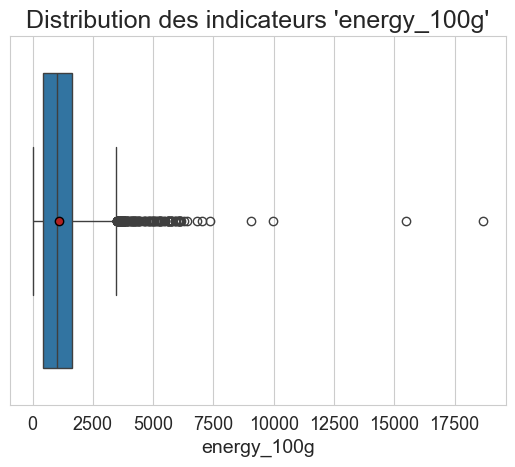

In [50]:
# Liste des outliers 
energy_outlier = detectOutlier(frfoodfacts_df['energy_100g'], 2)

# Afficher les nouveaux outliers
sns.boxplot(data=frfoodfacts_df[~frfoodfacts_df['energy_100g'].isin(energy_outlier)],
                x='energy_100g',
                orient='h', 
                showmeans=True, 
                meanprops=meanprops)
plt.title("Distribution des indicateurs 'energy_100g'")
plt.xlabel('energy_100g')
plt.show()

Nous observons que plus généralement, les outliers sont les valeurs au-dessus de 5000 kJ/100g. Sont écartés : les valeurs non comprises dans [0, 5000].

In [51]:
# Filtre les valeurs comprises dans [0, 5000]
frfoodfacts_df = filter_df_by_range(frfoodfacts_df, 'energy_100g', 0, 5000, change_log_df)

#### `nutrition-score-fr_100g`

Nous observons que les valeurs de nutriscore sont comprises dans [-15, 40]. Toute valeur en-dehors de cet intervalle peut être considérée comme outlier.

In [52]:
frfoodfacts_df = filter_df_by_range(frfoodfacts_df, 'nutrition-score-fr_100g', -15, 40, change_log_df)

#### `sodium_100g`

Tout vérifions la validité de la relation entre sel et sodium énoncée en [partie 1](#1_5).

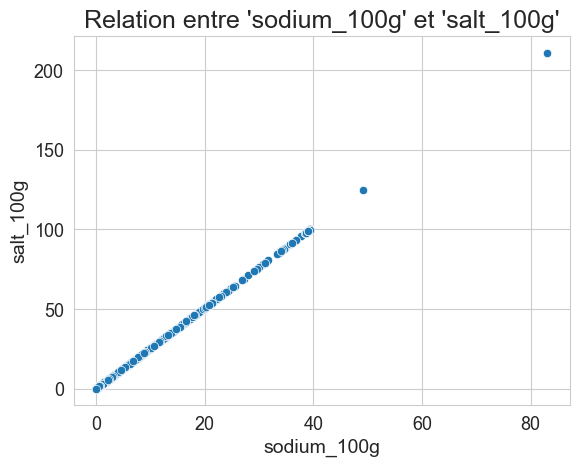

In [53]:
# Relation soudium_100g et salt_100g
sns.scatterplot(
    data = frfoodfacts_df, 
    x = 'sodium_100g',
    y = 'salt_100g')
plt.title("Relation entre 'sodium_100g' et 'salt_100g'")
plt.show()

In [54]:
# Décomposition du dataset et transformation en matrices pour pouvoir effectuer la régression linaire
data_salt = frfoodfacts_df[['salt_100g', 'sodium_100g']].dropna()
X = np.matrix([np.ones(data_salt.shape[0]), data_salt['sodium_100g'].values]).T
y = np.matrix(data_salt['salt_100g']).T

# Calcul du paramètre theta
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta)

[[-3.61674507e-05]
 [ 2.54008382e+00]]


Nous avons donc bien la relation suivante : `salt_100g` = `sodium_100g` × 2,5 (le bruit est négligeable) donc la limite maximum pour le sodium pour 100g est de 100 / 2,5, soit 40 lorsque le produit est du sel pur.
Nous avons des outliers qui ont des valeurs supérieures à 40g -> à écarter.

In [55]:
# Filtre les valeurs comprises dans [0, 40]
frfoodfacts_df = filter_df_by_range(frfoodfacts_df, 'sodium_100g', 0, 40, change_log_df)

#### Autres informations nutritionnelles pour 100g

Nous observons des outliers pour certaines des variables listées ci-dessous. La proportion du composant nutritionnel doit comprise dans [0,100](100g ou 100% fruits-vegetables-nuts).

In [56]:
features_100g = ['fat_100g',
                 'saturated-fat_100g',
                 'monounsaturated-fat_100g',
                 'polyunsaturated-fat_100g',
                 'trans-fat_100g',
                 'carbohydrates_100g',
                 'sugars_100g',
                 'starch_100g',
                 'polyols_100g',
                 'fiber_100g',
                 'proteins_100g',
                 'salt_100g',
                 'fruits-vegetables-nuts_100g',
                 'alcohol_100g']

for feat in features_100g:
    frfoodfacts_df = filter_df_by_range(frfoodfacts_df, feat, 0, 100, change_log_df)

### d. Vérification des liens relationnels entre les informations nutritionnelles
-  Sel : `salt_100g` = `sodium_100g` × 2,5
- Matières grasses : `fat_100g` = `saturated-fat__100g` + `monounsaturated-fat_100g` + `polyunsaturated-fat_100g` + `trans-fat_100g`     
-  Glucides :`carbohydrates_100g` = `sugars_100g` + `starch_100g` + `polyols_100g` peut également inclure `fiber_100g`
- Total : `salt_100g` + `fat_100g` + `carbohydrates_100g` + `proteins_100g` <= 100g

Les produits pour lesquels delta < 0 sont mis de côté : une analyse par un spécialiste est nécessaire pour définir où se trouve l'erreur.

#### Sel : `salt_100g` = `sodium_100g` × 2,5

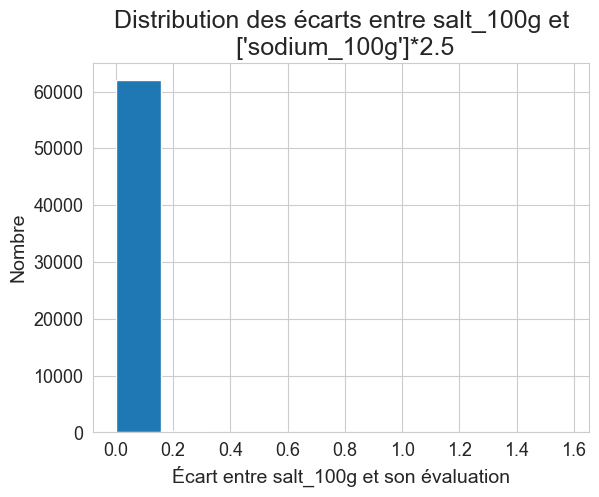

Il y a  0  valeurs de ['sodium_100g']*2.5 > salt_100g soit 0.0 % du dataset.


Empty DataFrame
Columns: [product_name, pnns_groups_1, pnns_groups_2, salt_100g, sodium_100g, eval, delta]
Index: []

In [57]:
# Evaluation de la quantité de sel 'salt_100g' à partir de la quantité de 'sodium_100g'
salt_columns = ['sodium_100g']
eval_salt = (frfoodfacts_df['sodium_100g']*2.5)
eval_calcul = "['sodium_100g']*2.5"

# Affichage de l'écart entre frfoodfacts_df['sodium_100g']*2.5 et 'salt_100g'
salt_outliers = delta_graph(frfoodfacts_df, 'salt_100g', eval_salt, eval_calcul, salt_columns)

####  Matières grasses : `fat_100g` = `saturated-fat__100g` + `monounsaturated-fat_100g` + `polyunsaturated-fat_100g` + `trans-fat_100g`     

La distribution des écarts montre que la relation `fat_100g` = `saturated-fat__100g` + `monounsaturated-fat_100g` + `polyunsaturated-fat_100g` + `trans-fat_100g` est valide : majeure partie des écarts à 0.    

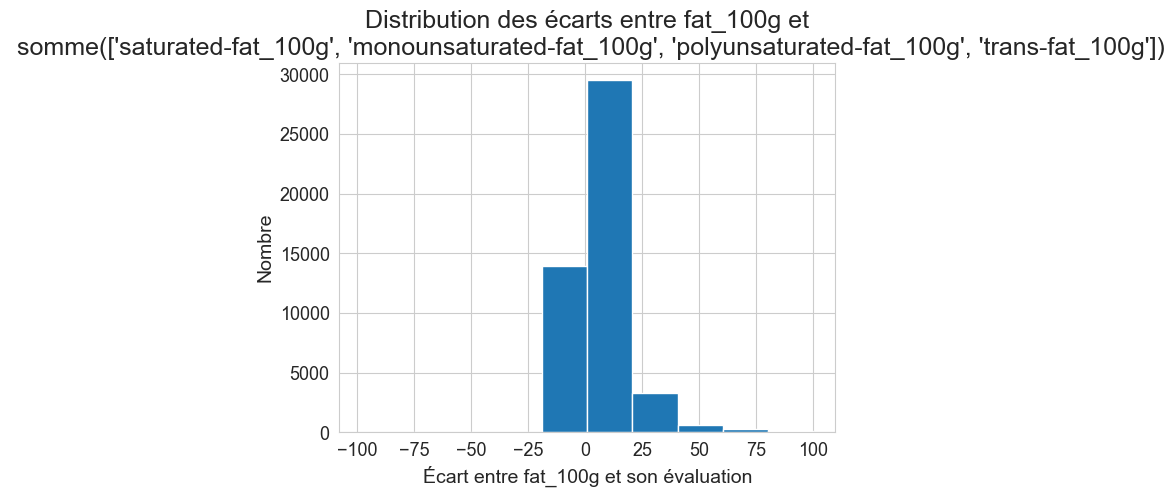

Il y a  244  valeurs de somme(['saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g']) > fat_100g soit 0.3 % du dataset.


product_name            pnns_groups_1  \
28125                        Bonbons aux herbes                      NaN   
80861         Purée d'amandes blanches grillées                      NaN   
38231                         Amandes en poudre                      NaN   
9870           Reblochon de Savoie (22% MG) Bio  milk-and-dairy-products   
11712  Chocolate Pretzel Dippers - Graze - 29 G                      NaN   

      pnns_groups_2  fat_100g  saturated-fat_100g  monounsaturated-fat_100g  \
28125           NaN       0.0                98.0                       NaN   
80861           NaN      54.8                45.0                      40.0   
38231           NaN      54.8                73.8                       NaN   
9870         cheese       0.0                17.0                       NaN   
11712           NaN       6.4                22.0                       NaN   

       polyunsaturated-fat_100g  trans-fat_100g  eval  delta  
28125                       NaN             NaN  98.0  -98.0  
80861                      10.3             NaN  95.3  -40.5  
38231                       NaN             NaN  73.8  -19.0  
9870                        NaN             NaN  17.0  -17.0  
11712                       NaN             NaN  22.0  -15.6

In [58]:
# Evaluation de la quantité de matières grasses 'fat_100g' à partir des colonnes détaillées
fat_columns = ['saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g']
eval_fat = frfoodfacts_df[fat_columns].sum(axis=1)
eval_calcul = "somme(['saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g'])"

# Affichage de l'écart entre 'fat_100g' et 'eval_fat'
fat_outliers = delta_graph(frfoodfacts_df, 'fat_100g', eval_fat, eval_calcul, fat_columns)

#### Glucides :`carbohydrates_100g` = `sugars_100g` + `starch_100g` + `polyols_100g` (+`fiber_100g` ?)

Dans certains cas, les fibres peuvent être incluses dans les glucides.
Nous pouvons déjà recherché les cas où `carbohydrates_100g` < `sugars_100g` + `starch_100g` + `polyols_100g` car nous sommes sûrs qu'il s'agit bien de valeurs erronées.

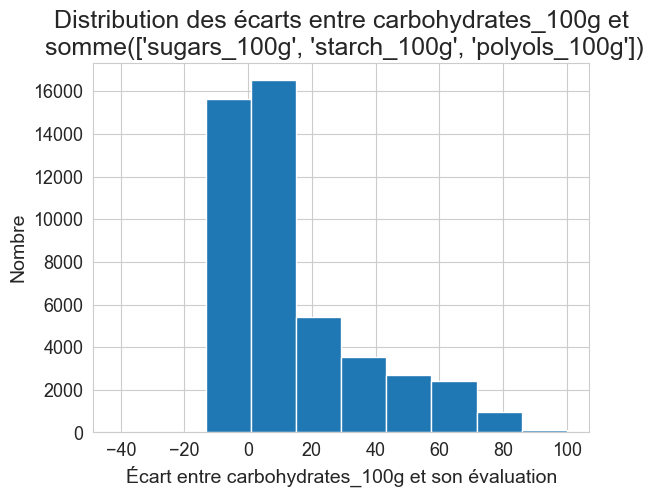

Il y a  117  valeurs de somme(['sugars_100g', 'starch_100g', 'polyols_100g']) > carbohydrates_100g soit 0.14 % du dataset.


product_name            pnns_groups_1  \
13772  Favorina, Haselnuss Nougat Eier                      NaN   
7000            Alter Eco Noir Dessert            sugary-snacks   
27887             Marinade pour Poulet                      NaN   
17215               Adelie Bac Vanille  milk-and-dairy-products   
4093                         Buongrano                      NaN   

            pnns_groups_2  carbohydrates_100g  sugars_100g  starch_100g  \
13772                 NaN                 7.0         48.6          NaN   
7000   chocolate-products                21.0         49.5          NaN   
27887                 NaN                 3.8         32.2          NaN   
17215           ice-cream                25.7         47.9          NaN   
4093                  NaN                 0.0         20.5          NaN   

       polyols_100g  eval  delta  
13772           NaN  48.6  -41.6  
7000            NaN  49.5  -28.5  
27887           NaN  32.2  -28.4  
17215           NaN  47.9  -22.2  
4093            NaN  20.5  -20.5

In [59]:
# Evaluation de la quantité de glucide 'carbohydrates_100g' à partir des colonnes détaillées
carbohydrates_columns = ['sugars_100g', 'starch_100g', 'polyols_100g']
eval_carbohydrates = frfoodfacts_df[carbohydrates_columns].sum(axis=1)
eval_calcul = "somme(['sugars_100g', 'starch_100g', 'polyols_100g'])"

# Affichage de l'écart entre  'carbohydrates_100g' et 'eval_carbohydrates' 
glucide_outliers = delta_graph(frfoodfacts_df, 
                               'carbohydrates_100g', 
                               eval_carbohydrates, 
                               eval_calcul, 
                               carbohydrates_columns)

Recherchons quelle est la relation considérée ici :
- `carbohydrates_100g` = `sugars_100g` + `starch_100g` + `polyols_100g`  avec ou sans `fiber_100g`

In [60]:
# Considérons uniquement les cas où 'fiber_100g' est non null et différent de 0
glucide_df = frfoodfacts_df[(frfoodfacts_df['fiber_100g'].notna())&(frfoodfacts_df['fiber_100g']!=0)]
carbohydrates_columns = ['sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g']
eval_carbohydrates = glucide_df[carbohydrates_columns].sum(axis=1)

# Recherchons les cas où la relation incluant les fibres est vraie
col_to_display = ['product_name', 'pnns_groups_1', 'pnns_groups_2', 'carbohydrates_100g']+carbohydrates_columns
result1 = glucide_df.loc[glucide_df['carbohydrates_100g']==eval_carbohydrates, col_to_display]

print(f"Il y a {len(result1)} cas où la relation carbohydrates_100g = sugars_100g + starch_100g + polyols_100g + fibers_100g"\
      f" est vraie, soit {round(len(result1)/len(frfoodfacts_df)*100,1)}% du dataset.")
display(result1.head())

Il y a 313 cas où la relation carbohydrates_100g = sugars_100g + starch_100g + polyols_100g + fibers_100g est vraie, soit 0.4% du dataset.


product_name    pnns_groups_1   pnns_groups_2  \
13                 Flowers collection              NaN             NaN   
861   Thai Kitchen Panang Curry Sauce              NaN             NaN   
1139               Sojade Mangue Coco    sugary-snacks          sweets   
1386      Saucisses de volaille Halal              NaN             NaN   
1633           Gratin à la Provençale  composite-foods  one-dish-meals   

      carbohydrates_100g  sugars_100g  starch_100g  polyols_100g  fiber_100g  
13                  22.8         22.5          NaN           NaN         0.3  
861                 15.5          9.7          NaN           NaN         5.8  
1139                11.5         11.0          NaN           NaN         0.5  
1386                 2.1          1.5          NaN           NaN         0.6  
1633                 5.3          3.6          NaN           NaN         1.7

In [61]:
# Recherchons les cas où la relation incluant les fibres est vraie
carbohydrates_columns = ['sugars_100g', 'starch_100g', 'polyols_100g']
eval_carbohydrates = glucide_df[carbohydrates_columns].sum(axis=1)

col_to_display = ['product_name', 'pnns_groups_1', 'pnns_groups_2', 'carbohydrates_100g']+carbohydrates_columns
result2 = glucide_df.loc[glucide_df['carbohydrates_100g']==eval_carbohydrates, col_to_display]

print(f"Il y a {len(result2)} cas où la relation carbohydrates_100g = sugars_100g + starch_100g + polyols_100g "\
      f"est vraie, soit {round(len(result2)/len(frfoodfacts_df)*100,1)}% du dataset.")
display(result2.head())

Il y a 2109 cas où la relation carbohydrates_100g = sugars_100g + starch_100g + polyols_100g est vraie, soit 2.6% du dataset.


product_name   pnns_groups_1          pnns_groups_2  \
53            Caviar d'aubergine             NaN                    NaN   
168         Clémentines pressées             NaN                    NaN   
351         Grignottes de Poulet             NaN                    NaN   
785  Soja douceur et calcium BIO       beverages  non-sugared-beverages   
798     Le Bon Paris -25% de sel  fish-meat-eggs         processed-meat   

     carbohydrates_100g  sugars_100g  starch_100g  polyols_100g  
53                  1.5          1.5          NaN           NaN  
168                10.0         10.0          NaN           NaN  
351                 0.7          0.7          NaN           NaN  
785                 2.7          2.7          NaN           NaN  
798                 0.4          0.4          NaN           NaN

Pour la suite de l'analyse, nous considérerons la relation carbohydrates_100g = sugars_100g + starch_100g + polyols_100g. Les quelques éléments où carbohydrates_100g = sugars_100g + starch_100g + polyols_100g + fiber_100g est vraie sont écartés : en perspective, nous pourrions considérer un traitement pour modifier les valeurs et les conserver dans le jeu de données d'analyse.

In [62]:
glucide_outliers_sup = list(result1.index)

#### Total des composants : `salt_100g` + `fat_100g` + `carbohydrates_100g` +  `fiber_100g` + `proteins_100g` <= 100g

Les valeurs au-dessus de 100g sont aberrantes et sont à écarter.

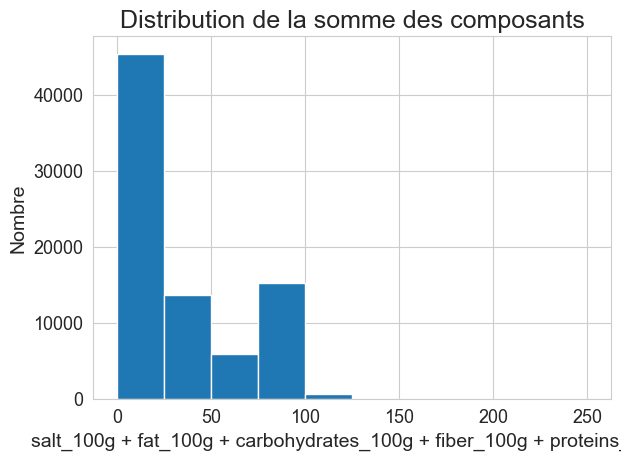

Il y a  228  produits pour lesquels la somme des composants > 102.0g soit 0.28 % du dataset.


product_name  total_100g  salt_100g  fat_100g  \
25382    Marshall - Major Noir       250.0       50.0       NaN   
24604              Fais Pas Ci       216.0       96.0       NaN   
25393                      Eau       202.0        2.0       NaN   
24488                      Bjk       201.0       69.0       NaN   
8298   Savarez - Jeu De Cordes       200.0        0.0       NaN   

       carbohydrates_100g  fiber_100g  proteins_100g  
25382                 NaN       100.0          100.0  
24604                 NaN        99.0           21.0  
25393                 NaN       100.0          100.0  
24488                 NaN        66.0           66.0  
8298                  NaN       100.0          100.0

In [63]:
# Affichage de la somme des composants
total_outlier = total_100g(frfoodfacts_df, 0.02)

In [64]:
# Suppression des lignes identifiées comme outliers
outliers_list = glucide_outliers_sup + glucide_outliers + fat_outliers + salt_outliers + total_outlier
frfoodfacts_df = frfoodfacts_df.drop(outliers_list)

In [65]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Outliers', 
            "Relation entre les variables nutritionnelles", 
            "Ecarter les données avec des incohérences"] 
           )

### e. Valeurs aberrantes de `nutrition_grade_fr`

In [66]:
# liste des valeurs possibles pour 'nutrition_grade_fr'
nutrigrade_list = ['a', 'b', 'c', 'd', 'e']

# Visualisation des valeurs aberrantes
frfoodfacts_df[(frfoodfacts_df['nutrition_grade_fr'].notna())&
               (~frfoodfacts_df['nutrition_grade_fr'].isin(nutrigrade_list))]

Empty DataFrame
Columns: [code, created_datetime, last_modified_datetime, product_name, brands, pnns_groups_1, pnns_groups_2, main_category_fr, energy_100g, fat_100g, saturated-fat_100g, monounsaturated-fat_100g, polyunsaturated-fat_100g, trans-fat_100g, carbohydrates_100g, sugars_100g, starch_100g, polyols_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, alcohol_100g, fruits-vegetables-nuts_100g, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []

In [67]:
# Suppression des éventuelles valeurs aberrantes
frfoodfacts_df = frfoodfacts_df.loc[(frfoodfacts_df['nutrition_grade_fr'].isna())|
               (frfoodfacts_df['nutrition_grade_fr'].isin(nutrigrade_list)), :]

In [68]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Outliers', 
            'nutrition_grade_fr', 
            "Ecarter les données différentes de 'a', 'b', 'c', 'd', 'e'"] 
           )

## <font color='#46abe6'>2.6. Identification et traitement des valeurs manquantes<a class="anchor" id="2_6"></a></font>

### a. Identifications des valeurs manquantes

**Valeurs manquantes à traiter :**
- Les variables catégorielles : pnns_groups_1 et 2
- Les variables utilisées dans le calcul du Nutriscore : 
    - energy_100g
    - saturated-fat_100g
    - sugars_100g
    - salt_100g
    - proteins_100g
    - fibers_100g
    - fruits-vegetables-nuts_100g
- Le nutriscore et le nutrigrade

<Axes: >

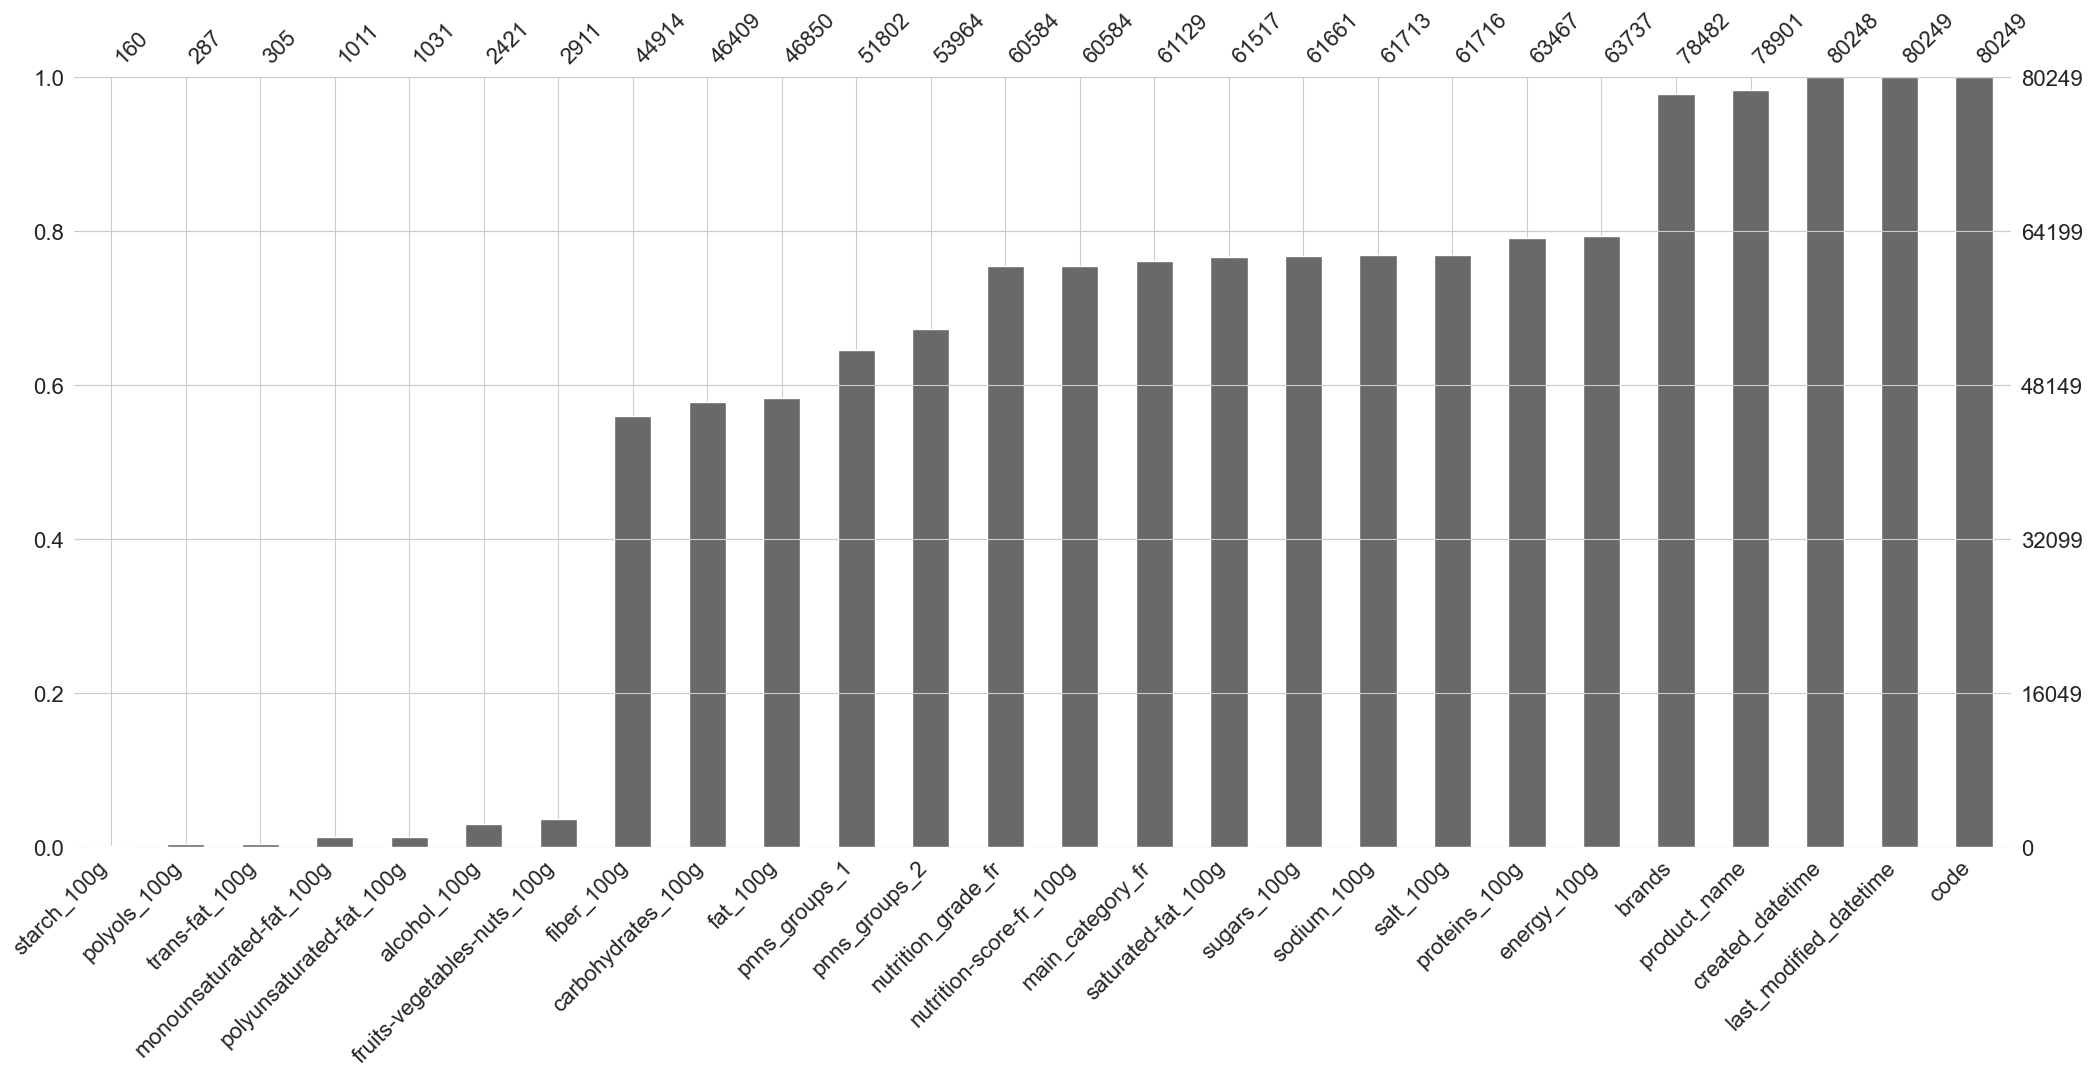

In [69]:
# Visualisation des valeurs manquantes
msno.bar(frfoodfacts_df, sort='ascending')

<Axes: >

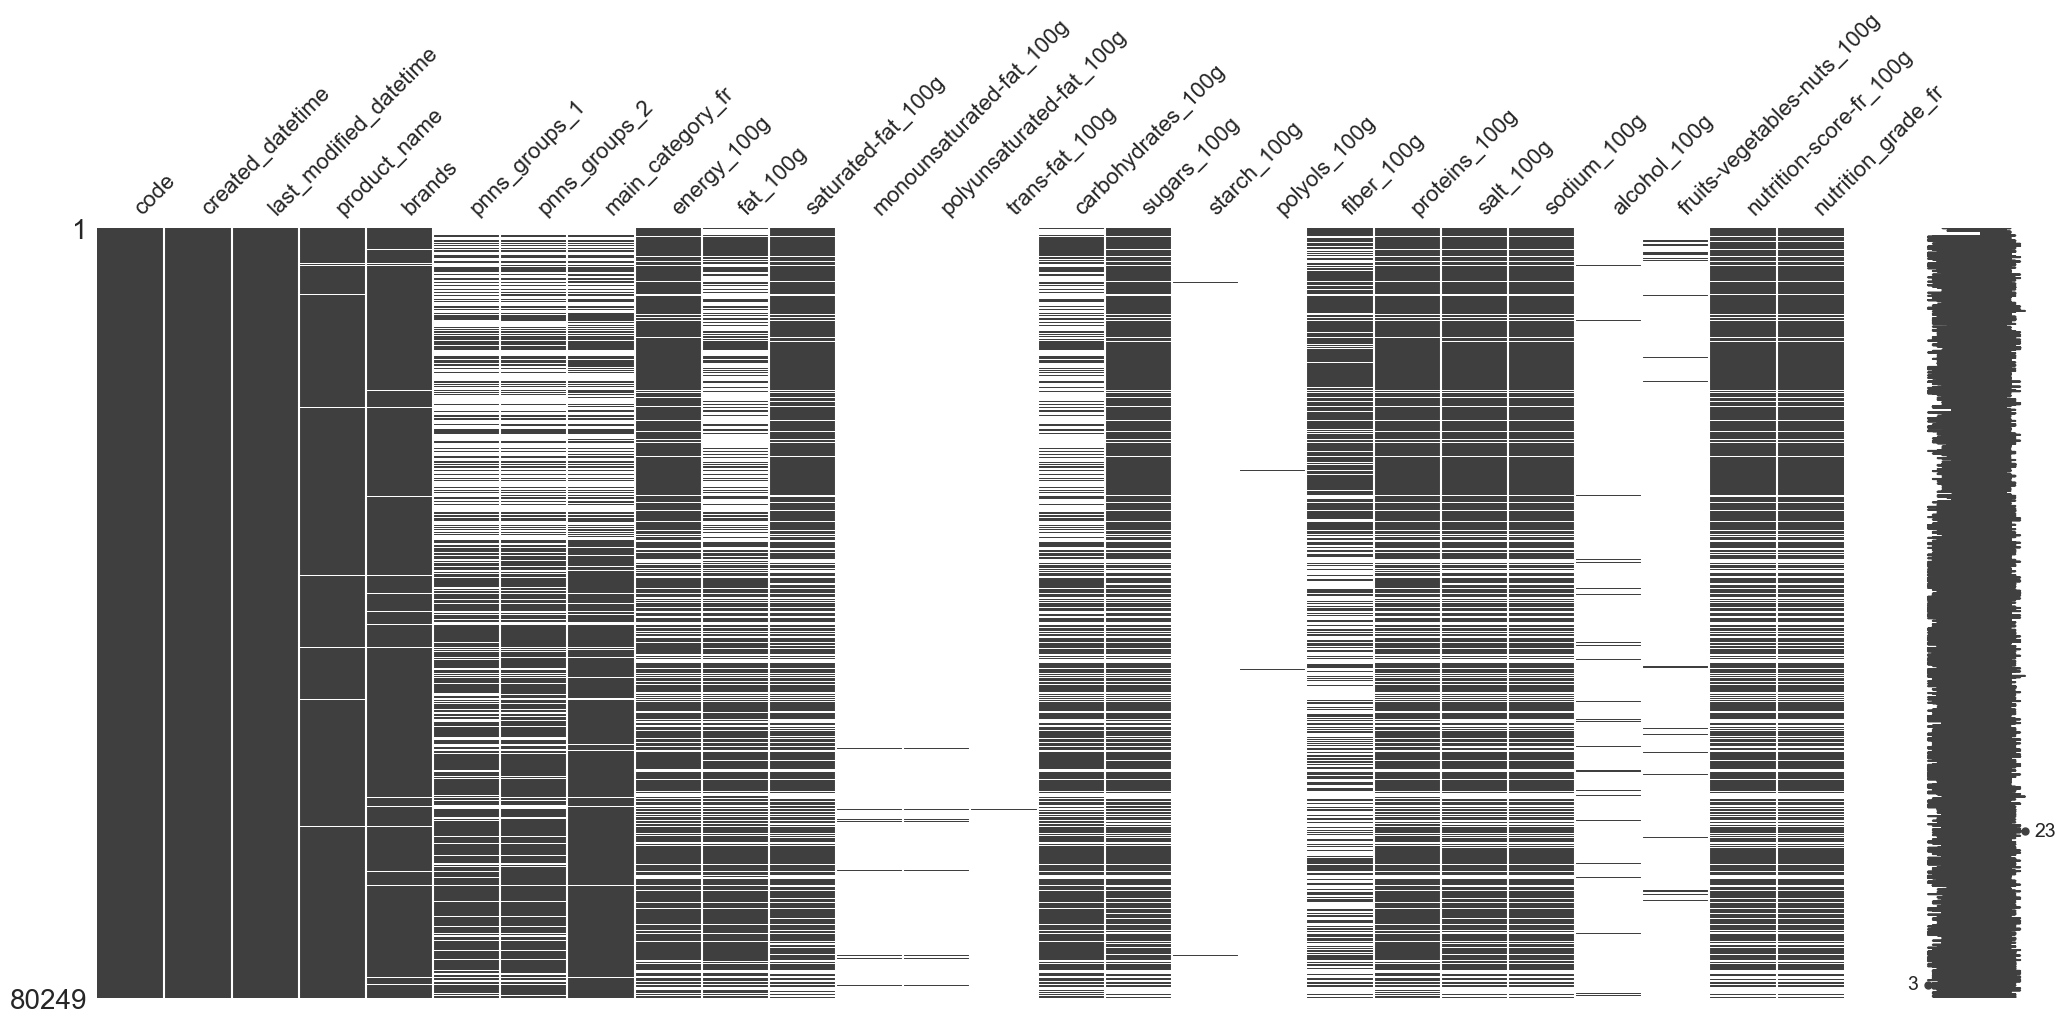

In [70]:
msno.matrix(frfoodfacts_df)

In [71]:
# Sauvegarde référence état avant imputation des valeurs manquantes
frfoodfacts_df.to_pickle('before_imputation_df.pkl')

### b. Variables catégorielles :  `pnns_groups_1` et `pnns_groups_2`

Pour imputer les valeurs manquantes de 'pnns_groups', différentes méthodes peuvent être utiliser :
- les mots-clés uniques
- les catégories uniques et/ou les plus fréquentes 
- valeurs nutritionnelles
- KNNImputer en transformant les variables catégorielles au préalable

#### `pnns_groups_1`
* **Imputer 'pnns_groups_1' en fonction de 'pnns_groups_2'**

Nous observons qu'il y a plus de valeurs manquantes 'pnns_groups_1' que 'pnns_groups_2'. Recherchons s'il y a des sous-groupes 'pnns_groups_2' sans groupe 'pnns_groups_1' et vérifions s'ils sont présents  dans le dictionnaire 'categories_dict'

In [72]:
# Dictionnaire associant pour chaque groupe 'pnns_groups_1' les sous-groupes 'pnns_groups_2' associés
categories_dict = frfoodfacts_df.groupby('pnns_groups_1')['pnns_groups_2'].unique().apply(list).to_dict()

In [73]:
# Recherchons s'il y a des sous-groupes 'pnns_groups_2' sans groupe 'pnns_groups_1'
groups_2 = list(frfoodfacts_df[frfoodfacts_df['pnns_groups_1'].isna()&
                          frfoodfacts_df['pnns_groups_2'].notna()]['pnns_groups_2'].unique())
print("Les sous-groupes 'pnns_groups_2' sans groupes 'pnns_groups_1' : ",groups_2)

# Vérifions si ces sous-groupes sont présents  dans le dictionnaire 'categories_dict'
for elt in groups_2:
    print(f"'pnns_groups_1' associé à {elt} : ", categories_dict.get(elt, []))

Les sous-groupes 'pnns_groups_2' sans groupes 'pnns_groups_1' :  ['alcoholic-beverages', 'tripe-dishes']
'pnns_groups_1' associé à alcoholic-beverages :  []
'pnns_groups_1' associé à tripe-dishes :  []


Ces catégories ne sont pas présentes dans le dictionnaire -> les ajouter dans le groupe 'pnns_groups_1' adapté

In [74]:
# Ajouter 'alcoholic-beverages' comme 'pnns_groups_1' et 'tripe-dishes' à 'fish-meat-eggs'
categories_dict['alcoholic-beverages']= ['alcoholic-beverages']
categories_dict.setdefault('fish-meat-eggs', []).append('tripe-dishes')

# Imputer 'pnns_groups_1' en fonction de 'pnns_groups_2'
frfoodfacts_df['pnns_groups_1'] = frfoodfacts_df['pnns_groups_2'].apply(lambda x: map_subcat_to_cat(x, 
                                                                                                    categories_dict,
                                                                                                    frfoodfacts_df))

In [75]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Imputation des valeurs manquantes', 
            'pnns_groups_1', 
            "Imputer pnns_groups_1 en fonction de pnns_groups_2"] 
           )

* **Imputer 'pnns_groups_1' en fonction des valeurs nutritionnelles**

Les produits qui ont :
- 'salt_100g'=100g -> catégorie 'salty-snacks'
- 'sugars_100g' = 100g -> catégorie 'sugary-snacks'
- 'fat_100g' > 80g -> catégorie 'fat-and-sauces'
- 'fruits-vegetables-nuts_100g' > 80g -> catégorie fruits-and-vegetables'

In [76]:
# Exemple pour le sel
frfoodfacts_df.loc[(frfoodfacts_df['salt_100g']==100)&(frfoodfacts_df['pnns_groups_1'].isna()),
                ['product_name', 'pnns_groups_1', 'pnns_groups_2', 'main_category_fr', 'salt_100g', 'sodium_100g']].head()

product_name pnns_groups_1 pnns_groups_2 main_category_fr  \
3072      Sel fin de Guerande          None           NaN             sels   
4408      Sel fin de met iodé          None           NaN             sels   
5884      Sel fin de Guérande          None           NaN             sels   
11470  Moulin Sel de Guérande          None           NaN             sels   
15331  Sel Fin de l'Île de Ré          None           NaN             sels   

       salt_100g  sodium_100g  
3072       100.0    39.370079  
4408       100.0    39.370079  
5884       100.0    39.370079  
11470      100.0    39.370079  
15331      100.0    39.370079

In [77]:
# Dictionnaire de correspondance entre 'mask' et 'pnns_groups_1'
pnns_nutri_dicts = [
    {'mask':(frfoodfacts_df['salt_100g']==100)&(frfoodfacts_df['pnns_groups_1'].isna()), 
         'pnns_groups_1': 'salty-snacks'},
    {'mask':(frfoodfacts_df['sugars_100g']==100)&(frfoodfacts_df['pnns_groups_1'].isna()), 
        'pnns_groups_1':'sugary-snacks'},
    {'mask':(frfoodfacts_df['fat_100g']>=80)&(frfoodfacts_df['pnns_groups_1'].isna()), 
        'pnns_groups_1': 'fat-and-sauces'},
    {'mask':(frfoodfacts_df['fruits-vegetables-nuts_100g']>=80)&(frfoodfacts_df['pnns_groups_1'].isna()), 
        'pnns_groups_1':'fruits-and-vegetables'},
    {'mask':(frfoodfacts_df['alcohol_100g']>0)&(frfoodfacts_df['pnns_groups_1'].isna()),
         'pnns_groups_1':'alcoholic-beverages'}
]

# Imputation des valeurs manquantes en fonction des correspondances 'mask' et 'pnns_groups_1'
apply_pnns_imputations(frfoodfacts_df, 'pnns_groups_1', pnns_nutri_dicts, change_log_df)

* **Imputation de `pnns_groups_1` en fonction de `main_category_fr`**
Associer les catégories 'main_category_fr'  les plus fréquentes à chaque groupe 'pnns_groups_1'

In [78]:
# Création du dictionnaire associant les catégories 'main_category_fr' les plus fréquentes à chaque groupe 'pnns_groups_1'
categ_dict = category_dictionary(frfoodfacts_df)

# Imputation de 'pnns_groups_1' en fonction des 'main_category_fr' associées
frfoodfacts_df = fillna_categ(frfoodfacts_df, categ_dict, 'pnns_groups_1', 'main_category_fr', change_log_df)

#### `pnns_groups_2`
* **Imputation de `pnns_groups_2`**

In [79]:
# Dictionnaire de correspondance entre 'mask' et 'pnns_groups_1'
pnns_nutri_dicts = [
    {'mask':(frfoodfacts_df['salt_100g']==100)|(frfoodfacts_df['main_category_fr']=='sels')&
     (frfoodfacts_df['pnns_groups_2'].isna()), 
         'pnns_groups_2': 'salts'},
    {'mask':(frfoodfacts_df['pnns_groups_1']=='alcoholic-beverages')&(frfoodfacts_df['pnns_groups_2'].isna()), 
        'pnns_groups_2':'alcoholic-beverages'},
]

# Imputation des valeurs manquantes en fonction des correspondances 'mask' et 'pnns_groups_2'
apply_pnns_imputations(frfoodfacts_df, 'pnns_groups_2', pnns_nutri_dicts, change_log_df)

* **Recherche de mots-clés uniques dans  `main_category_fr`  en fonction de chaque groupe `pnns_groups_2`**

L'utilisation des mots-clés de  `main_category_fr` pour attribuer des valeurs manquantes de `pnns_groups_2` a été testée : il y a beaucoup de groupes sans mots-clés uniques. Cette méthode serait à tester sur d'autres variables.

In [80]:
keywords_dict = keywords_to_dict(frfoodfacts_df, 'pnns_groups_2', 'main_category_fr')
keywords_dict

{'chocolate-products': ['chocolats'],
 'ice-cream': [],
 'appetizers': [],
 'cereals': ['coquillettes'],
 'biscuits-and-cakes': ['genoise'],
 'salts': [],
 'sweets': ['confitures'],
 'one-dish-meals': [],
 'sweetened-beverages': ['sodas'],
 'fish-and-seafood': ['sardines'],
 'pizza-pies-and-quiche': [],
 'sandwich': ['sandwichs'],
 'cheese': ['emmental'],
 'dressings-and-sauces': ['vinaigres'],
 'non-sugared-beverages': [],
 'bread': [],
 'vegetables': ['champignons'],
 'fruit-juices': [],
 'fruits': [],
 'dried-fruits': [],
 'fruit-nectars': [],
 'legumes': [],
 'milk-and-yogurt': [],
 'fats': ['beurres'],
 'artificially-sweetened-beverages': [],
 'processed-meat': ['jambons', 'lardons'],
 'breakfast-cereals': [],
 'meat': [],
 'nuts': [],
 'alcoholic-beverages': ['carrefour',
  'gins',
  'abdijbier',
  'alcool',
  'ru',
  'digestifs',
  'likor',
  'hypocras',
  'alsace',
  'chouchen',
  'pt',
  'prosecco',
  'vino'],
 'pastries': [],
 'potatoes': [],
 'soups': [],
 'dairy-desserts': 

###  c. Variables nutritionnelles quantitatives :

* **Mise à 0 des valeurs manquantes** 

Les autres valeurs manquantes peuvent être mises à 0 dans les cas suivants :
- sels : Les produits 'sels' sont à 100g en `salt_100g`,
- sucres : Les produits 'sucres' à 100g en `sugars_100g`,
- matières grasses : Les produits à 100g en `fat_100g`
- eaux : les produits de la catégorie 'main_category_fr' = 'eaux'

In [81]:
# Pour les produits 'sels', remplacer les NaN  des colonnes 'salts_zero' par 0
salts_zero = [
    'energy_100g', 
    'fat_100g', 
    'saturated-fat_100g',
    'monounsaturated-fat_100g', 
    'polyunsaturated-fat_100g',
    'trans-fat_100g', 
    'carbohydrates_100g', 
    'sugars_100g', 
    'starch_100g',
    'polyols_100g', 
    'fiber_100g', 
    'proteins_100g', 
    'fruits-vegetables-nuts_100g'
]
salts_mask = (frfoodfacts_df['pnns_groups_2']=='salts')

fillnan_zero(frfoodfacts_df, salts_mask, salts_zero, change_log_df)

In [82]:
# Pour les produits 'sucres', remplacer les NaN  des colonnes 'sugars_zero' par 0
sugars_zero = [
    'fat_100g', 
    'saturated-fat_100g',
    'monounsaturated-fat_100g', 
    'polyunsaturated-fat_100g',
    'trans-fat_100g', 
    'starch_100g',
    'polyols_100g', 
    'fiber_100g', 
    'proteins_100g',
    'salt_100g', 
    'sodium_100g',
    'fruits-vegetables-nuts_100g'
]

sugar_mask = (frfoodfacts_df['sugars_100g']==100)

fillnan_zero(frfoodfacts_df, sugar_mask, sugars_zero, change_log_df)

In [83]:
# Mettre 'carbohydrates_100g' à 100 pour le sucres
frfoodfacts_df.loc[sugar_mask&(frfoodfacts_df['carbohydrates_100g'].isna()), 'carbohydrates_100g'] = 100

# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Imputation des valeurs manquantes', 
            'carbohydrates_100g', 
            f"Mettre 'carbohydrates_100g' = 100 si ['sugars_100g']==100"] 
           )

In [84]:
# Pour les produits 'fat', remplacer les NaN  des colonnes 'fat_zero' par 0
fat_zero = [
    'carbohydrates_100g', 
    'sugars_100g', 
    'starch_100g',
    'polyols_100g', 
    'fiber_100g',
    'proteins_100g',
    'salt_100g', 
    'sodium_100g',
    'fruits-vegetables-nuts_100g'
]

fat_mask = (frfoodfacts_df['fat_100g']==100)

fillnan_zero(frfoodfacts_df, fat_mask, fat_zero, change_log_df)

In [85]:
# Pour les produits 'eaux', remplacer les NaN  des colonnes 'water_zero' par 0
water_zero = [
    'energy_100g', 
    'fat_100g', 
    'saturated-fat_100g',
    'monounsaturated-fat_100g', 
    'polyunsaturated-fat_100g',
    'trans-fat_100g', 
    'carbohydrates_100g', 
    'sugars_100g', 
    'starch_100g',
    'polyols_100g', 
    'fiber_100g', 
    'proteins_100g',
    'alcohol_100g', 
    'fruits-vegetables-nuts_100g'
]

water_mask = (frfoodfacts_df['main_category_fr']=='eaux')

fillnan_zero(frfoodfacts_df, water_mask, water_zero, change_log_df)

* **Imputation par la moyenne ou la médiane**

La moyenne ou la médiane de chaque groupe `pnns_groups_1` ou sous-groupe `pnns_groups_2` peut être utilisée pour l'imputation des valeurs manquantes.
Le choix entre la moyenne et la médiane est déterminé suivant les critères suivants :
- La moyenne est sensible à la présence de quelques valeurs extrêmes.
- La médiane des valeurs non manquantes a une bien meilleure robustesse que la moyenne en présence de valeurs extrêmes.

Pour les cas ci-dessous, la présence d'outliers influant fortement sur la moyenne nous oriente vers la médiane (voir exemples).

In [86]:
# Copie du dataframe pour pour pouvoir comparer différentes méthodes d'imputations
median_df = frfoodfacts_df.copy()
mask = (median_df['pnns_groups_1'] == 'sugary-snacks')&(median_df['pnns_groups_2'].notna()) 
before_imputation = median_df.loc[mask, 'sugars_100g'].isna().sum()

In [87]:
#  Taille des sous-groupes de 'sugary-sancks' et nombre de valeurs manquantes pour 'sugars_100g'
display(pd.DataFrame({
'Taille du groupe' : median_df[(median_df['pnns_groups_1'] == 'sugary-snacks')].groupby('pnns_groups_2').size(),
'Valeurs manquantes' : median_df[(median_df['pnns_groups_1'] == 'sugary-snacks') & 
                                    (median_df['sugars_100g'].isnull())].groupby('pnns_groups_2').size()
}))

Taille du groupe  Valeurs manquantes
pnns_groups_2                                           
biscuits-and-cakes              3725                 509
chocolate-products              2158                 409
pastries                         463                  93
sweets                          3379                 983

sugars_100g                                             
                         count   mean    std  min    q1 median    q3    max
pnns_groups_2                                                              
biscuits-and-cakes        3216  30.93  10.06  0.0  25.3   30.6  36.8   94.2
chocolate-products        1749  43.65  14.86  0.0  36.0   47.0  53.0   85.5
pastries                   370  14.98   5.85  2.8  12.0   13.5  16.2   53.0
sweets                    2396  52.07  23.93  0.0  42.8   55.0  62.6  100.0

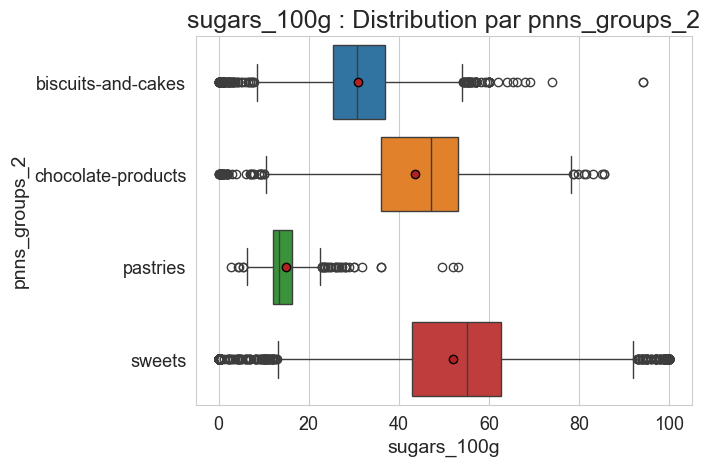

In [88]:
# Observation de la distribution des valeurs 'sugars_100g' pour un groupe
cond = (median_df['pnns_groups_1'] == 'sugary-snacks') & (median_df['sugars_100g'].notna())
stats(median_df[cond], ['sugars_100g'], 'pnns_groups_2', colors=None, showfliers=True)

In [89]:
# Imputation des valeurs manquantes de 'sugars_100g' par la médiane du groupe 'pnns_groups_2'
median_df[mask] = fillna_based_on_group(median_df[mask], 'sugars_100g', 'pnns_groups_2', agg_func='median')

In [90]:
# Verification de l'imputation des valeurs manquantes
after_imputation = median_df.loc[mask, 'sugars_100g'].isna().sum()

display(pd.DataFrame({'index' : ['sugars_100g'],
                      'Avant imputation' : before_imputation,
                     'Après imputation' : after_imputation}))

index  Avant imputation  Après imputation
0  sugars_100g              1994                 0

* **Imputation avec KNNImputer**

Le KNNImputer peut également être utilisé pour imputer les valeurs manquantes.
- Pour le test de méthode, nous utiliserons également 'pnns_groups_1'=='sugary-snacks'. Seules lignes complètes pour les variables cibles, sans valeurs manquantes, seront conservées. 
- Pour le test du modèle, nous ajouterons aléotoirement des trous dans le dataset.

In [91]:
# Variables à imputer
nutri_features = ['energy_100g', 
                  'saturated-fat_100g', 
                  'sugars_100g', 
                  'fiber_100g', 
                  'proteins_100g', 
                  'salt_100g', 
                  'fruits-vegetables-nuts_100g',
                  'nutrition-score-fr_100g']

In [92]:
# Définition du dataframe pour les données d'entraînement et de test
sugary_df = frfoodfacts_df[frfoodfacts_df['pnns_groups_1']=='sugary-snacks'].copy()

# Suppression des lignes avec des valeurs manquantes
sugary_df_full = sugary_df.dropna(subset=nutri_features, how='any')

# Dimensions du dataframe de test
sugary_df_full.shape

(391, 26)

In [93]:
# Représentation des sous-groupes 'pnns_groups_2' dans le jeu de données
sugary_df_full.groupby('pnns_groups_2').size()

pnns_groups_2
biscuits-and-cakes     39
chocolate-products     12
pastries                1
sweets                321
dtype: int64

Le sous-groupe 'pastries' n'est pas bien représenté dans ce jeu de données.

##### Entraînement du modèle

In [94]:
# Echantillon d'entraînement et de test
train, test = train_test_split(sugary_df_full[nutri_features],test_size=0.2, random_state=42)

In [95]:
# 20% des valeurs seront remplacées par 'NaN'
test_NaN = test.copy()

proportion_nan = 0.2
np.random.seed(42)

# Nombre total de valeurs à remplacer
num_nan_values = int(proportion_nan * test_NaN.size)

# Indices aléatoires pour les valeurs à remplacer
indices_to_replace = np.random.choice(test_NaN.size, num_nan_values, replace=False)

# Remplacez les valeurs par 'NaN'
test_NaN.values.flat[indices_to_replace] = np.nan

In [96]:
# Valeurs manquantes par variable
test_NaN.isna().sum()

energy_100g                    18
saturated-fat_100g             14
sugars_100g                    13
fiber_100g                     10
proteins_100g                  18
salt_100g                      21
fruits-vegetables-nuts_100g    14
nutrition-score-fr_100g        18
dtype: int64

In [97]:
# Imputer les valeurs manquantes avec le KNNImputer
imputer = KNNImputer(n_neighbors=2)
imputer.fit(train)

KNNImputer(n_neighbors=2)

##### Test et évalutation du modèle

In [98]:
# Imputation des valeurs manquantes de test
test_imputed = imputer.transform(test_NaN)
test_imputed = pd.DataFrame(data = test_imputed.round(2), columns = test_NaN.columns.to_list())

In [99]:
# Valeurs manquantes par variable
test_imputed.isna().sum()

energy_100g                    0
saturated-fat_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
dtype: int64

In [100]:
# Evaluation du modèle : calcul du R2 score
for col in test.columns.to_list():
    r_squared = r2_score(test[col],test_imputed[col])
    print(f"{col} : Coefficient de détermination R2 = %.2f" % r_squared)

energy_100g : Coefficient de détermination R2 = 0.94
saturated-fat_100g : Coefficient de détermination R2 = 1.00
sugars_100g : Coefficient de détermination R2 = 0.99
fiber_100g : Coefficient de détermination R2 = 1.00
proteins_100g : Coefficient de détermination R2 = 0.96
salt_100g : Coefficient de détermination R2 = 0.98
fruits-vegetables-nuts_100g : Coefficient de détermination R2 = 0.93
nutrition-score-fr_100g : Coefficient de détermination R2 = 0.96


Le R2 score est supérieur à 0.9 pour toutes les variables. Le modèle peut maintenant être utilisé pour compléter les valeurs manquantes du groupe 'sugary-snacks'.

##### Utilisation du modèle entraîné et validé

In [101]:
# Nombre de valeurs manquantes avant imputation
before_imputation = sugary_df[nutri_features].isna().sum()

In [102]:
# Imputer les valeurs manquantes avec le KNNImputer entraîné
sugary_df.loc[:, nutri_features]  = imputer.transform(sugary_df[nutri_features])

In [103]:
# Nombre de valeurs manquantes après imputation
after_imputation = sugary_df[nutri_features].isna().sum()

display(pd.DataFrame({'Avant imputation' : before_imputation,
                     'Après imputation' : after_imputation}))

Avant imputation  Après imputation
energy_100g                              1818                 0
saturated-fat_100g                       2074                 0
sugars_100g                              1999                 0
fiber_100g                               4850                 0
proteins_100g                            1852                 0
salt_100g                                2070                 0
fruits-vegetables-nuts_100g              9096                 0
nutrition-score-fr_100g                  2135                 0

* **Régression linéaire multiple**

Pour l'imputation des valeurs manquantes du nutriscore, il est possible de :
- utiliser le méthode de calcul officielle du nutriscore : [Calcul du nutriscore](https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/qr-scientifique-technique-en)
- réaliser une régression linéaire multiple
- utiliser un KNNImputer (comme réaliser précédemment)

Dans le cas présent, nous allons tester la régression linéaire multiple. 

Pour le test, nous utiliserons la catégorie de produit 'sugary-snacks'.

In [104]:
# Taille des groupes 'pnns_groups_1' et nombre de valeurs manquantes par groupe
nutri_null = frfoodfacts_df[frfoodfacts_df['nutrition-score-fr_100g'].isnull()].groupby('pnns_groups_1').size()
nutriscore_df = pd.DataFrame({
    'index': nutri_null.index.to_list(),
    'taille groupe': frfoodfacts_df.groupby('pnns_groups_1').size().values,
    'valeur nulle': nutri_null.values
        })

display(nutriscore_df)

index  taille groupe  valeur nulle
0      alcoholic-beverages           2164          2106
1                beverages           6564          2171
2     cereals-and-potatoes           6079           987
3          composite-foods           6097          1017
4           fat-and-sauces           3745           950
5           fish-meat-eggs           6789          2168
6    fruits-and-vegetables           4571          1475
7  milk-and-dairy-products           6366          1281
8             salty-snacks           2116           302
9            sugary-snacks           9753          2135

In [105]:
# Définition du dataframe pour les données d'entraînement et de test
sugary_mlr_df = frfoodfacts_df[frfoodfacts_df['pnns_groups_1']=='sugary-snacks'].copy()

before_imputation = sugary_mlr_df['nutrition-score-fr_100g'].isna().sum()

# Suppression des lignes avec des valeurs manquantes
sugary_mlr_df = sugary_mlr_df.dropna(subset=nutri_features, how='any')

# Dimensions du dataframe de test
sugary_mlr_df.shape

(391, 26)

##### Entraînement

In [106]:
# Sélection des variables
sugary_mlr_df = sugary_mlr_df[nutri_features]

# renommer les colonnes
sugary_mlr_df.columns = ['energy', 'saturated_fat', 'sugars', 'fiber', 'proteins', 'salt', 'fruits', 'nutriscore']

In [107]:
# Définition des variables X et y 
X = sugary_mlr_df[['energy', 'saturated_fat', 'sugars', 'fiber', 'proteins', 'salt', 'fruits']]
y = sugary_mlr_df['nutriscore']

In [108]:
# Création de l'échantillon d'entraînement et de l'échantillon de test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [109]:
# Echantillon d'entraînement
train_index = X_train.index.to_list()
train = sugary_mlr_df[sugary_mlr_df.index.isin(train_index)]

In [110]:
# Regression linaire multiple avec 'nutriscore ~ energy + saturated_fat + sugars + fiber + proteins + salt + fruits'
reg_multi = smf.ols(formula='nutriscore ~ energy + saturated_fat + sugars + fiber + proteins + salt + fruits',
                                data=train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             nutriscore   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     353.5
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          5.69e-142
Time:                        12:02:01   Log-Likelihood:                -582.47
No. Observations:                 312   AIC:                             1181.
Df Residuals:                     304   BIC:                             1211.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.2582      0.622      3.633

* Significativité : 
Une p-value est > 0.05, pour 'proteins_100g' :le paramètre n'est pas significatif.
* Coefficient de détermination :
Le coefficient $R^{2}$ est de l'ordre de 0.8 : cela est élevé.
* Colinéarité : 
Un problème de colinéarité est suspecté.

In [111]:
# Regression linaire multiple sans 'proteins_100g'
reg_multi = smf.ols(formula='nutriscore ~ energy + saturated_fat + sugars + fiber + salt + fruits',data=train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             nutriscore   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     409.7
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.04e-142
Time:                        12:02:01   Log-Likelihood:                -583.86
No. Observations:                 312   AIC:                             1182.
Df Residuals:                     305   BIC:                             1208.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.0920      0.615      3.402

* Significativité : 
Toutes les p-values sont < 0.05 : l'hypothèse de nullité des paramètres est rejettée. Tous les paramètres sont significatifs.
* Coefficient de détermination :
Le coefficient $R^{2}$ est de l'ordre de 0.8 : cela est élevé.
* Colinéarité : 
Un problème de colinéarité est suspecté.

Nous allons tester la colinéarité des variables car une multicolinéarité est suspectée (voir reg_multi.summary()). Certains facteurs d'inflation de la variance sont > 2 : Les facteurs sont influencés par la corrélation avec d'autres facteurs.

In [112]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[2.7562979366157885,
 1.8792854994693582,
 3.8821492891164655,
 1.4714733596222787,
 1.931547840815804,
 2.535784077593307]

`energy_100g` est corrélé au nutriscore, nous allons testé sans cette variable.

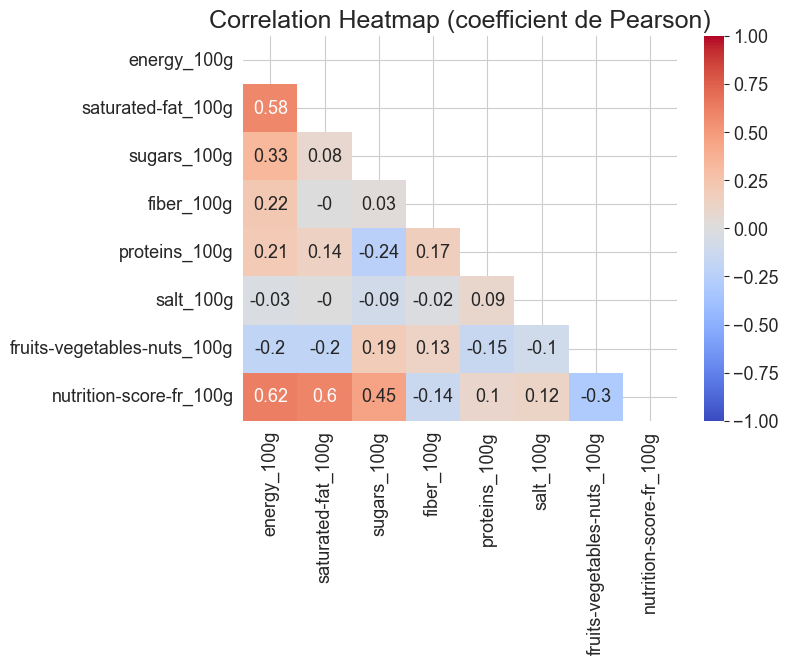

In [113]:
# Calcul du coefficient de corrélation de Pearson et représentation sous forme de heatmap
plt.figure(figsize=(7,5))
corr = round(frfoodfacts_df[nutri_features].corr(method='pearson'),2)
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='coolwarm', 
                      mask=mask)
heatmap.set_title('Correlation Heatmap (coefficient de Pearson)')
plt.show()

In [114]:
# regression linéaire multiple sans 'energy_100g'
reg_multi = smf.ols(formula='nutriscore ~ saturated_fat + sugars + fiber + salt + fruits',
                                data=train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             nutriscore   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     400.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          7.02e-132
Time:                        12:02:01   Log-Likelihood:                -612.54
No. Observations:                 312   AIC:                             1237.
Df Residuals:                     306   BIC:                             1260.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.5978      0.639      5.626

* Significativité : 
Toutes les p-values sont < 0.05 : l'hypothèse de nullité des paramètres est rejettée. Tous les paramètres sont significatifs.
* Coefficient de détermination :
Le coefficient $R^{2}$ est de l'ordre de 0.8 : cela est élevé.
* Colinéarité : 
Pas de problème de colinéarité

##### Test et évalutation

In [115]:
# Test et Evaluation du modèle
y_predict = reg_multi.predict(X_test) 

r_squared = r2_score(y_test,y_predict)
print("Coefficient de détermination R2 = %.2f" % r_squared)

Coefficient de détermination R2 = 0.82


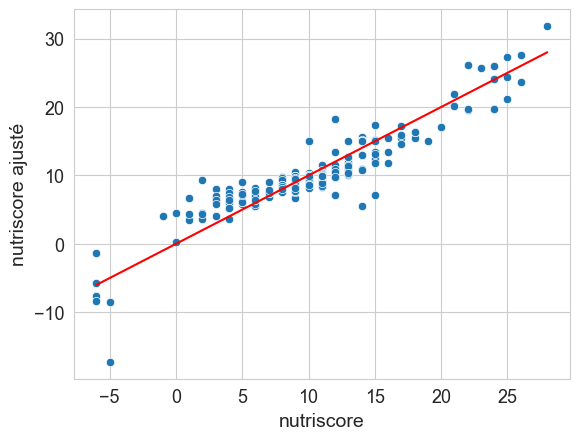

In [116]:
X = sugary_mlr_df[['saturated_fat', 'fiber', 'sugars', 'salt', 'fruits']]
y = sugary_mlr_df['nutriscore']
y_predict_reg_multi = reg_multi.predict(X)
y_plot = [y.min(), y.max()]
ax = sns.scatterplot(x=y, y=y_predict_reg_multi)
ax.set(xlabel='nutriscore', ylabel='nutriscore ajusté')
plt.plot(y_plot, y_plot, color='r')
plt.show()

##### Imputation des valeurs manquantes

In [117]:
# Utilisation du modèle de régression linéaire multiple pour imputer les valeurs manquantes
mlr_df = frfoodfacts_df[frfoodfacts_df['pnns_groups_1']=='sugary-snacks'].copy()

X_reg_multi = mlr_df.loc[mlr_df['nutrition-score-fr_100g'].isna(), \
                ['saturated-fat_100g', 
                  'sugars_100g', 
                  'fiber_100g', 
                  'salt_100g', 
                  'fruits-vegetables-nuts_100g']]

X_reg_multi.columns = ['saturated_fat', 'sugars', 'fiber', 'salt', 'fruits']

mlr_df.loc[mlr_df['nutrition-score-fr_100g'].isna(),'nutrition-score-fr_100g'] = reg_multi.predict(X_reg_multi)

In [118]:
# Nombre de valeurs manquantes après imputation
after_imputation = mlr_df['nutrition-score-fr_100g'].isna().sum()

display(pd.DataFrame({'index': ['nutrition-score-fr_100g'],
                     'Avant imputation' : before_imputation,
                     'Après imputation' : after_imputation}))

index  Avant imputation  Après imputation
0  nutrition-score-fr_100g              2135              2132

Il y a trop de valeurs manquantes pour les variables utilisées pour la régression pour que celle-ci soit applicable.

* **Comparaison des résultats des différents modèles**
##### Comparer KNNImputer et imputation par la médiane

L'imputation par le KNNImputer a fait apparaître un deuxième pic pour 'biscuits-and-cakes' et renforcer le pic de 'sweets'. 

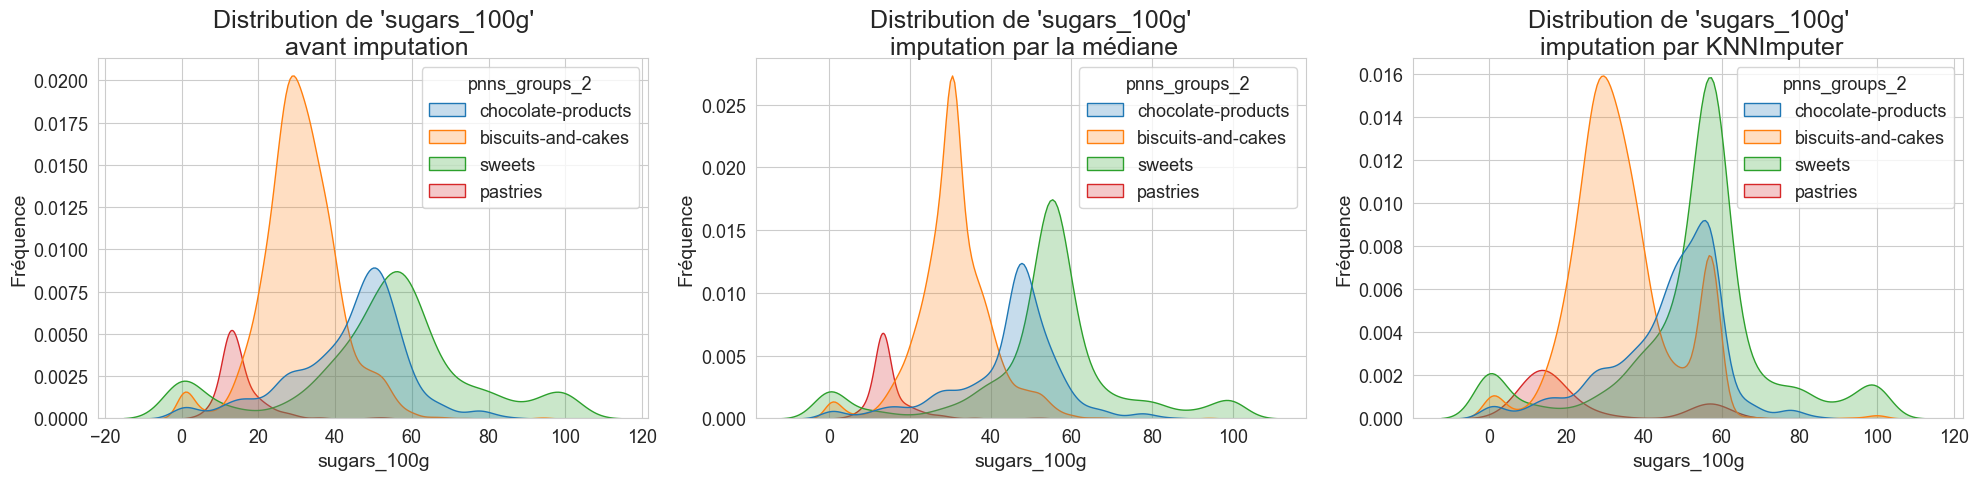

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), tight_layout=True)

# DataFrames à comparer
dataframes = [frfoodfacts_df, median_df, sugary_df]

# Appliquer le filtre commun à chaque DataFrame
subset_dfs = [df[(df['pnns_groups_1'] == 'sugary-snacks') & df['sugars_100g'].notna()] for df in dataframes]

# Modifier le subset_df pour afficher les groupes 'pnns_groups_2'
melted_dfs = [pd.melt(subset_df, id_vars='pnns_groups_2', value_vars='sugars_100g') for subset_df in subset_dfs]

methods = ['avant imputation', 'imputation par la médiane', 'imputation par KNNImputer']

for i, method in enumerate(methods):
    sns.kdeplot(data=melted_dfs[i], x='value', fill=True, ax=ax[i], hue='pnns_groups_2')
    ax[i].set_title(f"Distribution de 'sugars_100g'\n {method}", wrap=True)
    ax[i].set_xlabel('sugars_100g')
    ax[i].set_ylabel('Fréquence')

plt.show()

##### Nutriscore : KNNImputer 



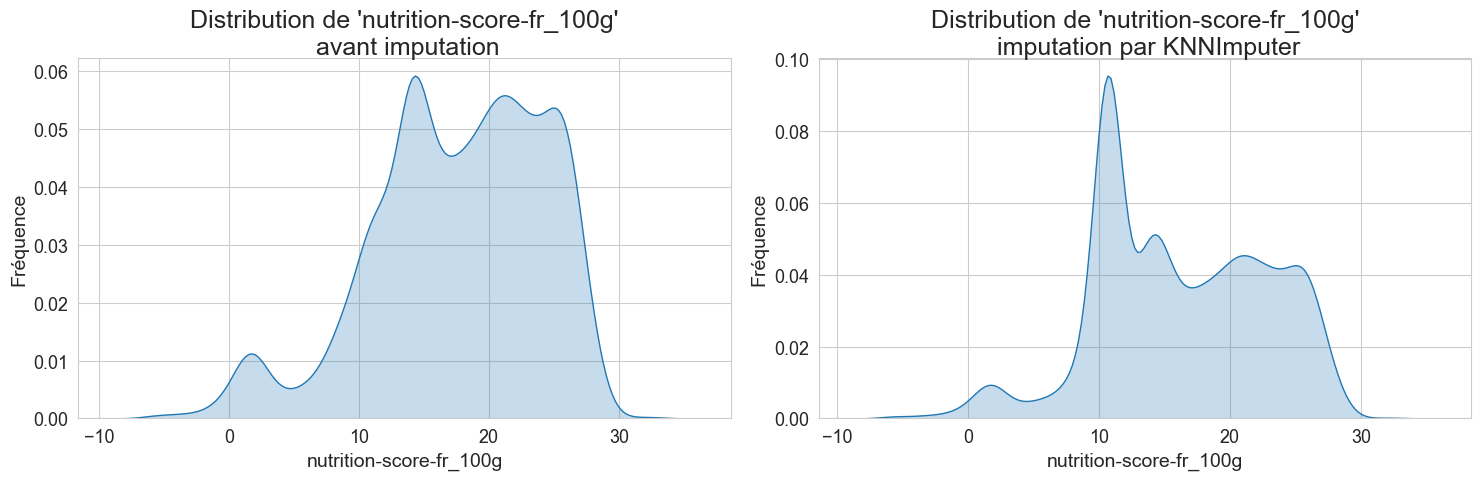

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)

# DataFrames à comparer
dataframes = [frfoodfacts_df, sugary_df]

# Appliquer le filtre commun à chaque DataFrame
subset_dfs = [df[(df['pnns_groups_1'] == 'sugary-snacks')&df['nutrition-score-fr_100g'].notna()] for df in dataframes]

methods = ['avant imputation', 'imputation par KNNImputer']

# Tracer les histogrammes
for i, method in enumerate(methods):
    sns.kdeplot(subset_dfs[i]['nutrition-score-fr_100g'], fill=True, ax=ax[i])
    ax[i].set_title(f"Distribution de 'nutrition-score-fr_100g'\n {method}", wrap=True)
    ax[i].set_xlabel('nutrition-score-fr_100g')
    ax[i].set_ylabel('Fréquence')

# Afficher les graphiques
plt.show()

##### Imputation des valeurs manquantes

La méthode du KNNImputer est retenue ici pour l'imputation des variables suivantes :
- 'energy_100g', 
- 'saturated-fat_100g', 
- 'sugars_100g', 
- 'fiber_100g', 
- 'proteins_100g', 
- 'salt_100g', 
- 'fruits-vegetables-nuts_100g',
- 'nutrition-score-fr_100g'

In [121]:
# Imputation des valeurs obtenues par KNNImputer pour le groupe 'sugary-snacks'
mask = frfoodfacts_df['pnns_groups_1']=='sugary-snacks'

frfoodfacts_df.loc[mask, nutri_features] = sugary_df.loc[:, nutri_features].values

In [122]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Imputation des valeurs manquantes', 
            nutri_features, 
            "'sugary-snacks' : Utilisation du modèle KNNImputer entraîné "] 
           )

### d. `Nutrition_grade_fr`

Il existe une relation entre le `nutrition-score-fr_100g` et le `nutrition_grade_fr` selon le type d'aliments ; voir ci-dessous.

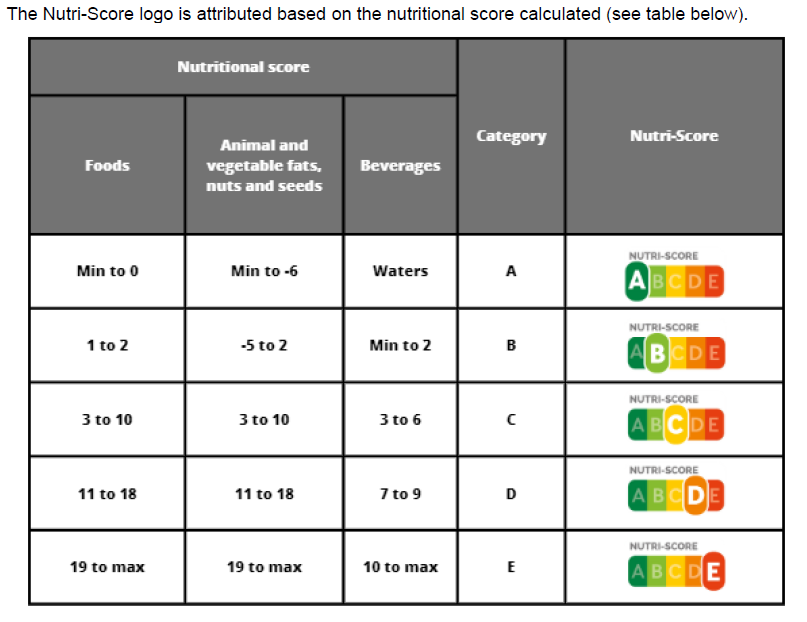

Sur le graphique ci-dessous, nous observons des plages : 
- nutrition score < -8 = nutrigrade 'a'
- 2 < nutrition score < 6 = nutrigrade 'c'
- nutrition score > 18 = nutrigrade 'e'

Pour 'b' et 'd', il y a trop de recouvrement avec les autres catégories.

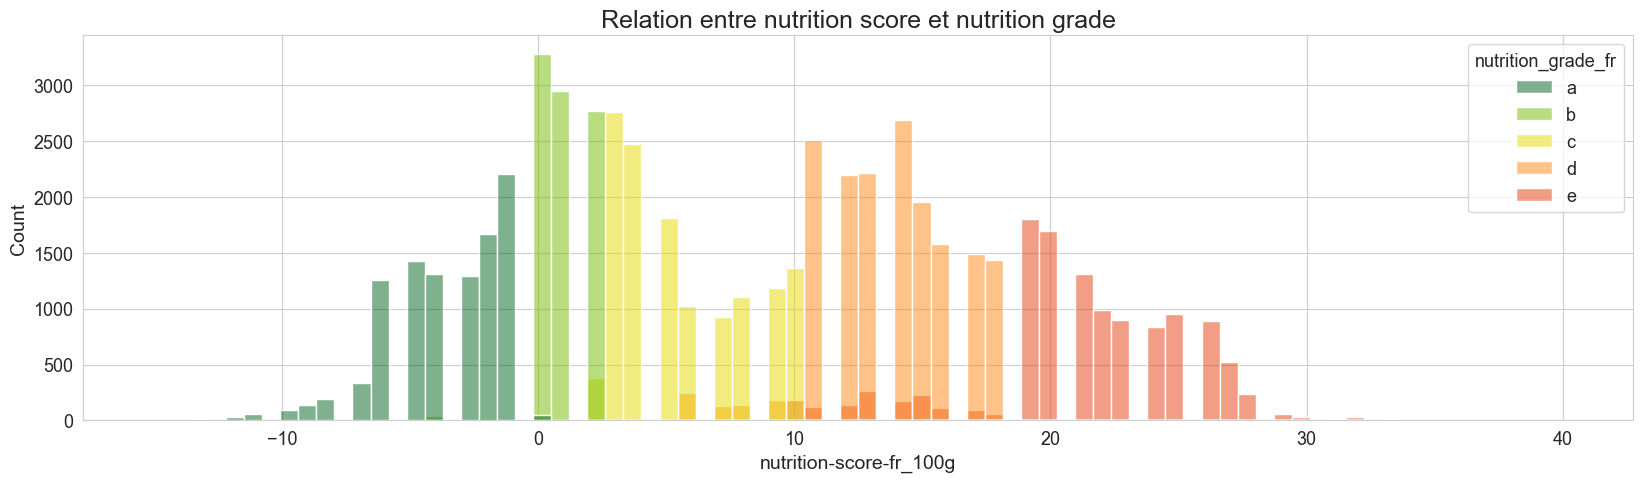

In [123]:
# Répartition du nutriscore et nutrigrade
plt.figure(figsize=(20,5))
sns.histplot(data=frfoodfacts_df.sort_values('nutrition_grade_fr'),
             x='nutrition-score-fr_100g', 
             hue='nutrition_grade_fr', 
             palette = ['#00641E', '#72BC00', '#E7DA00', '#FF8714', '#E63E10'])
plt.title('Relation entre nutrition score et nutrition grade')
plt.show()

In [124]:
# Plage nutriscore pour chaque nutrigrade

# Global
display(frfoodfacts_df.groupby(['nutrition_grade_fr']).agg({'nutrition-score-fr_100g' :['min', 'max']}))

# beverages
display(frfoodfacts_df[frfoodfacts_df['pnns_groups_1']=='beverages']\
    .groupby(['pnns_groups_1','nutrition_grade_fr']).agg({'nutrition-score-fr_100g' :['min', 'max']}))

# Autres que beverages
display(frfoodfacts_df[frfoodfacts_df['pnns_groups_1']!='beverages']\
    .groupby(['nutrition_grade_fr']).agg({'nutrition-score-fr_100g' :['min', 'max']}))

nutrition-score-fr_100g      
                                       min   max
nutrition_grade_fr                              
a                                    -15.0  10.0
b                                     -8.0   2.0
c                                      2.0  10.0
d                                      6.0  18.0
e                                     10.0  40.0

nutrition-score-fr_100g      
                                                     min   max
pnns_groups_1 nutrition_grade_fr                              
beverages     a                                     -5.0  10.0
              b                                     -8.0   2.0
              c                                      2.0   9.0
              d                                      6.0  18.0
              e                                     10.0  40.0

nutrition-score-fr_100g      
                                       min   max
nutrition_grade_fr                              
a                                    -15.0  -1.0
b                                     -1.0   2.0
c                                      2.0  10.0
d                                      6.0  18.0
e                                     10.0  36.0

Pour l'imputation des valeurs manquantes, nous appliquerons les règles officielles suivant les types de produits.

In [125]:
before_imputation = frfoodfacts_df['nutrition_grade_fr'].isna().sum()

In [126]:
# Catégories 'beverages'  eaux
mask = (frfoodfacts_df['nutrition_grade_fr'].isna()) & (frfoodfacts_df['main_category_fr']=='eaux')
    
frfoodfacts_df.loc[mask, 'nutrition_grade_fr'] = 'a'

In [127]:
# Catégories 'beverages' hors eaux
mask = (frfoodfacts_df['nutrition_grade_fr'].isna()) & (frfoodfacts_df['pnns_groups_1']=='beverages')
    
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g']<2), 'nutrition_grade_fr'] = 'b'
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g'].between(3,6)), 'nutrition_grade_fr'] = 'c'
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g'].between(7,9)), 'nutrition_grade_fr'] = 'd'
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g']>10), 'nutrition_grade_fr'] = 'e'

In [128]:
# Catégories de produits autres que 'beverages'
mask = (frfoodfacts_df['nutrition_grade_fr'].isna()) & \
       (frfoodfacts_df['pnns_groups_1']!='beverages') & (frfoodfacts_df['pnns_groups_1'].notna())
    
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g'].between(3,10)), 'nutrition_grade_fr'] = 'c'
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g'].between(11,18)), 'nutrition_grade_fr'] = 'd'
frfoodfacts_df.loc[mask & (frfoodfacts_df['nutrition-score-fr_100g']>19), 'nutrition_grade_fr'] = 'e'

In [129]:
# Catégrie de produits 'fats'
mask = (frfoodfacts_df['nutrition_grade_fr'].isna()) & (frfoodfacts_df['pnns_groups_2'] =='fats')

frfoodfacts_df.loc[mask & frfoodfacts_df['nutrition-score-fr_100g']<-6, 'nutrition_grade_fr'] = 'a'
frfoodfacts_df.loc[mask & frfoodfacts_df['nutrition-score-fr_100g'].between(-5,2), 'nutrition_grade_fr'] = 'b'

In [130]:
# Autres produits solides
mask = (frfoodfacts_df['pnns_groups_2'] !='fats') & (frfoodfacts_df['pnns_groups_2'].notna()) & \
       (frfoodfacts_df['pnns_groups_1']!='beverages') & (frfoodfacts_df['pnns_groups_1'].notna())
    
frfoodfacts_df.loc[mask & frfoodfacts_df['nutrition-score-fr_100g']<0, 'nutrition_grade_fr'] = 'a'
frfoodfacts_df.loc[mask & frfoodfacts_df['nutrition-score-fr_100g'].between(1,2), 'nutrition_grade_fr'] = 'b'

In [131]:
# Valeurs manquantes imputées
after_imputation = frfoodfacts_df['nutrition_grade_fr'].isna().sum()

display(pd.DataFrame({'index': ['nutrition_grade_fr'],
                     'Avant imputation' : before_imputation,
                     'Après imputation' : after_imputation}))

index  Avant imputation  Après imputation
0  nutrition_grade_fr             19665             18920

In [132]:
# Ajoute la modification au change_log
change_log(change_log_df, 
           frfoodfacts_df, 
           ['Imputation des valeurs manquantes', 
            'nutrition_grade_fr', 
            "Imputation du nutrigrade en fonction du nutriscore"] 
           )

## <font color='#46abe6'>2.7. Modifications apportées au jeu de données<a class="anchor" id="2_7"></a></font>

### a. Résultats de l'imputation des valeurs manquantes

In [133]:
# Valeurs manquantes imputées

# récupération de l'état avant imputation des valeurs manquantes
before_imputation_df = pd.read_pickle('before_imputation_df.pkl')
before_imputation = before_imputation_df.isna().sum()

# Après imputation des valeurs manquantes
after_imputation = frfoodfacts_df.isna().sum()

# Synthèse
imputation_comparison_df = pd.DataFrame({'Avant imputation' : before_imputation,
                                         'Après imputation' : after_imputation}).reset_index()

imputation_melted = pd.melt(imputation_comparison_df, 
                                   id_vars='index', 
                                    var_name='Imputation', 
                                    value_name='Nombre de valeurs manquantes')

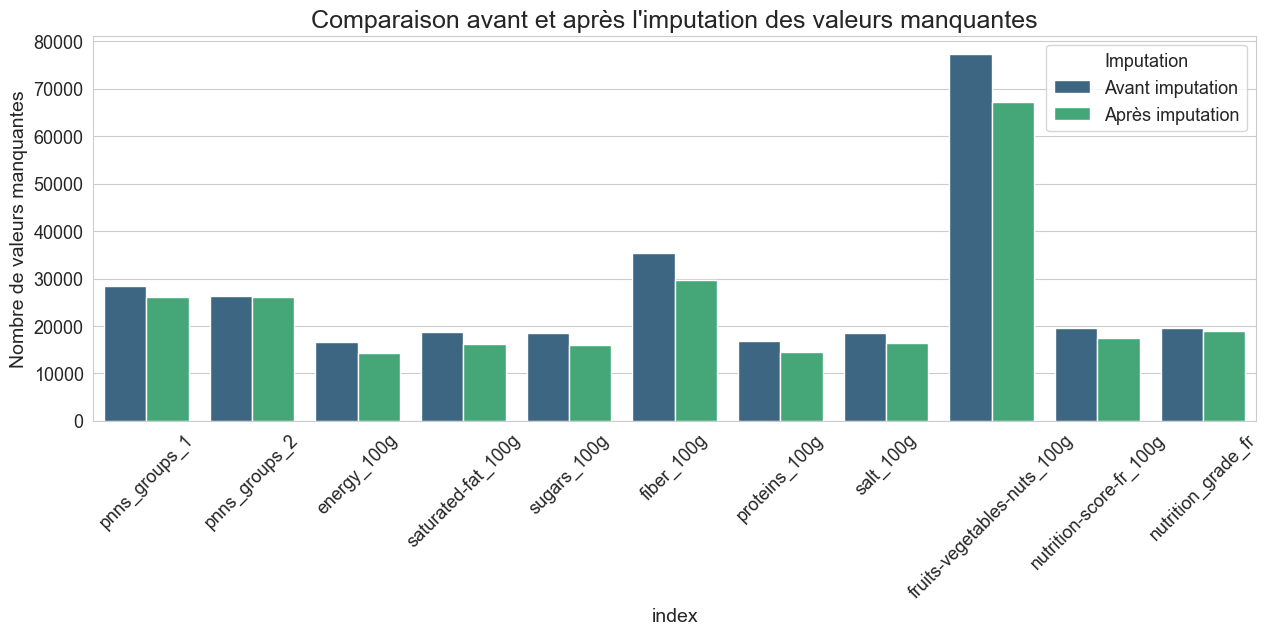

In [134]:
# Comparaison avant / après imputation
plt.figure(figsize=(15, 5))

target = ['pnns_groups_1',
          'pnns_groups_2',
          'energy_100g', 
          'saturated-fat_100g', 
          'sugars_100g', 
          'fiber_100g', 
          'proteins_100g', 
          'salt_100g', 
          'fruits-vegetables-nuts_100g',
          'nutrition-score-fr_100g',
           'nutrition_grade_fr']

sns.barplot(data=imputation_melted[imputation_melted['index'].isin(target)], 
            x='index', 
            y='Nombre de valeurs manquantes', 
            hue='Imputation', 
            palette='viridis')
plt.title("Comparaison avant et après l'imputation des valeurs manquantes")
plt.xticks(rotation=45)
plt.show()

Au global, il reste encore beaucoup de valeurs manquantes. Si l'on se concentre sur le groupe 'sugary-snacks' sur lequel nous avons focalisé nos actions d'imputation, les résultats sont bien meilleurs.

In [135]:
# Zoom sur 'pnns_groups_1' == 'sugary_snacks'
# récupération de l'état avant imputation des valeurs manquantes
sugary_before_imputation = before_imputation_df[before_imputation_df['pnns_groups_1']=='sugary-snacks'].isna().sum()

# Après imputation des valeurs manquantes
sugary_after_imputation = frfoodfacts_df[frfoodfacts_df['pnns_groups_1']=='sugary-snacks'].isna().sum()

# Synthèse
sugary_imput_comparison_df = pd.DataFrame({'Avant imputation' : sugary_before_imputation,
                                         'Après imputation' : sugary_after_imputation}).reset_index()

sugary_imput_melted = pd.melt(sugary_imput_comparison_df, 
                              id_vars='index', 
                              var_name='Imputation', 
                              value_name='Nombre de valeurs manquantes')


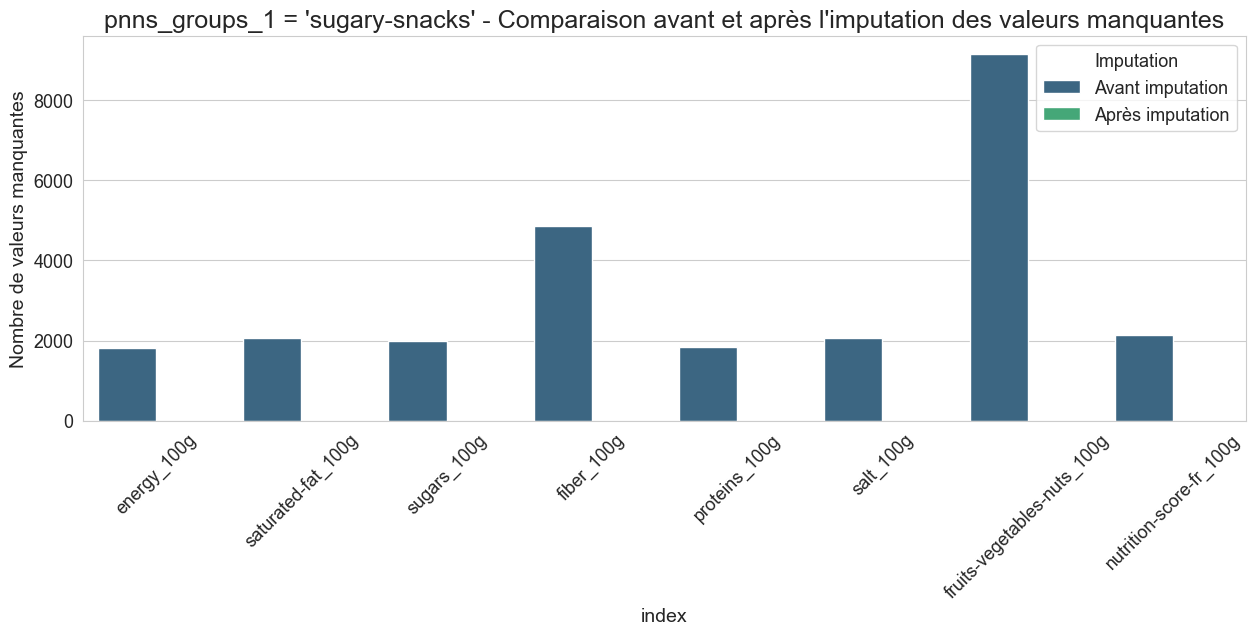

In [136]:
# Comparaison avant / après imputation
plt.figure(figsize=(15, 5))

target = ['energy_100g', 
          'saturated-fat_100g', 
          'sugars_100g', 
          'fiber_100g', 
          'proteins_100g', 
          'salt_100g', 
          'fruits-vegetables-nuts_100g',
          'nutrition-score-fr_100g']

sns.barplot(data=sugary_imput_melted[sugary_imput_melted['index'].isin(target)], 
            x='index', 
            y='Nombre de valeurs manquantes', 
            hue='Imputation', 
            palette='viridis')
plt.title("pnns_groups_1 = 'sugary-snacks' - Comparaison avant et après l'imputation des valeurs manquantes")
plt.xticks(rotation=45)
plt.show()

### b. Indicateur de confiance

In [137]:
# Comparer le dataframe avant imputation et après imputation
# ajouter une colonne vide
frfoodfacts_df['modification_count'] = np.nan

# Identifier les positions des valeurs modifiées
modified_positions = (frfoodfacts_df.notna() & before_imputation_df.ne(frfoodfacts_df))

# Compter les différences par ligne et stocker le résultat dans la nouvelle colonne
frfoodfacts_df['modification_count'] = modified_positions.sum(axis=1)

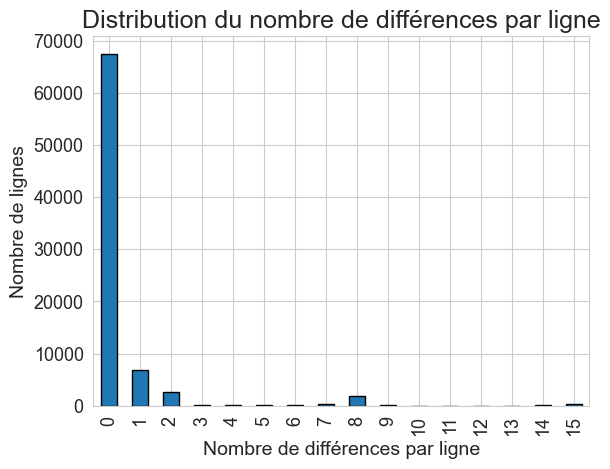

In [138]:
# Affichage de la distribution du nombre de modifications
count_by_differences = frfoodfacts_df['modification_count'].value_counts().sort_index()
count_by_differences.plot(kind='bar', edgecolor='black')
plt.xlabel('Nombre de différences par ligne')
plt.ylabel('Nombre de lignes')
plt.title('Distribution du nombre de différences par ligne')
plt.show()

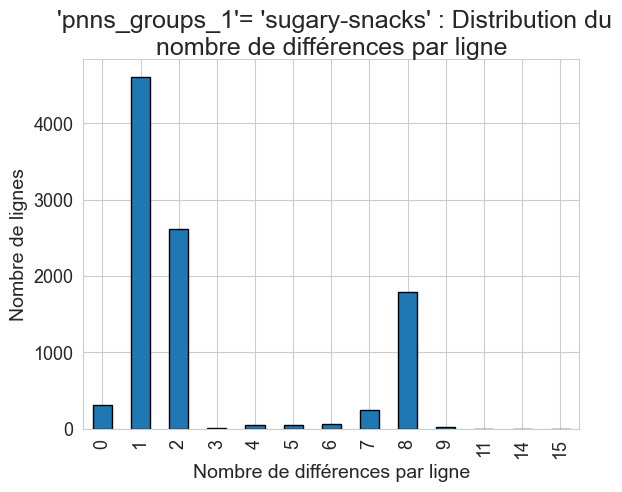

In [139]:
# Affichage de la distribution du nombre de modifications
sugary_imput = frfoodfacts_df[frfoodfacts_df['pnns_groups_1']=='sugary-snacks']

count_by_differences = sugary_imput['modification_count'].value_counts().sort_index()
count_by_differences.plot(kind='bar', edgecolor='black')
plt.xlabel('Nombre de différences par ligne')
plt.ylabel('Nombre de lignes')
plt.title(" 'pnns_groups_1'= 'sugary-snacks' : Distribution du nombre de différences par ligne", wrap = True)
plt.show()

In [140]:
# sauvegarde du dataframe nettoyé
frfoodfacts_df.to_pickle('frfoodfacts_df.pkl')

### c. Change log

In [141]:
# Options d'affichage : toutes les lignes
pd.set_option('display.max_rows', None)

In [142]:
display(change_log_df)

nb_rows  nb_columns                        change_type  \
0    320772         146                       Etat initial   
1     98845         146                             Filtre   
2     98671         146                             Filtre   
3     98671          26                             Filtre   
4     81196          26                        Suppression   
5     81196          26                  Type de variables   
6     81196          26                           Doublons   
7     81196          26                          Modalités   
8     81147          26                           Outliers   
9     81147          26                           Outliers   
10    81145          26                           Outliers   
11    81144          26                           Outliers   
12    81144          26                           Outliers   
13    81144          26                           Outliers   
14    81144          26                           Outliers   
15    81144          26                           Outliers   
16    81137          26                           Outliers   
17    81136          26                           Outliers   
18    81136          26                           Outliers   
19    81136          26                           Outliers   
20    81135          26                           Outliers   
21    81135          26                           Outliers   
22    81135          26                           Outliers   
23    81135          26                           Outliers   
24    81135          26                           Outliers   
25    80249          26                           Outliers   
26    80249          26                           Outliers   
27    80249          26  Imputation des valeurs manquantes   
28    80249          26   Imputation de valeurs manquantes   
29    80249          26   Imputation de valeurs manquantes   
30    80249          26   Imputation de valeurs manquantes   
31    80249          26   Imputation de valeurs manquantes   
32    80249          26   Imputation de valeurs manquantes   
33    80249          26  Imputation des valeurs manquantes   
34    80249          26   Imputation de valeurs manquantes   
35    80249          26   Imputation de valeurs manquantes   
36    80249          26   Imputation de valeurs manquantes   
37    80249          26   Imputation de valeurs manquantes   
38    80249          26  Imputation des valeurs manquantes   
39    80249          26   Imputation de valeurs manquantes   
40    80249          26   Imputation de valeurs manquantes   
41    80249          26  Imputation des valeurs manquantes   
42    80249          26  Imputation des valeurs manquantes   

                                                   on  \
0                                                   -   
1   countries_fr ==['France', 'Guadeloupe', 'La Ré...   
2                                    main_category_fr   
3   [code, created_datetime, last_modified_datetim...   
4   [pnns_groups_1, pnns_groups_2, main_category_f...   
5          [created_datetime, last_modified_datetime]   
6                                                code   
7    [pnns_groups_1, pnns_groups_2, main_category_fr]   
8                                         energy_100g   
9                             nutrition-score-fr_100g   
10                                        sodium_100g   
11                                           fat_100g   
12                                 saturated-fat_100g   
13                           monounsaturated-fat_100g   
14                           polyunsaturated-fat_100g   
15                                     trans-fat_100g   
16                                 carbohydrates_100g   
17                                        sugars_100g   
18                                        starch_100g   
19                                       polyols_100g   
20                                         fiber_100g   
21                   

## <font color='#46abe6'>2.8. Conclusion & Perspectives<a class="anchor" id="2_8"></a></font>

### Conclusions

Les tests ont démontrés qu'il est possible de mettre en place un système de suggestion ou d'auto-complétion pour aider les usagers à remplir la base de données Open Food Facts.

### Perspectives

- **Outliers :**
    - Alternative à la suppression des valeurs aberrantes : 
        - mettre les valeurs aberrantes à 'NaN' et les traiter ensuite avec les valeurs manquantes.
        - mettre un 'Warning' pour un traitement par un nutritionniste
    - Analyser plus en détails les outliers :
        - corriger les valeurs incorrectes dans la composition des produits
        - identifier les mauvaises catégorisations de produit `pnns_groups_1` et `pnns_groups_2` 
- **Valeurs manquantes :**
    - Variables catégorielles :
        - Pour les catégories de produits, `pnns_groups_1`, `pnns_groups_2`, une méthode de type knn peut être utilisée pour imputée les valeurs manquantes et 'unknown'.
        - Recherche de produits identiques ‘product_name’ et ‘brands’ avec un code barre différent (exemple : ‘quantity’ différente)
     - Variables numériques :
         - Utiliser la formule de calcul pour le nutrition score
         - Utiliser les relations suivantes pour vérifier et imputer les valeurs manquantes :
            - Matières grasses :
            - `saturated-fat__100g` = `butyric-acid_100g` + `caproic-acid_100g` + `caprylic-acid_100g` + `capric-acid_100g` + `lauric-acid_100g` + `myristic-acid_100g` + `palmitic-acid_100g` + `stearic-acid_100g` + `arachidic-acid_100g` + `behenic-acid_100g` + `lignoceric-acid_100g` + `cerotic-acid_100g` + `montanic-acid_100g` + `melissic-acid_100g`
            - `monounsaturated-fat_100g` = `oleic-acid_100g` + `elaidic-acid_100g` + `gondoic-acid_100g` + `mead-acid_100g` + `erucic-acid_100g` + `nervonic-acid_100g`
            - `polyunsaturated-fat_100g` = `omega-3-fat_100g` + `omega-6-fat_100g`
                - `omega-3-fat_100g` = `alpha-linolenic-acid_100g` + `eicosapentaenoic-acid_100g` + `docosahexaenoic-acid_100g`
                - `omega-6-fat_100g` = `linoleic-acid_100g` + `arachidonic-acid_100g` + `gamma-linolenic-acid_100g` + `dihomo-gamma-linolenic-acid_100g`
            - Sucres : `sugars_100g` = `sucrose_100g` + `glucose_100g` + `fructose_100g` + `lactose_100g` + `maltose_100g` + `maltodextrins_100g`
            -  Protéines : `proteins_100g` = `casein_100g` + `serum-proteins_100g` + `nucleotides_100g`